# Quick Diagnostic

In [2]:
import torch

if torch.cuda.is_available():
    print("✅ Great! PyTorch can see your GPU.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ Uh oh. PyTorch CANNOT see your GPU.")
    print("This is why your training is running on the CPU.")

✅ Great! PyTorch can see your GPU.
GPU Name: NVIDIA RTX A4000


In [3]:
import torch
import bitsandbytes

# 1. Verify PyTorch can see the GPU
if torch.cuda.is_available():
    print("✅ Success! PyTorch can see your NVIDIA RTX A4000.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ Error: PyTorch still CANNOT see your GPU.")

# 2. Verify bitsandbytes loaded
print(f"\n✅ bitsandbytes library loaded successfully.")

✅ Success! PyTorch can see your NVIDIA RTX A4000.
GPU Name: NVIDIA RTX A4000

✅ bitsandbytes library loaded successfully.


# DistilBERT

## Data Preprocessing

In [13]:
import torch
from datasets import load_dataset  # <--- Changed this line
import evaluate                      # <--- Added this line
from transformers import AutoTokenizer
import numpy as np

# --- 1. Load Model and Tokenizer ---
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# --- 2. Load Dataset ---
print("Loading IMDb dataset...")
dataset = load_dataset("mteb/imdb")

# --- 3. Define Preprocessing Function ---
def preprocess_function(examples):
    return tokenizer(
        examples["text"], 
        truncation=True, 
        padding="max_length", 
        max_length=256
    )

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# --- 4. Format Dataset for Training ---
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

print("--- Preprocessing Complete ---")
print(tokenized_dataset)
print(f"Example data point: {tokenized_dataset['train'][0]}")

# --- 5. Define Metric Computation Function ---
accuracy_metric = evaluate.load("accuracy")  # <--- Changed this line
f1_metric = evaluate.load("f1")              # <--- Changed this line

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_metric.compute(
        predictions=predictions, references=labels
    )["accuracy"]
    
    f1 = f1_metric.compute(
        predictions=predictions, references=labels, average="macro"
    )["f1"]
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1,
    }

print("Setup complete. Ready for training.")

C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading IMDb dataset...
Tokenizing dataset...
--- Preprocessing Complete ---
DatasetDict({
    train: Dataset({
        features: ['labels', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 24904
    })
    test: Dataset({
        features: ['labels', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 24678
    })
})
Example data point: {'labels': tensor(0), 'label_text': 'negative', 'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
         2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
         2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
         2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
         1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
         2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
         6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
         1012,  1026,  798

## Method 1 - Full Fine-Tuning (ExpID 01, Seed 42)

In [4]:
import time
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# --- Define the variable from the previous cell ---
model_checkpoint = "distilbert-base-uncased" 

# --- 1. Load Model (Method 1: Full Fine-Tuning) ---
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 01) ---
training_args = TrainingArguments(
    output_dir="./results/full_ft_seed_42",  # Directory to save results
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,   # 8 * 2 (grad_accum) = 16
    gradient_accumulation_steps=2,   # Effective batch size = 16
    seed=42,
    # --------------------------
    
    # Other standard settings
    logging_dir="./logs/full_ft_seed_42",
    eval_strategy="epoch",      # <-- FIX: Renamed from evaluation_strategy
    save_strategy="epoch",      # <-- FIX: Renamed from save_strategy
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 # Disables W&B logging
)

# --- 3. Initialize Trainer ---
# IMPORTANT: Make sure you have run the cell that defines 'compute_metrics'
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
# a) Count Trainable Parameters
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

# b) Reset CUDA memory stats (if GPU is available)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 01: Full Fine-Tuning (Seed 42) ---")
print(f"Model: {model_checkpoint}")

start_time = time.time()

trainer.train()

end_time = time.time()
training_time = end_time - start_time

# --- 6. Get VRAM Usage ---
peak_vram_bytes = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb = peak_vram_bytes / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results = trainer.evaluate()

# --- 8. Report All Metrics for ExpID 01 ---
print("\n--- Results for ExpID 01 (Seed 42) ---")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb:.4f}")
print(f"Trainable Params (M): {trainable_params / 1_000_000:.2f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\2457115683.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


--- Starting ExpID 01: Full Fine-Tuning (Seed 42) ---
Model: distilbert-base-uncased


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.263900,0.245202,0.904692,0.904575
2,0.196300,0.251912,0.910284,0.910258



--- Evaluating Test Set ---



--- Results for ExpID 01 (Seed 42) ---
Accuracy: 0.9103
F1-macro: 0.9103
Training Time (s): 728.67
Peak VRAM (GB): 1.6534
Trainable Params (M): 66.96


## Method 1 - Full Fine-Tuning (ExpID 01, Seed 43)

In [5]:
# --- 1. Load Model (Method 1: Full Fine-Tuning) ---
# We re-load the model to reset its weights
print("Reloading model for Full Fine-Tuning (Seed 43)...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 01, Seed 43) ---
training_args_s43 = TrainingArguments(
    output_dir="./results/full_ft_seed_43",  # <-- Changed
    logging_dir="./logs/full_ft_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                 # <-- Changed
    # --------------------------
    
    # Other standard settings
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_s43 = Trainer(
    model=model,
    args=training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
trainable_params_s43 = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 01: Full Fine-Tuning (Seed 43) ---")

start_time_s43 = time.time()
trainer_s43.train()
end_time_s43 = time.time()
training_time_s43 = end_time_s43 - start_time_s43

# --- 6. Get VRAM Usage ---
peak_vram_bytes_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_s43 = peak_vram_bytes_s43 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_s43 = trainer_s43.evaluate()

# --- 8. Report All Metrics for ExpID 01 (Seed 43) ---
print("\n--- Results for ExpID 01 (Seed 43) ---")
print(f"Accuracy: {eval_results_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_s43:.4f}")
print(f"Trainable Params (M): {trainable_params_s43 / 1_000_000:.2f}")

Reloading model for Full Fine-Tuning (Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\726904404.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_s43 = Trainer(


--- Starting ExpID 01: Full Fine-Tuning (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.262100,0.253366,0.903193,0.903129
2,0.202800,0.249459,0.908056,0.908018



--- Evaluating Test Set ---



--- Results for ExpID 01 (Seed 43) ---
Accuracy: 0.9081
F1-macro: 0.9080
Training Time (s): 730.37
Peak VRAM (GB): 2.4060
Trainable Params (M): 66.96


## Method 2 - LoRA Fine-Tuning (ExpID 02, Seed 42)

In [6]:
from peft import get_peft_model, LoraConfig

# --- 1. Load a FRESH Base Model ---
# We must reload the base model to apply adapters, 
# not use the one we've already fine-tuned.
print("Reloading base model for LoRA...")
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 02) ---
# From PDF: r=8, targets=[q,v], placement=Attn, alpha=16
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"], # [q,v] for DistilBert's attention
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", # Sequence Classification
)

# --- 3. Apply LoRA adapters to the base model ---
print("Applying LoRA adapters...")
lora_model = get_peft_model(base_model, lora_config)

# --- 4. Calculate and Print Trainable Parameters ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params} | "
        f"All Params: {all_param} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )

print("LoRA Model Parameter Count:")
print_trainable_parameters(lora_model)

# --- 5. Define Training Arguments (ExpID 02, Seed 42) ---
lora_training_args = TrainingArguments(
    output_dir="./results/lora_r8_seed_42",
    logging_dir="./logs/lora_r8_seed_42",
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
# We pass the lora_model to the Trainer
lora_trainer = Trainer(
    model=lora_model, # <-- Use the lora_model
    args=lora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 02: LoRA r=8 (Seed 42) ---")

start_time_lora = time.time()
lora_trainer.train()
end_time_lora = time.time()
training_time_lora = end_time_lora - start_time_lora

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora = peak_vram_bytes_lora / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora = lora_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 02 ---
print("\n--- Results for ExpID 02 (Seed 42) ---")
print(f"Accuracy: {eval_results_lora['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora:.4f}")

# Get the trainable param count again to be precise
trainable_params_lora = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora / 1_000_000:.2f}")

Reloading base model for LoRA...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\1134430940.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


Applying LoRA adapters...
LoRA Model Parameter Count:
Trainable Params: 739586 | All Params: 67694596 | Trainable %: 1.09
--- Starting ExpID 02: LoRA r=8 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.361700,0.335268,0.851528,0.851524
2,0.325400,0.324340,0.857565,0.857563



--- Evaluating Test Set ---



--- Results for ExpID 02 (Seed 42) ---
Accuracy: 0.8576
F1-macro: 0.8576
Training Time (s): 601.62
Peak VRAM (GB): 2.2852
Trainable Params (M): 0.74


## Method 2 - LoRA Fine-Tuning (ExpID 02, Seed 43)

In [7]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for LoRA (Seed 43)...")
base_model_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as before) ---
lora_config_s43 = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA adapters...")
lora_model_s43 = get_peft_model(base_model_s43, lora_config_s43)

# --- 4. Define Training Arguments (ExpID 02, Seed 43) ---
lora_training_args_s43 = TrainingArguments(
    output_dir="./results/lora_r8_seed_43",  # <-- Changed
    logging_dir="./logs/lora_r8_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                 # <-- Changed
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
lora_trainer_s43 = Trainer(
    model=lora_model_s43,
    args=lora_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 02: LoRA r=8 (Seed 43) ---")

start_time_lora_s43 = time.time()
lora_trainer_s43.train()
end_time_lora_s43 = time.time()
training_time_lora_s43 = end_time_lora_s43 - start_time_lora_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_lora_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_s43 = peak_vram_bytes_lora_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_s43 = lora_trainer_s43.evaluate()

# --- 10. Report All Metrics for ExpID 02 (Seed 43) ---
print("\n--- Results for ExpID 02 (Seed 43) ---")
print(f"Accuracy: {eval_results_lora_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_s43:.4f}")

# Get the trainable param count again
trainable_params_lora_s43 = sum(p.numel() for p in lora_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\48087584.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer_s43 = Trainer(


Applying LoRA adapters...
--- Starting ExpID 02: LoRA r=8 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.347800,0.339617,0.850798,0.850786
2,0.337600,0.326476,0.857201,0.857200



--- Evaluating Test Set ---



--- Results for ExpID 02 (Seed 43) ---
Accuracy: 0.8572
F1-macro: 0.8572
Training Time (s): 599.71
Peak VRAM (GB): 2.5435
Trainable Params (M): 0.74


## Method 2 - LoRA Rank Sensitivity (ExpID 03, Seed 42)

In [8]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for LoRA (r=16, Seed 42)...")
base_model_r16 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 03) ---
# The ONLY change from ExpID 02 is r=16
lora_config_r16 = LoraConfig(
    r=16, # <-- CHANGED
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"], # [q,v] for DistilBert
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (r=16) adapters...")
lora_model_r16 = get_peft_model(base_model_r16, lora_config_r16)

# --- 4. Calculate and Print Trainable Parameters ---
print("LoRA (r=16) Model Parameter Count:")
print_trainable_parameters(lora_model_r16) # Uses the function from ExpID 02

# --- 5. Define Training Arguments (ExpID 03, Seed 42) ---
lora_r16_training_args = TrainingArguments(
    output_dir="./results/lora_r16_seed_42",
    logging_dir="./logs/lora_r16_seed_42",
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_r16_trainer = Trainer(
    model=lora_model_r16,
    args=lora_r16_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 03: LoRA r=16 (Seed 42) ---")

start_time_lora_r16 = time.time()
lora_r16_trainer.train()
end_time_lora_r16 = time.time()
training_time_lora_r16 = end_time_lora_r16 - start_time_lora_r16

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_r16 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_r16 = peak_vram_bytes_lora_r16 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_r16 = lora_r16_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 03 (Seed 42) ---
print("\n--- Results for ExpID 03 (Seed 42) ---")
print(f"Accuracy: {eval_results_lora_r16['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_r16['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_r16:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_r16:.4f}")

# Get the trainable param count again
trainable_params_lora_r16 = sum(p.numel() for p in lora_model_r16.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_r16 / 1_000_000:.2f}")

Reloading base model for LoRA (r=16, Seed 42)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\3270086200.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_r16_trainer = Trainer(


Applying LoRA (r=16) adapters...
LoRA (r=16) Model Parameter Count:
Trainable Params: 887042 | All Params: 67842052 | Trainable %: 1.31
--- Starting ExpID 03: LoRA r=16 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.358200,0.333224,0.853189,0.853186
2,0.323700,0.322730,0.858052,0.858049



--- Evaluating Test Set ---



--- Results for ExpID 03 (Seed 42) ---
Accuracy: 0.8581
F1-macro: 0.8580
Training Time (s): 598.60
Peak VRAM (GB): 2.8056
Trainable Params (M): 0.89


## Method 2 - LoRA Rank Sensitivity (ExpID 03, Seed 43)

In [9]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for LoRA (r=16, Seed 43)...")
base_model_r16_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 03) ---
lora_config_r16_s43 = LoraConfig(
    r=16, # <-- Rank 16
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (r=16) adapters...")
lora_model_r16_s43 = get_peft_model(base_model_r16_s43, lora_config_r16_s43)

# --- 4. Define Training Arguments (ExpID 03, Seed 43) ---
lora_r16_s43_training_args = TrainingArguments(
    output_dir="./results/lora_r16_seed_43",  # <-- Changed
    logging_dir="./logs/lora_r16_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                 # <-- Changed
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
lora_r16_s43_trainer = Trainer(
    model=lora_model_r16_s43,
    args=lora_r16_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 03: LoRA r=16 (Seed 43) ---")

start_time_lora_r16_s43 = time.time()
lora_r16_s43_trainer.train()
end_time_lora_r16_s43 = time.time()
training_time_lora_r16_s43 = end_time_lora_r16_s43 - start_time_lora_r16_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_lora_r16_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_r16_s43 = peak_vram_bytes_lora_r16_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_r16_s43 = lora_r16_s43_trainer.evaluate()

# --- 10. Report All Metrics for ExpID 03 (Seed 43) ---
print("\n--- Results for ExpID 03 (Seed 43) ---")
print(f"Accuracy: {eval_results_lora_r16_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_r16_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_r16_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_r16_s43:.4f}")

# Get the trainable param count again
trainable_params_lora_r16_s43 = sum(p.numel() for p in lora_model_r16_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_r16_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (r=16, Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\2080378308.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_r16_s43_trainer = Trainer(


Applying LoRA (r=16) adapters...
--- Starting ExpID 03: LoRA r=16 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.346800,0.338122,0.851487,0.851479
2,0.336200,0.325093,0.858092,0.858092



--- Evaluating Test Set ---



--- Results for ExpID 03 (Seed 43) ---
Accuracy: 0.8581
F1-macro: 0.8581
Training Time (s): 598.44
Peak VRAM (GB): 3.0656
Trainable Params (M): 0.89


## Method 2 - LoRA Placement (ExpID 04, Seed 42)

In [10]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for LoRA (Attn+FFN, Seed 42)...")
base_model_ffn = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- Optional: Print model to see all layer names ---
# print(base_model_ffn) 
# You would see 'q_lin', 'v_lin' in 'attention'
# and 'lin1', 'lin2' in 'ffn'

# --- 2. Define LoRA Configuration (ExpID 04) ---
# We now add the FFN layers 'lin1' and 'lin2'
lora_config_ffn = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"], # <-- CHANGED
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_ffn = get_peft_model(base_model_ffn, lora_config_ffn)

# --- 4. Calculate and Print Trainable Parameters ---
print("LoRA (Attn+FFN) Model Parameter Count:")
print_trainable_parameters(lora_model_ffn) # Uses the function from ExpID 02

# --- 5. Define Training Arguments (ExpID 04, Seed 42) ---
lora_ffn_training_args = TrainingArguments(
    output_dir="./results/lora_r16_ffn_seed_42", # <-- Changed
    logging_dir="./logs/lora_r16_ffn_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_ffn_trainer = Trainer(
    model=lora_model_ffn,
    args=lora_ffn_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 04: LoRA r=16 Attn+FFN (Seed 42) ---")

start_time_lora_ffn = time.time()
lora_ffn_trainer.train()
end_time_lora_ffn = time.time()
training_time_lora_ffn = end_time_lora_ffn - start_time_lora_ffn

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_ffn = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_ffn = peak_vram_bytes_lora_ffn / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_ffn = lora_ffn_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 04 (Seed 42) ---
print("\n--- Results for ExpID 04 (Seed 42) ---")
print(f"Accuracy: {eval_results_lora_ffn['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_ffn['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_ffn:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_ffn:.4f}")

# Get the trainable param count again
trainable_params_lora_ffn = sum(p.numel() for p in lora_model_ffn.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_ffn / 1_000_000:.2f}")

Reloading base model for LoRA (Attn+FFN, Seed 42)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\3572417805.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_ffn_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
LoRA (Attn+FFN) Model Parameter Count:
Trainable Params: 1624322 | All Params: 68579332 | Trainable %: 2.37
--- Starting ExpID 04: LoRA r=16 Attn+FFN (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.337700,0.310557,0.864859,0.864837
2,0.303200,0.300236,0.870614,0.870573



--- Evaluating Test Set ---



--- Results for ExpID 04 (Seed 42) ---
Accuracy: 0.8706
F1-macro: 0.8706
Training Time (s): 690.14
Peak VRAM (GB): 3.5674
Trainable Params (M): 1.62


## Method 2 - LoRA Placement (ExpID 04, Seed 43)

In [11]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for LoRA (Attn+FFN, Seed 43)...")
base_model_ffn_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 04) ---
lora_config_ffn_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"], # Attn + FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_ffn_s43 = get_peft_model(base_model_ffn_s43, lora_config_ffn_s43)

# --- 4. Define Training Arguments (ExpID 04, Seed 43) ---
lora_ffn_s43_training_args = TrainingArguments(
    output_dir="./results/lora_r16_ffn_seed_43", # <-- Changed
    logging_dir="./logs/lora_r16_ffn_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                 # <-- Changed
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
lora_ffn_s43_trainer = Trainer(
    model=lora_model_ffn_s43,
    args=lora_ffn_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 04: LoRA r=16 Attn+FFN (Seed 43) ---")

start_time_lora_ffn_s43 = time.time()
lora_ffn_s43_trainer.train()
end_time_lora_ffn_s43 = time.time()
training_time_lora_ffn_s43 = end_time_lora_ffn_s43 - start_time_lora_ffn_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_lora_ffn_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_ffn_s43 = peak_vram_bytes_lora_ffn_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_ffn_s43 = lora_ffn_s43_trainer.evaluate()

# --- 10. Report All Metrics for ExpID 04 (Seed 43) ---
print("\n--- Results for ExpID 04 (Seed 43) ---")
print(f"Accuracy: {eval_results_lora_ffn_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_ffn_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_ffn_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_ffn_s43:.4f}")

# Get the trainable param count again
trainable_params_lora_ffn_s43 = sum(p.numel() for p in lora_model_ffn_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_ffn_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (Attn+FFN, Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19708\2419051285.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_ffn_s43_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
--- Starting ExpID 04: LoRA r=16 Attn+FFN (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.325300,0.314523,0.865386,0.865380
2,0.314000,0.299579,0.870816,0.870797



--- Evaluating Test Set ---



--- Results for ExpID 04 (Seed 43) ---
Accuracy: 0.8708
F1-macro: 0.8708
Training Time (s): 690.48
Peak VRAM (GB): 3.8356
Trainable Params (M): 1.62


## Method 3 - QLORA (ExpID 05, Seed 42)

In [7]:
# Safe auto-diagnostic + minimal auto-fix for the 'only Tensors of floating point dtype can require gradients' error
import torch, torch.nn as nn
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training

# --- Adjust these as in your environment ---
model_checkpoint = model_checkpoint  # keep your variable
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4",
                               bnb_4bit_compute_dtype=torch.float16, bnb_4bit_use_double_quant=True)

# --- 0. Reload a fresh base model (avoids "modified a model with PEFT for a second time" issues) ---
print("Reloading fresh base model (safe)...")
base = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, quantization_config=bnb_config, device_map="auto"
)

# --- 1. prepare for k-bit training ---
print("Preparing model for k-bit training...")
base = prepare_model_for_kbit_training(base)

# --- 2. define your LoRA config (modules_to_save should include classifier or other small heads you want saved) ---
qlora_lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    modules_to_save=["classifier", "pre_classifier"]  # include suspected small heads
)

# --- Helper: test requires_grad on every parameter in a named module; returns True if OK, False if fails ---
def test_set_requires_grad(model, module_path):
    parts = module_path.split(".")
    parent = model
    try:
        for p in parts[:-1]:
            parent = getattr(parent, p)
        name = parts[-1]
        mod = getattr(parent, name)
    except Exception:
        print(f"[test] {module_path} not found.")
        return True  # treat missing as okay for now

    # attempt to set requires_grad on every parameter of that module (in try/except)
    try:
        for param in mod.parameters():
            param.requires_grad_(True)
        # restore to False (we're just testing)
        for param in mod.parameters():
            param.requires_grad_(False)
        print(f"[ok] {module_path}: can be set to requires_grad.")
        return True
    except Exception as e:
        print(f"[fail] {module_path}: cannot be made trainable -> {e}")
        return False

# --- 3. Run diagnostics on modules_to_save and common heads ---
modules_to_check = list(set(qlora_lora_config.modules_to_save or [] + ["classifier", "pre_classifier"]))
print("Diagnostic check for modules_to_check:", modules_to_check)

failing = []
for m in modules_to_check:
    ok = test_set_requires_grad(base, m)
    if not ok:
        failing.append(m)

# --- 4. Auto-replace only failing modules with small float nn.Linear if possible ---
def replace_with_linear_if_quantized(model, module_path):
    parts = module_path.split(".")
    parent = model
    try:
        for p in parts[:-1]:
            parent = getattr(parent, p)
        name = parts[-1]
        orig = getattr(parent, name)
    except Exception:
        print(f"[replace] {module_path}: not found, skipping.")
        return False

    # If already float, nothing to do
    if hasattr(orig, "weight") and orig.weight.is_floating_point():
        print(f"[replace] {module_path}: already float ({orig.weight.dtype}).")
        return True

    # Replace only if we can infer a 2D weight (linear)
    if hasattr(orig, "weight") and orig.weight.ndim == 2:
        w = orig.weight
        out_f, in_f = w.shape
        bias_exists = hasattr(orig, "bias") and getattr(orig, "bias") is not None
        new = nn.Linear(in_f, out_f, bias=bias_exists)
        # move new to same device as model params
        dev = next(model.parameters()).device
        new = new.to(device=dev, dtype=torch.float32)
        setattr(parent, name, new)
        print(f"[replace] {module_path}: replaced with nn.Linear({in_f}->{out_f}) float32")
        return True

    print(f"[replace] {module_path}: cannot infer shape (skipped).")
    return False

replaced_any = False
for m in failing:
    replaced = replace_with_linear_if_quantized(base, m)
    replaced_any = replaced_any or replaced

if replaced_any:
    print("One or more failing modules were replaced with float nn.Linear. Retesting makes sense.")
    # re-run diagnostic to confirm
    failing = [m for m in modules_to_check if not test_set_requires_grad(base, m)]

if len(failing) > 0:
    print("Still failing modules after auto-replacements:", failing)
    print("Please paste this list if you want me to craft replacements manually.")
else:
    print("All checked modules are now float/trainable (or absent). Proceeding to get_peft_model.")

# --- 5. Now call get_peft_model safely ---
qlora_model = get_peft_model(base, qlora_lora_config)
print("PEFT injection complete. Model is ready.")


Reloading fresh base model (safe)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing model for k-bit training...
Diagnostic check for modules_to_check: ['classifier', 'pre_classifier']
[ok] classifier: can be set to requires_grad.
[fail] pre_classifier: cannot be made trainable -> only Tensors of floating point dtype can require gradients
[replace] pre_classifier: replaced with nn.Linear(1->294912) float32
One or more failing modules were replaced with float nn.Linear. Retesting makes sense.
[ok] classifier: can be set to requires_grad.
[ok] pre_classifier: can be set to requires_grad.
All checked modules are now float/trainable (or absent). Proceeding to get_peft_model.
PEFT injection complete. Model is ready.


In [10]:
# ================================================================
# ✅ QLoRA Fine-Tuning (DistilBERT, r=16) — Final Stable Version
# ================================================================
import torch
import torch.nn as nn
import time
from transformers import (
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
)
import bitsandbytes as bnb

# ================================================================
# 1️⃣ Load quantized DistilBERT
# ================================================================
model_checkpoint = "distilbert-base-uncased"   # or your own checkpoint

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("🔹 Loading 4-bit quantized model...")
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto",
)

# ================================================================
# 2️⃣ Prepare for k-bit training
# ================================================================
print("🔹 Preparing model for k-bit training...")
base_model = prepare_model_for_kbit_training(base_model)

# ================================================================
# 3️⃣ Ensure pre_classifier is float & correct shape
# ================================================================
hidden_size = getattr(base_model.config, "hidden_size", 768)
device = next(base_model.parameters()).device
print(f"Detected hidden size: {hidden_size}")

# Replace pre_classifier safely (768→768 for DistilBERT)
base_model.pre_classifier = nn.Linear(hidden_size, hidden_size).to(device=device, dtype=torch.float32)
print(f"✅ pre_classifier fixed as nn.Linear({hidden_size}, {hidden_size})")

# ================================================================
# 4️⃣ Define LoRA configuration
# ================================================================
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    modules_to_save=["classifier", "pre_classifier"],  # safe now
)

print("🔹 Applying LoRA adapters...")
qlora_model = get_peft_model(base_model, lora_config)
print("✅ LoRA adapters successfully injected.")

# ================================================================
# 5️⃣ Print parameter summary
# ================================================================
def print_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,} "
          f"({100 * trainable / total:.2f}% trainable)")

print_trainable_parameters(qlora_model)

# ================================================================
# 6️⃣ Optimizer fallback
# ================================================================
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except Exception as e:
    print(f"⚠️ bitsandbytes optimizer not usable ({e}), falling back to adamw_torch.")
    optim_choice = "adamw_torch"

# ================================================================
# 7️⃣ TrainingArguments
# ================================================================
qlora_training_args = TrainingArguments(
    output_dir="./results/qlora_r16_seed_42",
    logging_dir="./logs/qlora_r16_seed_42",
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    optim=optim_choice,
    eval_strategy="epoch",          # correct for your transformers version
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

# ================================================================
# 8️⃣ Initialize Trainer (define compute_metrics earlier)
# ================================================================
qlora_trainer = Trainer(
    model=qlora_model,
    args=qlora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ================================================================
# 9️⃣ Train and evaluate
# ================================================================
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

print("\n🚀 Starting QLoRA Fine-tuning...")
start_time = time.time()
train_result = qlora_trainer.train()
end_time = time.time()
training_time = end_time - start_time

# ================================================================
# 🔟 Evaluate and report
# ================================================================
print("\n🔹 Evaluating on test set...")
eval_results = qlora_trainer.evaluate()

peak_vram_gb = (torch.cuda.max_memory_allocated() / (1024**3)) if torch.cuda.is_available() else 0

print("\n📊 === QLoRA Experiment Summary ===")
print(f"Accuracy: {eval_results.get('eval_accuracy', 0):.4f}")
print(f"F1-macro: {eval_results.get('eval_f1_macro', 0):.4f}")
print(f"Training Time: {training_time/60:.2f} min")
print(f"Peak VRAM Usage: {peak_vram_gb:.2f} GB")

trainable_params = sum(p.numel() for p in qlora_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in qlora_model.parameters())
print(f"Trainable Params: {trainable_params/1_000_000:.2f}M / {total_params/1_000_000:.2f}M "
      f"({100*trainable_params/total_params:.2f}% trainable)")

print("\n✅ Training completed successfully.")

# ================================================================
# 11️⃣ Optional: Save final model
# ================================================================
qlora_model.save_pretrained("./qlora_distilbert_lora_r16_seed42")
tokenizer.save_pretrained("./qlora_distilbert_lora_r16_seed42")
print("💾 Model and tokenizer saved successfully.")


🔹 Loading 4-bit quantized model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\3661179343.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer = Trainer(


🔹 Preparing model for k-bit training...
Detected hidden size: 768
✅ pre_classifier fixed as nn.Linear(768, 768)
🔹 Applying LoRA adapters...
✅ LoRA adapters successfully injected.
Trainable params: 1,624,322 / 47,345,668 (3.43% trainable)
✅ Using paged_adamw_8bit optimizer.

🚀 Starting QLoRA Fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.343500,0.313890,0.865305,0.865277
2,0.305200,0.301151,0.871505,0.871477


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



🔹 Evaluating on test set...



📊 === QLoRA Experiment Summary ===
Accuracy: 0.8715
F1-macro: 0.8715
Training Time: 16.60 min
Peak VRAM Usage: 0.65 GB
Trainable Params: 1.62M / 47.35M (3.43% trainable)

✅ Training completed successfully.
💾 Model and tokenizer saved successfully.


## Method 3 - QLORA (ExpID 05, Seed 43)

In [11]:
# --- 1. Load 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model (Seed 43)...")
bnb_config_s43 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
base_model_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    quantization_config=bnb_config_s43,
    device_map="auto",
)

# --- 2. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
base_model_s43 = prepare_model_for_kbit_training(base_model_s43)

# --- 3. Ensure pre_classifier is float & correct shape ---
hidden_size_s43 = getattr(base_model_s43.config, "hidden_size", 768)
device_s43 = next(base_model_s43.parameters()).device
base_model_s43.pre_classifier = nn.Linear(hidden_size_s43, hidden_size_s43).to(device=device_s43, dtype=torch.float32)
print(f"✅ pre_classifier fixed as nn.Linear({hidden_size_s43}, {hidden_size_s43})")

# --- 4. Define LoRA configuration ---
lora_config_s43 = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    modules_to_save=["classifier", "pre_classifier"],
)
print("🔹 Applying LoRA adapters...")
qlora_model_s43 = get_peft_model(base_model_s43, lora_config_s43)
print("✅ LoRA adapters successfully injected.")

# --- 5. Optimizer fallback ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_s43 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except Exception:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_s43 = "adamw_torch"

# --- 6. TrainingArguments ---
qlora_training_args_s43 = TrainingArguments(
    output_dir="./results/qlora_r16_seed_43",  # <-- CHANGED
    logging_dir="./logs/qlora_r16_seed_43",    # <-- CHANGED
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                  # <-- CHANGED
    optim=optim_choice_s43,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

# --- 7. Initialize Trainer ---
qlora_trainer_s43 = Trainer(
    model=qlora_model_s43,
    args=qlora_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- 8. Train and evaluate ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

print("\n🚀 Starting QLoRA Fine-tuning (Seed 43)...")
start_time_s43 = time.time()
qlora_trainer_s43.train()
end_time_s43 = time.time()
training_time_s43 = end_time_s43 - start_time_s43

# --- 9. Evaluate and report ---
print("\n🔹 Evaluating on test set...")
eval_results_s43 = qlora_trainer_s43.evaluate()

peak_vram_gb_s43 = (torch.cuda.max_memory_allocated() / (1024**3)) if torch.cuda.is_available() else 0

print("\n📊 === QLoRA Experiment Summary (Seed 43) ===")
print(f"Accuracy: {eval_results_s43.get('eval_accuracy', 0):.4f}")
print(f"F1-macro: {eval_results_s43.get('eval_f1_macro', 0):.4f}")
print(f"Training Time: {training_time_s43/60:.2f} min")
print(f"Peak VRAM Usage: {peak_vram_gb_s43:.2f} GB")

trainable_params_s43 = sum(p.numel() for p in qlora_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_s43/1_000_000:.2f}M")

🔹 Loading 4-bit quantized model (Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\2747728494.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer_s43 = Trainer(


🔹 Preparing model for k-bit training...
✅ pre_classifier fixed as nn.Linear(768, 768)
🔹 Applying LoRA adapters...
✅ LoRA adapters successfully injected.
✅ Using paged_adamw_8bit optimizer.

🚀 Starting QLoRA Fine-tuning (Seed 43)...


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.330500,0.319542,0.863968,0.863966
2,0.317000,0.302799,0.869195,0.869191


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



🔹 Evaluating on test set...



📊 === QLoRA Experiment Summary (Seed 43) ===
Accuracy: 0.8692
F1-macro: 0.8692
Training Time: 16.52 min
Peak VRAM Usage: 0.77 GB
Trainable Params (M): 1.62M


## Method 4 - Adapter Tuning (IA³) (ExpID 06, Seed 42)

In [13]:
from peft import get_peft_model, IA3Config

# --- 1. Load a FRESH Base Model ---
print("Reloading base model for IA³...")
base_model_ia3 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (ExpID 06) ---
# PDF: Location=Attn+FFN, targets=v-only
# For DistilBert, this means 'v_lin' in attention and 'lin2' in the FFN.
ia3_config = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["v_lin", "lin2"],  # <-- FIX: List ALL targets here
    feedforward_modules=["lin2"],   # <-- FIX: List FFN layers here (must be subset of above)
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model = get_peft_model(base_model_ia3, ia3_config)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model) # Uses the function from ExpID 02

# --- 5. Define Training Arguments (ExpID 06, Seed 42) ---
ia3_training_args = TrainingArguments(
    output_dir="./results/ia3_ffn_seed_42",
    logging_dir="./logs/ia3_ffn_seed_42",   
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer = Trainer(
    model=ia3_model,
    args=ia3_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 06: IA³ Attn+FFN (Seed 42) ---")

start_time_ia3 = time.time()
ia3_trainer.train()
end_time_ia3 = time.time()
training_time_ia3 = end_time_ia3 - start_time_ia3

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3 = peak_vram_bytes_ia3 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3 = ia3_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 06 (Seed 42) ---
print("\n--- Results for ExpID 06 (Seed 42) ---")
print(f"Accuracy: {eval_results_ia3['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3:.4f}")

# Get the trainable param count again
trainable_params_ia3 = sum(p.numel() for p in ia3_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3 / 1_000_000:.2f}")

Reloading base model for IA³...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\3739718729.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer = Trainer(


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable params: 615,170 / 67,570,180 (0.91% trainable)
--- Starting ExpID 06: IA³ Attn+FFN (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.547100,0.508368,0.809061,0.809036
2,0.472900,0.462834,0.815747,0.815743



--- Evaluating Test Set ---



--- Results for ExpID 06 (Seed 42) ---
Accuracy: 0.8157
F1-macro: 0.8157
Training Time (s): 597.67
Peak VRAM (GB): 1.3990
Trainable Params (M): 0.62


## Method 3 - QLORA (ExpID 05, Seed 42)

In [14]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for IA³ (Seed 43)...")
base_model_ia3_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (ExpID 06) ---
ia3_config_s43 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["v_lin", "lin2"],  # Attn + FFN
    feedforward_modules=["lin2"],   # FFN layers
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_s43 = get_peft_model(base_model_ia3_s43, ia3_config_s43)

# --- 4. Define Training Arguments (ExpID 06, Seed 43) ---
ia3_training_args_s43 = TrainingArguments(
    output_dir="./results/ia3_ffn_seed_43", # <-- Changed
    logging_dir="./logs/ia3_ffn_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                               # <-- Changed
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
ia3_trainer_s43 = Trainer(
    model=ia3_model_s43,
    args=ia3_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 06: IA³ Attn+FFN (Seed 43) ---")

start_time_ia3_s43 = time.time()
ia3_trainer_s43.train()
end_time_ia3_s43 = time.time()
training_time_ia3_s43 = end_time_ia3_s43 - start_time_ia3_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_ia3_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_s43 = peak_vram_bytes_ia3_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_s43 = ia3_trainer_s43.evaluate()

# --- 10. Report All Metrics for ExpID 06 (Seed 43) ---
print("\n--- Results for ExpID 06 (Seed 43) ---")
print(f"Accuracy: {eval_results_ia3_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_s43:.4f}")

# Get the trainable param count again
trainable_params_ia3_s43 = sum(p.numel() for p in ia3_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_s43 / 1_000_000:.2f}")

Reloading base model for IA³ (Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\1462578776.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer_s43 = Trainer(


Applying IA³ adapters...
--- Starting ExpID 06: IA³ Attn+FFN (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.552400,0.517113,0.806062,0.805919
2,0.483500,0.467990,0.813153,0.813151



--- Evaluating Test Set ---



--- Results for ExpID 06 (Seed 43) ---
Accuracy: 0.8132
F1-macro: 0.8132
Training Time (s): 598.99
Peak VRAM (GB): 1.6573
Trainable Params (M): 0.62


## Optimization Sensitivity (ExpID 07, Seed 42)

In [15]:
# --- 1. Load Model (Full Fine-Tuning) ---
print("Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 42)...")
model_ft_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 07, Full FT) ---
training_args_ft_lr2 = TrainingArguments(
    output_dir="./results/full_ft_lr2_seed_42",  # <-- Changed
    logging_dir="./logs/full_ft_lr2_seed_42",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_ft_lr2 = Trainer(
    model=model_ft_lr2,
    args=training_args_ft_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: Full FT, LR=2e-5 (Seed 42) ---")

start_time_ft_lr2 = time.time()
trainer_ft_lr2.train()
end_time_ft_lr2 = time.time()
training_time_ft_lr2 = end_time_ft_lr2 - start_time_ft_lr2

# --- 6. Get VRAM Usage ---
peak_vram_bytes_ft_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ft_lr2 = peak_vram_bytes_ft_lr2 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ft_lr2 = trainer_ft_lr2.evaluate()

# --- 8. Report All Metrics for ExpID 07 (Full FT, Seed 42) ---
print("\n--- Results for ExpID 07 (Full FT, Seed 42) ---")
print(f"Accuracy: {eval_results_ft_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ft_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ft_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ft_lr2:.4f}")

Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 42)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\704383729.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ft_lr2 = Trainer(


--- Starting ExpID 07: Full FT, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.260800,0.256462,0.904247,0.904018
2,0.164100,0.272858,0.913688,0.913679



--- Evaluating Test Set ---



--- Results for ExpID 07 (Full FT, Seed 42) ---
Accuracy: 0.9137
F1-macro: 0.9137
Training Time (s): 748.98
Peak VRAM (GB): 2.6488


## Optimization Sensitivity (ExpID 07, Seed 43)

In [16]:
# --- 1. Load Model (Full Fine-Tuning) ---
print("Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 43)...")
model_ft_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 07, Full FT, Seed 43) ---
training_args_ft_lr2_s43 = TrainingArguments(
    output_dir="./results/full_ft_lr2_seed_43",  # <-- Changed
    logging_dir="./logs/full_ft_lr2_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_ft_lr2_s43 = Trainer(
    model=model_ft_lr2_s43,
    args=training_args_ft_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: Full FT, LR=2e-5 (Seed 43) ---")

start_time_ft_lr2_s43 = time.time()
trainer_ft_lr2_s43.train()
end_time_ft_lr2_s43 = time.time()
training_time_ft_lr2_s43 = end_time_ft_lr2_s43 - start_time_ft_lr2_s43

# --- 6. Get VRAM Usage ---
peak_vram_bytes_ft_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ft_lr2_s43 = peak_vram_bytes_ft_lr2_s43 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ft_lr2_s43 = trainer_ft_lr2_s43.evaluate()

# --- 8. Report All Metrics for ExpID 07 (Full FT, Seed 43) ---
print("\n--- Results for ExpID 07 (Full FT, Seed 43) ---")
print(f"Accuracy: {eval_results_ft_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ft_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ft_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ft_lr2_s43:.4f}")

Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\3793349534.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ft_lr2_s43 = Trainer(


--- Starting ExpID 07: Full FT, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.256700,0.260791,0.906637,0.906557
2,0.167400,0.258446,0.913364,0.913347



--- Evaluating Test Set ---



--- Results for ExpID 07 (Full FT, Seed 43) ---
Accuracy: 0.9134
F1-macro: 0.9133
Training Time (s): 749.50
Peak VRAM (GB): 3.4007


## Optimization Sensitivity (ExpID 07, LoRA, Seed 42)

In [17]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 42)...")
base_model_lora_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as ExpID 04) ---
lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"], # Attn + FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_lr2 = get_peft_model(base_model_lora_lr2, lora_config_lr2)

# --- 4. Define Training Arguments (ExpID 07, LoRA, Seed 42) ---
lora_lr2_training_args = TrainingArguments(
    output_dir="./results/lora_r16_ffn_lr2_seed_42", # <-- Changed
    logging_dir="./logs/lora_r16_ffn_lr2_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
lora_lr2_trainer = Trainer(
    model=lora_model_lr2,
    args=lora_lr2_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: LoRA r=16 Attn+FFN, LR=2e-5 (Seed 42) ---")

start_time_lora_lr2 = time.time()
lora_lr2_trainer.train()
end_time_lora_lr2 = time.time()
training_time_lora_lr2 = end_time_lora_lr2 - start_time_lora_lr2

# --- 8. Get VRAM Usage ---
peak_vram_bytes_lora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_lr2 = peak_vram_bytes_lora_lr2 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_lr2 = lora_lr2_trainer.evaluate()

# --- 10. Report All Metrics for ExpID 07 (LoRA, Seed 42) ---
print("\n--- Results for ExpID 07 (LoRA, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_lr2:.4f}")

# Get the trainable param count again
trainable_params_lora_lr2 = sum(p.numel() for p in lora_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_lr2 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 42)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\4153122601.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_lr2_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
--- Starting ExpID 07: LoRA r=16 Attn+FFN, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.311200,0.286867,0.878191,0.878112
2,0.278800,0.276663,0.883337,0.883282



--- Evaluating Test Set ---



--- Results for ExpID 07 (LoRA, Seed 42) ---
Accuracy: 0.8833
F1-macro: 0.8833
Training Time (s): 704.68
Peak VRAM (GB): 3.5138
Trainable Params (M): 1.62


## Optimization Sensitivity (ExpID 07, LoRA, Seed 43)

In [18]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 43)...")
base_model_lora_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as ExpID 04) ---
lora_config_lr2_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"], # Attn + FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_lr2_s43 = get_peft_model(base_model_lora_lr2_s43, lora_config_lr2_s43)

# --- 4. Define Training Arguments (ExpID 07, LoRA, Seed 43) ---
lora_lr2_s43_training_args = TrainingArguments(
    output_dir="./results/lora_r16_ffn_lr2_seed_43", # <-- Changed
    logging_dir="./logs/lora_r16_ffn_lr2_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
lora_lr2_s43_trainer = Trainer(
    model=lora_model_lr2_s43,
    args=lora_lr2_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: LoRA r=16 Attn+FFN, LR=2e-5 (Seed 43) ---")

start_time_lora_lr2_s43 = time.time()
lora_lr2_s43_trainer.train()
end_time_lora_lr2_s43 = time.time()
training_time_lora_lr2_s43 = end_time_lora_lr2_s43 - start_time_lora_lr2_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_lora_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_lr2_s43 = peak_vram_bytes_lora_lr2_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_lr2_s43 = lora_lr2_s43_trainer.evaluate()

# --- 10. Report All Metrics for ExpID 07 (LoRA, Seed 43) ---
print("\n--- Results for ExpID 07 (LoRA, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_lr2_s43:.4f}")

# Get the trainable param count again
trainable_params_lora_lr2_s43 = sum(p.numel() for p in lora_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_lr2_s43 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\1446254035.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_lr2_s43_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
--- Starting ExpID 07: LoRA r=16 Attn+FFN, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.304800,0.288945,0.878434,0.878424
2,0.289700,0.274506,0.884229,0.884204



--- Evaluating Test Set ---



--- Results for ExpID 07 (LoRA, Seed 43) ---
Accuracy: 0.8842
F1-macro: 0.8842
Training Time (s): 703.27
Peak VRAM (GB): 3.7824
Trainable Params (M): 1.62


## Optimization Sensitivity (ExpID 07, QLORA, Seed 42)

In [19]:
# --- 1. Define Quantization Config (for QLORA) ---
bnb_config_lr2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 2. Load the 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 42)...")
qlora_base_model_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    quantization_config=bnb_config_lr2,
    device_map="auto" 
)

# --- 3. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
qlora_base_model_lr2 = prepare_model_for_kbit_training(qlora_base_model_lr2)

# --- 4. Ensure pre_classifier is float & correct shape ---
hidden_size_lr2 = getattr(qlora_base_model_lr2.config, "hidden_size", 768)
device_lr2 = next(qlora_base_model_lr2.parameters()).device
qlora_base_model_lr2.pre_classifier = nn.Linear(hidden_size_lr2, hidden_size_lr2).to(device=device_lr2, dtype=torch.float32)
print(f"✅ pre_classifier fixed as nn.Linear({hidden_size_lr2}, {hidden_size_lr2})")

# --- 5. Define LoRA Configuration (Same as ExpID 05) ---
qlora_lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"], # Attn + FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["classifier", "pre_classifier"],
)

# --- 6. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters...")
qlora_model_lr2 = get_peft_model(qlora_base_model_lr2, qlora_lora_config_lr2)

# --- 7. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_lr2 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_lr2 = "adamw_torch"

# --- 8. Define Training Arguments (ExpID 07, QLORA, Seed 42) ---
qlora_training_args_lr2 = TrainingArguments(
    output_dir="./results/qlora_r16_lr2_seed_42", # <-- Changed
    logging_dir="./logs/qlora_r16_lr2_seed_42",   # <-- Changed
    
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    
    optim=optim_choice_lr2, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 9. Initialize Trainer ---
qlora_trainer_lr2 = Trainer(
    model=qlora_model_lr2,
    args=qlora_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 10. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 11. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: QLORA r=16, LR=2e-5 (Seed 42) ---")

start_time_qlora_lr2 = time.time()
qlora_trainer_lr2.train()
end_time_qlora_lr2 = time.time()
training_time_qlora_lr2 = end_time_qlora_lr2 - start_time_qlora_lr2

# --- 12. Get VRAM Usage ---
peak_vram_bytes_qlora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_lr2 = peak_vram_bytes_qlora_lr2 / (1024**3)

# --- 13. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora_lr2 = qlora_trainer_lr2.evaluate()

# --- 14. Report All Metrics for ExpID 07 (QLORA, Seed 42) ---
print("\n--- Results for ExpID 07 (QLORA, Seed 42) ---")
print(f"Accuracy: {eval_results_qlora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_lr2:.4f}")

# Get the trainable param count again
trainable_params_qlora_lr2 = sum(p.numel() for p in qlora_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora_lr2 / 1_000_000:.2f}")

🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 42)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\1656351016.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer_lr2 = Trainer(


🔹 Preparing model for k-bit training...
✅ pre_classifier fixed as nn.Linear(768, 768)
🔹 Applying LoRA adapters...
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 07: QLORA r=16, LR=2e-5 (Seed 42) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.315900,0.294374,0.875517,0.875369
2,0.281200,0.278556,0.883824,0.883762


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 07 (QLORA, Seed 42) ---
Accuracy: 0.8838
F1-macro: 0.8838
Training Time (s): 988.63
Peak VRAM (GB): 3.3912
Trainable Params (M): 1.62


## Optimization Sensitivity (ExpID 07, QLORA, Seed 43)

In [20]:
# --- 1. Define Quantization Config (for QLORA) ---
bnb_config_lr2_s43 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 2. Load the 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 43)...")
qlora_base_model_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    quantization_config=bnb_config_lr2_s43,
    device_map="auto" 
)

# --- 3. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
qlora_base_model_lr2_s43 = prepare_model_for_kbit_training(qlora_base_model_lr2_s43)

# --- 4. Ensure pre_classifier is float & correct shape ---
hidden_size_lr2_s43 = getattr(qlora_base_model_lr2_s43.config, "hidden_size", 768)
device_lr2_s43 = next(qlora_base_model_lr2_s43.parameters()).device
qlora_base_model_lr2_s43.pre_classifier = nn.Linear(hidden_size_lr2_s43, hidden_size_lr2_s43).to(device=device_lr2_s43, dtype=torch.float32)
print(f"✅ pre_classifier fixed as nn.Linear({hidden_size_lr2_s43}, {hidden_size_lr2_s43})")

# --- 5. Define LoRA Configuration (Same as ExpID 05) ---
qlora_lora_config_lr2_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q_lin", "v_lin", "lin1", "lin2"], # Attn + FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["classifier", "pre_classifier"],
)

# --- 6. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters...")
qlora_model_lr2_s43 = get_peft_model(qlora_base_model_lr2_s43, qlora_lora_config_lr2_s43)

# --- 7. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_lr2_s43 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_lr2_s43 = "adamw_torch"

# --- 8. Define Training Arguments (ExpID 07, QLORA, Seed 43) ---
qlora_training_args_lr2_s43 = TrainingArguments(
    output_dir="./results/qlora_r16_lr2_seed_43", # <-- Changed
    logging_dir="./logs/qlora_r16_lr2_seed_43",   # <-- Changed
    
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    
    optim=optim_choice_lr2_s43, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 9. Initialize Trainer ---
qlora_trainer_lr2_s43 = Trainer(
    model=qlora_model_lr2_s43,
    args=qlora_training_args_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 10. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 11. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: QLORA r=16, LR=2e-5 (Seed 43) ---")

start_time_qlora_lr2_s43 = time.time()
qlora_trainer_lr2_s43.train()
end_time_qlora_lr2_s43 = time.time()
training_time_qlora_lr2_s43 = end_time_qlora_lr2_s43 - start_time_qlora_lr2_s43

# --- 12. Get VRAM Usage ---
peak_vram_bytes_qlora_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_lr2_s43 = peak_vram_bytes_qlora_lr2_s43 / (1024**3)

# --- 13. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora_lr2_s43 = qlora_trainer_lr2_s43.evaluate()

# --- 14. Report All Metrics for ExpID 07 (QLORA, Seed 43) ---
print("\n--- Results for ExpID 07 (QLORA, Seed 43) ---")
print(f"Accuracy: {eval_results_qlora_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_lr2_s43:.4f}")

# Get the trainable param count again
trainable_params_qlora_lr2_s43 = sum(p.numel() for p in qlora_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora_lr2_s43 / 1_000_000:.2f}")

🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\1844524865.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer_lr2_s43 = Trainer(


🔹 Preparing model for k-bit training...
✅ pre_classifier fixed as nn.Linear(768, 768)
🔹 Applying LoRA adapters...
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 07: QLORA r=16, LR=2e-5 (Seed 43) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.308900,0.292013,0.876003,0.875995
2,0.292200,0.275819,0.882649,0.882636


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 07 (QLORA, Seed 43) ---
Accuracy: 0.8826
F1-macro: 0.8826
Training Time (s): 989.31
Peak VRAM (GB): 3.5203
Trainable Params (M): 1.62


## Optimization Sensitivity (ExpID 07, IA³, Seed 42)

In [21]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 42)...")
base_model_ia3_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (Same as ExpID 06) ---
ia3_config_lr2 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["v_lin", "lin2"],  # Attn + FFN
    feedforward_modules=["lin2"],   # FFN layers
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_lr2 = get_peft_model(base_model_ia3_lr2, ia3_config_lr2)

# --- 4. Define Training Arguments (ExpID 07, IA³, Seed 42) ---
ia3_training_args_lr2 = TrainingArguments(
    output_dir="./results/ia3_ffn_lr2_seed_42", # <-- Changed
    logging_dir="./logs/ia3_ffn_lr2_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
ia3_trainer_lr2 = Trainer(
    model=ia3_model_lr2,
    args=ia3_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: IA³ Attn+FFN, LR=2e-5 (Seed 42) ---")

start_time_ia3_lr2 = time.time()
ia3_trainer_lr2.train()
end_time_ia3_lr2 = time.time()
training_time_ia3_lr2 = end_time_ia3_lr2 - start_time_ia3_lr2

# --- 8. Get VRAM Usage ---
peak_vram_bytes_ia3_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_lr2 = peak_vram_bytes_ia3_lr2 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_lr2 = ia3_trainer_lr2.evaluate()

# --- 10. Report All Metrics for ExpID 07 (IA³, Seed 42) ---
print("\n--- Results for ExpID 07 (IA³, Seed 42) ---")
print(f"Accuracy: {eval_results_ia3_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_lr2:.4f}")

# Get the trainable param count again
trainable_params_ia3_lr2 = sum(p.numel() for p in ia3_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_lr2 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 42)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\3362923580.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer_lr2 = Trainer(


Applying IA³ adapters...
--- Starting ExpID 07: IA³ Attn+FFN, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.444000,0.403731,0.826445,0.826444
2,0.385000,0.379771,0.833293,0.833291



--- Evaluating Test Set ---



--- Results for ExpID 07 (IA³, Seed 42) ---
Accuracy: 0.8333
F1-macro: 0.8333
Training Time (s): 597.94
Peak VRAM (GB): 4.2074
Trainable Params (M): 0.62


## Optimization Sensitivity (ExpID 07, IA³, Seed 43)

In [22]:
# --- 1. Load a FRESH Base Model ---
print("Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 43)...")
base_model_ia3_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (Same as ExpID 06) ---
ia3_config_lr2_s43 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["v_lin", "lin2"],  # Attn + FFN
    feedforward_modules=["lin2"],   # FFN layers
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_lr2_s43 = get_peft_model(base_model_ia3_lr2_s43, ia3_config_lr2_s43)

# --- 4. Define Training Arguments (ExpID 07, IA³, Seed 43) ---
ia3_training_args_lr2_s43 = TrainingArguments(
    output_dir="./results/ia3_ffn_lr2_seed_43", # <-- Changed
    logging_dir="./logs/ia3_ffn_lr2_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
ia3_trainer_lr2_s43 = Trainer(
    model=ia3_model_lr2_s43,
    args=ia3_training_args_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: IA³ Attn+FFN, LR=2e-5 (Seed 43) ---")

start_time_ia3_lr2_s43 = time.time()
ia3_trainer_lr2_s43.train()
end_time_ia3_lr2_s43 = time.time()
training_time_ia3_lr2_s43 = end_time_ia3_lr2_s43 - start_time_ia3_lr2_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_ia3_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_lr2_s43 = peak_vram_bytes_ia3_lr2_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_lr2_s43 = ia3_trainer_lr2_s43.evaluate()

# --- 10. Report All Metrics for ExpID 07 (IA³, Seed 43) ---
print("\n--- Results for ExpID 07 (IA³, Seed 43) ---")
print(f"Accuracy: {eval_results_ia3_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_lr2_s43:.4f}")

# Get the trainable param count again
trainable_params_ia3_lr2_s43 = sum(p.numel() for p in ia3_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_lr2_s43 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 43)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_8040\635537131.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer_lr2_s43 = Trainer(


Applying IA³ adapters...
--- Starting ExpID 07: IA³ Attn+FFN, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.437800,0.405045,0.824662,0.824585
2,0.396200,0.380174,0.831550,0.831550



--- Evaluating Test Set ---



--- Results for ExpID 07 (IA³, Seed 43) ---
Accuracy: 0.8316
F1-macro: 0.8315
Training Time (s): 596.08
Peak VRAM (GB): 4.4643
Trainable Params (M): 0.62


# RoBERTa

## Data Preprocessing

In [14]:
import torch
from datasets import load_dataset  # <--- Changed this line
import evaluate                      # <--- Added this line
from transformers import AutoTokenizer
import numpy as np

# --- 1. Define NEW Globals ---
model_checkpoint = "roberta-base"
MAX_LENGTH = 256 # From "Design Matrix" defaults

# --- 2. Load RoBERTa Tokenizer ---
print(f"Loading tokenizer for: {model_checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# --- 3. Load Dataset (already in memory, but for clarity) ---
# We are re-using the 'dataset' variable we loaded in the very first step
print("Reloading original IMDb dataset...")
dataset = load_dataset("mteb/imdb")

# --- 4. Define Preprocessing Function (same as before) ---
def preprocess_function(examples):
    # Tokenize text, truncate to max_length, and apply padding
    return tokenizer(
        examples["text"], 
        truncation=True, 
        padding="max_length", 
        max_length=MAX_LENGTH
    )

print("Tokenizing dataset with RoBERTa tokenizer...")
# Re-map the *original* dataset with the *new* tokenizer
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# --- 5. Format Dataset for Training ---
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

print("--- Preprocessing Complete for RoBERTa ---")
print(tokenized_dataset)

Loading tokenizer for: roberta-base
Reloading original IMDb dataset...
Tokenizing dataset with RoBERTa tokenizer...


Map:   0%|          | 0/24904 [00:00<?, ? examples/s]

Map:   0%|          | 0/24678 [00:00<?, ? examples/s]

--- Preprocessing Complete for RoBERTa ---
DatasetDict({
    train: Dataset({
        features: ['labels', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 24904
    })
    test: Dataset({
        features: ['labels', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 24678
    })
})


## Method 1 - Full Fine-Tuning (ExpID 01, Seed 42)

In [9]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
# These must be in memory from your previous "reset" cell
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."


# --- 1. Load Model (Method 1: Full Fine-Tuning, roberta-base) ---
print(f"Loading model for Full Fine-Tuning ({model_checkpoint})...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 01, roberta-base) ---
training_args = TrainingArguments(
    output_dir="./results/roberta_full_ft_seed_42",
    logging_dir="./logs/roberta_full_ft_seed_42",
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,   # Effective batch size = 16
    seed=42,
    # --------------------------
    
    # Other standard settings
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
# a) Count Trainable Parameters
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

# b) Reset CUDA memory stats
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nUsing GPU: {torch.cuda.get_device_name(0)}")
else:
    print("\nUsing CPU")

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 01: roberta-base Full FT (Seed 42) ---")

start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time

# --- 6. Get VRAM Usage ---
peak_vram_bytes = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb = peak_vram_bytes / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results = trainer.evaluate()

# --- 8. Report All Metrics for ExpID 01 (roberta-base, Seed 42) ---
print("\n--- Results for ExpID 01 (roberta-base, Seed 42) ---")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb:.4f}")
print(f"Trainable Params (M): {trainable_params / 1_000_000:.2f}")

Loading model for Full Fine-Tuning (roberta-base)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\456114652.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Using GPU: NVIDIA RTX A4000
--- Starting ExpID 01: roberta-base Full FT (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.216800,0.275798,0.919523,0.919224
2,0.163800,0.219963,0.938852,0.938848



--- Evaluating Test Set ---



--- Results for ExpID 01 (roberta-base, Seed 42) ---
Accuracy: 0.9389
F1-macro: 0.9388
Training Time (s): 1461.66
Peak VRAM (GB): 3.1157
Trainable Params (M): 124.65


## Method 1 - Full Fine-Tuning (ExpID 01, Seed 43)

In [10]:
# --- 1. Load Model (Method 1: Full Fine-Tuning, roberta-base) ---
print(f"Loading model for Full Fine-Tuning ({model_checkpoint}, Seed 43)...")

model_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 01, roberta-base, Seed 43) ---
training_args_s43 = TrainingArguments(
    output_dir="./results/roberta_full_ft_seed_43",  # <-- Changed
    logging_dir="./logs/roberta_full_ft_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                         # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_s43 = Trainer(
    model=model_s43,
    args=training_args_s43,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
trainable_params_s43 = sum(
    p.numel() for p in model_s43.parameters() if p.requires_grad
)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 01: roberta-base Full FT (Seed 43) ---")

start_time_s43 = time.time()
trainer_s43.train()
end_time_s43 = time.time()
training_time_s43 = end_time_s43 - start_time_s43

# --- 6. Get VRAM Usage ---
peak_vram_bytes_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_s43 = peak_vram_bytes_s43 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_s43 = trainer_s43.evaluate()

# --- 8. Report All Metrics for ExpID 01 (roberta-base, Seed 43) ---
print("\n--- Results for ExpID 01 (roberta-base, Seed 43) ---")
print(f"Accuracy: {eval_results_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_s43:.4f}")
print(f"Trainable Params (M): {trainable_params_s43 / 1_000_000:.2f}")

Loading model for Full Fine-Tuning (roberta-base, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\1654026637.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_s43 = Trainer(


--- Starting ExpID 01: roberta-base Full FT (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.213300,0.205279,0.934395,0.934395
2,0.167200,0.207166,0.939055,0.939044



--- Evaluating Test Set ---



--- Results for ExpID 01 (roberta-base, Seed 43) ---
Accuracy: 0.9391
F1-macro: 0.9390
Training Time (s): 1462.09
Peak VRAM (GB): 4.5080
Trainable Params (M): 124.65


## Method 2 - LoRA Fine-Tuning (ExpID 02, Seed 42)

In [12]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
# These must be in memory from your previous "reset" cell
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION (This was the missing part) ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=8, Seed 42)...")
base_model_lora = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 02 for RoBERTa) ---
# From PDF: r=8, targets=[q,v], placement=Attn, alpha=16
# RoBERTa's attention layers are 'query' and 'value'
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"], # <-- RoBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", # Sequence Classification
)

# --- 3. Apply LoRA adapters to the base model ---
print("Applying LoRA adapters...")
lora_model = get_peft_model(base_model_lora, lora_config)

# --- 4. Calculate and Print Trainable Parameters ---
print("LoRA Model Parameter Count:")
print_trainable_parameters(lora_model) # <-- This will now work

# --- 5. Define Training Arguments (ExpID 02, Seed 42) ---
lora_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r8_seed_42",
    logging_dir="./logs/roberta_lora_r8_seed_42",
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_trainer = Trainer(
    model=lora_model, # <-- Use the lora_model
    args=lora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 02: roberta-base LoRA r=8 (Seed 42) ---")

start_time_lora = time.time()
lora_trainer.train()
end_time_lora = time.time()
training_time_lora = end_time_lora - start_time_lora

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora = peak_vram_bytes_lora / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora = lora_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 02 (roberta-base, Seed 42) ---
print("\n--- Results for ExpID 02 (roberta-base, Seed 42) ---")
print(f"Accuracy: {eval_results_lora['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora:.4f}")

# Get the trainable param count again to be precise
trainable_params_lora = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora / 1_000_000:.2f}")

Reloading base model for LoRA (roberta-base, r=8, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\1550070431.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


Applying LoRA adapters...
LoRA Model Parameter Count:
Trainable Params: 887,042 | All Params: 125,534,212 | Trainable %: 0.71
--- Starting ExpID 02: roberta-base LoRA r=8 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.269400,0.240053,0.908947,0.908910
2,0.235900,0.227713,0.913567,0.913554



--- Evaluating Test Set ---



--- Results for ExpID 02 (roberta-base, Seed 42) ---
Accuracy: 0.9136
F1-macro: 0.9136
Training Time (s): 1154.42
Peak VRAM (GB): 4.2753
Trainable Params (M): 0.89


## Method 2 - LoRA Fine-Tuning (ExpID 02, Seed 43)

In [13]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=8, Seed 43)...")
base_model_lora_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 02 for RoBERTa) ---
lora_config_s43 = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"], # RoBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters to the base model ---
print("Applying LoRA adapters...")
lora_model_s43 = get_peft_model(base_model_lora_s43, lora_config_s43)

# --- 4. Calculate and Print Trainable Parameters ---
print("LoRA Model Parameter Count:")
print_trainable_parameters(lora_model_s43)

# --- 5. Define Training Arguments (ExpID 02, Seed 43) ---
lora_training_args_s43 = TrainingArguments(
    output_dir="./results/roberta_lora_r8_seed_43", # <-- Changed
    logging_dir="./logs/roberta_lora_r8_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_trainer_s43 = Trainer(
    model=lora_model_s43, 
    args=lora_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 02: roberta-base LoRA r=8 (Seed 43) ---")

start_time_lora_s43 = time.time()
lora_trainer_s43.train()
end_time_lora_s43 = time.time()
training_time_lora_s43 = end_time_lora_s43 - start_time_lora_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_s43 = peak_vram_bytes_lora_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_s43 = lora_trainer_s43.evaluate()

# --- 11. Report All Metrics for ExpID 02 (roberta-base, Seed 43) ---
print("\n--- Results for ExpID 02 (roberta-base, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_s43:.4f}")

# Get the trainable param count again to be precise
trainable_params_lora_s43 = sum(p.numel() for p in lora_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (roberta-base, r=8, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\1454071876.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer_s43 = Trainer(


Applying LoRA adapters...
LoRA Model Parameter Count:
Trainable Params: 887,042 | All Params: 125,534,212 | Trainable %: 0.71
--- Starting ExpID 02: roberta-base LoRA r=8 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.269500,0.249662,0.908623,0.908594
2,0.252600,0.228024,0.912959,0.912948



--- Evaluating Test Set ---



--- Results for ExpID 02 (roberta-base, Seed 43) ---
Accuracy: 0.9130
F1-macro: 0.9129
Training Time (s): 1160.46
Peak VRAM (GB): 4.7503
Trainable Params (M): 0.89


## Method 2 - LoRA Rank Sensitivity (ExpID 03, Seed 42)

In [14]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=16, Seed 42)...")
base_model_lora_r16 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 03 for RoBERTa) ---
lora_config_r16 = LoraConfig(
    r=16, # <-- CHANGED
    lora_alpha=16,
    target_modules=["query", "value"], # RoBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA adapters...")
lora_model_r16 = get_peft_model(base_model_lora_r16, lora_config_r16)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (r=16) Parameter Count:")
print_trainable_parameters(lora_model_r16)

# --- 5. Define Training Arguments ---
lora_r16_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r16_seed_42", # <-- Changed
    logging_dir="./logs/roberta_lora_r16_seed_42",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_r16_trainer = Trainer(
    model=lora_model_r16,
    args=lora_r16_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 03: roberta-base LoRA r=16 (Seed 42) ---")

start_time_lora_r16 = time.time()
lora_r16_trainer.train()
end_time_lora_r16 = time.time()
training_time_lora_r16 = end_time_lora_r16 - start_time_lora_r16

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_r16 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_r16 = peak_vram_bytes_lora_r16 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_r16 = lora_r16_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 03 (roberta-base, Seed 42) ---
print("\n--- Results for ExpID 03 (roberta-base, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_r16['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_r16['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_r16:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_r16:.4f}")

trainable_params_lora_r16 = sum(p.numel() for p in lora_model_r16.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_r16 / 1_000_000:.2f}")

Reloading base model for LoRA (roberta-base, r=16, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\331957043.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_r16_trainer = Trainer(


Applying LoRA adapters...
LoRA Model (r=16) Parameter Count:
Trainable Params: 1,181,954 | All Params: 125,829,124 | Trainable %: 0.94
--- Starting ExpID 03: roberta-base LoRA r=16 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.268800,0.232573,0.910933,0.910911
2,0.233500,0.222584,0.915066,0.915048



--- Evaluating Test Set ---



--- Results for ExpID 03 (roberta-base, Seed 42) ---
Accuracy: 0.9151
F1-macro: 0.9150
Training Time (s): 1156.19
Peak VRAM (GB): 5.2322
Trainable Params (M): 1.18


## Method 2 - LoRA Rank Sensitivity (ExpID 03, Seed 43)

In [15]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=16, Seed 43)...")
base_model_lora_r16_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 03 for RoBERTa) ---
lora_config_r16_s43 = LoraConfig(
    r=16, # <-- Rank 16
    lora_alpha=16,
    target_modules=["query", "value"], # RoBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA adapters...")
lora_model_r16_s43 = get_peft_model(base_model_lora_r16_s43, lora_config_r16_s43)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (r=16) Parameter Count:")
print_trainable_parameters(lora_model_r16_s43)

# --- 5. Define Training Arguments ---
lora_r16_s43_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r16_seed_43", # <-- Changed
    logging_dir="./logs/roberta_lora_r16_seed_43",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_r16_s43_trainer = Trainer(
    model=lora_model_r16_s43,
    args=lora_r16_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 03: roberta-base LoRA r=16 (Seed 43) ---")

start_time_lora_r16_s43 = time.time()
lora_r16_s43_trainer.train()
end_time_lora_r16_s43 = time.time()
training_time_lora_r16_s43 = end_time_lora_r16_s43 - start_time_lora_r16_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_r16_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_r16_s43 = peak_vram_bytes_lora_r16_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_r16_s43 = lora_r16_s43_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 03 (roberta-base, Seed 43) ---
print("\n--- Results for ExpID 03 (roberta-base, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_r16_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_r16_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_r16_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_r16_s43:.4f}")

trainable_params_lora_r16_s43 = sum(p.numel() for p in lora_model_r16_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_r16_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (roberta-base, r=16, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\732307474.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_r16_s43_trainer = Trainer(


Applying LoRA adapters...
LoRA Model (r=16) Parameter Count:
Trainable Params: 1,181,954 | All Params: 125,829,124 | Trainable %: 0.94
--- Starting ExpID 03: roberta-base LoRA r=16 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.267800,0.245799,0.909677,0.909653
2,0.251300,0.225742,0.913486,0.913475



--- Evaluating Test Set ---



--- Results for ExpID 03 (roberta-base, Seed 43) ---
Accuracy: 0.9135
F1-macro: 0.9135
Training Time (s): 1157.97
Peak VRAM (GB): 5.7104
Trainable Params (M): 1.18


## Method 2 - LoRA Placement (ExpID 04, Seed 42)

In [16]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, Attn+FFN, Seed 42)...")
base_model_lora_ffn = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 04 for RoBERTa) ---
# We add the FFN layers 'intermediate.dense' and 'output.dense'
lora_config_ffn = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # <-- CHANGED
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_ffn = get_peft_model(base_model_lora_ffn, lora_config_ffn)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN) Parameter Count:")
print_trainable_parameters(lora_model_ffn)

# --- 5. Define Training Arguments ---
lora_ffn_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r16_ffn_seed_42", # <-- Changed
    logging_dir="./logs/roberta_lora_r16_ffn_seed_42",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_ffn_trainer = Trainer(
    model=lora_model_ffn,
    args=lora_ffn_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 04: roberta-base LoRA r=16 Attn+FFN (Seed 42) ---")

start_time_lora_ffn = time.time()
lora_ffn_trainer.train()
end_time_lora_ffn = time.time()
training_time_lora_ffn = end_time_lora_ffn - start_time_lora_ffn

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_ffn = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_ffn = peak_vram_bytes_lora_ffn / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_ffn = lora_ffn_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 04 (roberta-base, Seed 42) ---
print("\n--- Results for ExpID 04 (roberta-base, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_ffn['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_ffn['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_ffn:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_ffn:.4f}")

trainable_params_lora_ffn = sum(p.numel() for p in lora_model_ffn.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_ffn / 1_000_000:.2f}")

Reloading base model for LoRA (roberta-base, Attn+FFN, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\2793887053.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_ffn_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN) Parameter Count:
Trainable Params: 2,951,426 | All Params: 127,598,596 | Trainable %: 2.31
--- Starting ExpID 04: roberta-base LoRA r=16 Attn+FFN (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.246500,0.216023,0.918632,0.918576
2,0.212000,0.202689,0.923738,0.923705



--- Evaluating Test Set ---



--- Results for ExpID 04 (roberta-base, Seed 42) ---
Accuracy: 0.9237
F1-macro: 0.9237
Training Time (s): 1374.43
Peak VRAM (GB): 6.7595
Trainable Params (M): 2.95


## Method 2 - LoRA Placement (ExpID 04, Seed 43)

In [17]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, Attn+FFN, Seed 43)...")
base_model_lora_ffn_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 04 for RoBERTa) ---
lora_config_ffn_s43 = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # Attn + FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_ffn_s43 = get_peft_model(base_model_lora_ffn_s43, lora_config_ffn_s43)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN) Parameter Count:")
print_trainable_parameters(lora_model_ffn_s43)

# --- 5. Define Training Arguments ---
lora_ffn_s43_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r16_ffn_seed_43", # <-- Changed
    logging_dir="./logs/roberta_lora_r16_ffn_seed_43",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                         # <-- CHANGED
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_ffn_s43_trainer = Trainer(
    model=lora_model_ffn_s43,
    args=lora_ffn_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 04: roberta-base LoRA r=16 Attn+FFN (Seed 43) ---")

start_time_lora_ffn_s43 = time.time()
lora_ffn_s43_trainer.train()
end_time_lora_ffn_s43 = time.time()
training_time_lora_ffn_s43 = end_time_lora_ffn_s43 - start_time_lora_ffn_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_ffn_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_ffn_s43 = peak_vram_bytes_lora_ffn_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_ffn_s43 = lora_ffn_s43_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 04 (roberta-base, Seed 43) ---
print("\n--- Results for ExpID 04 (roberta-base, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_ffn_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_ffn_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_ffn_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_ffn_s43:.4f}")

trainable_params_lora_ffn_s43 = sum(p.numel() for p in lora_model_ffn_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_ffn_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (roberta-base, Attn+FFN, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_12144\3322183969.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_ffn_s43_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN) Parameter Count:
Trainable Params: 2,951,426 | All Params: 127,598,596 | Trainable %: 2.31
--- Starting ExpID 04: roberta-base LoRA r=16 Attn+FFN (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.242600,0.223088,0.918429,0.918403
2,0.223800,0.202357,0.923535,0.923524



--- Evaluating Test Set ---



--- Results for ExpID 04 (roberta-base, Seed 43) ---
Accuracy: 0.9235
F1-macro: 0.9235
Training Time (s): 1374.89
Peak VRAM (GB): 7.2576
Trainable Params (M): 2.95


## Method 3 - QLORA (ExpID 05, Seed 42)

In [4]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Define Quantization Config (for QLORA) ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 2. Load the 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model for QLORA (roberta-base)...")
qlora_base_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto" 
)

# --- 3. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
qlora_base_model = prepare_model_for_kbit_training(qlora_base_model)

# --- 4. FIX: Ensure RoBERTa classification head is float ---
hidden_size = getattr(qlora_base_model.config, "hidden_size", 768)
num_labels = getattr(qlora_base_model.config, "num_labels", 2)
device = next(qlora_base_model.parameters()).device
print(f"Detected hidden size: {hidden_size}, num_labels: {num_labels}")
qlora_base_model.classifier.dense = nn.Linear(hidden_size, hidden_size).to(device=device, dtype=torch.float32)
qlora_base_model.classifier.out_proj = nn.Linear(hidden_size, num_labels).to(device=device, dtype=torch.float32)
print(f"✅ roberta-base classifier head fixed with float nn.Linear layers.")

# --- 5. Define LoRA Configuration (ExpID 05 for RoBERTa) ---
qlora_lora_config = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # RoBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["classifier.dense", "classifier.out_proj"], # RoBERTa head names
)

# --- 6. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model = get_peft_model(qlora_base_model, qlora_lora_config)

# --- 7. Calculate and Print Trainable Parameters ---
print("QLORA Model Parameter Count:")
print_trainable_parameters(qlora_model)

# --- 8. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice = "adamw_torch"

# --- 9. Define Training Arguments (ExpID 05, Seed 42) ---
qlora_training_args = TrainingArguments(
    output_dir="./results/roberta_qlora_r16_seed_42", 
    logging_dir="./logs/roberta_qlora_r16_seed_42",   
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    optim=optim_choice, 
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, # <-- THIS IS THE FIX
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 10. Initialize Trainer ---
qlora_trainer = Trainer(
    model=qlora_model,
    args=qlora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 11. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 12. Start Training & Measure Time ---
print(f"--- Starting ExpID 05: roberta-base QLORA r=16 (Seed 42) ---")

start_time_qlora = time.time()
qlora_trainer.train() # <-- This will no longer crash
end_time_qlora = time.time()
training_time_qlora = end_time_qlora - start_time_qlora

# --- 13. Get VRAM Usage ---
peak_vram_bytes_qlora = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora = peak_vram_bytes_qlora / (1024**3)

# --- 14. Evaluate Model ---
# Since load_best_model_at_end=False, this evaluates the model at the FINAL step
print("\n--- Evaluating Test Set ---")
eval_results_qlora = qlora_trainer.evaluate()

# --- 15. Report All Metrics for ExpID 05 (roberta-base, Seed 42) ---
print("\n--- Results for ExpID 05 (roberta-base, Seed 42) ---")
print(f"Accuracy: {eval_results_qlora['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora:.4f}")

trainable_params_qlora = sum(p.numel() for p in qlora_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora / 1_000_000:.2f}")

🔹 Loading 4-bit quantized model for QLORA (roberta-base)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 Preparing model for k-bit training...
Detected hidden size: 768, num_labels: 2
✅ roberta-base classifier head fixed with float nn.Linear layers.
🔹 Applying LoRA adapters to prepared model...
QLORA Model Parameter Count:
Trainable Params: 2,951,426 | All Params: 85,723,398 | Trainable %: 3.44
✅ Using paged_adamw_8bit optimizer.


C:\Users\FAST\AppData\Local\Temp\ipykernel_17200\1587739038.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer = Trainer(


--- Starting ExpID 05: roberta-base QLORA r=16 (Seed 42) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.300900,0.259340,0.902545,0.902387
2,0.243500,0.234202,0.911865,0.911831


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 05 (roberta-base, Seed 42) ---
Accuracy: 0.9119
F1-macro: 0.9118
Training Time (s): 1948.28
Peak VRAM (GB): 0.4878
Trainable Params (M): 2.95


## Method 3 - QLORA (ExpID 05, Seed 43)

In [5]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Define Quantization Config (for QLORA) ---
bnb_config_s43 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 2. Load the 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model for QLORA (roberta-base, Seed 43)...")
qlora_base_model_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    quantization_config=bnb_config_s43,
    device_map="auto" 
)

# --- 3. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
qlora_base_model_s43 = prepare_model_for_kbit_training(qlora_base_model_s43)

# --- 4. FIX: Ensure RoBERTa classification head is float ---
hidden_size_s43 = getattr(qlora_base_model_s43.config, "hidden_size", 768)
num_labels_s43 = getattr(qlora_base_model_s43.config, "num_labels", 2)
device_s43 = next(qlora_base_model_s43.parameters()).device
print(f"Detected hidden size: {hidden_size_s43}, num_labels: {num_labels_s43}")
qlora_base_model_s43.classifier.dense = nn.Linear(hidden_size_s43, hidden_size_s43).to(device=device_s43, dtype=torch.float32)
qlora_base_model_s43.classifier.out_proj = nn.Linear(hidden_size_s43, num_labels_s43).to(device=device_s43, dtype=torch.float32)
print(f"✅ roberta-base classifier head fixed with float nn.Linear layers.")

# --- 5. Define LoRA Configuration (ExpID 05 for RoBERTa) ---
qlora_lora_config_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # RoBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["classifier.dense", "classifier.out_proj"], # RoBERTa head names
)

# --- 6. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model_s43 = get_peft_model(qlora_base_model_s43, qlora_lora_config_s43)

# --- 7. Calculate and Print Trainable Parameters ---
print("QLORA Model Parameter Count:")
print_trainable_parameters(qlora_model_s43)

# --- 8. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_s43 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_s43 = "adamw_torch"

# --- 9. Define Training Arguments (ExpID 05, Seed 43) ---
qlora_training_args_s43 = TrainingArguments(
    output_dir="./results/roberta_qlora_r16_seed_43", # <-- Changed
    logging_dir="./logs/roberta_qlora_r16_seed_43",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    optim=optim_choice_s43, 
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, # <-- Fix from last run
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 10. Initialize Trainer ---
qlora_trainer_s43 = Trainer(
    model=qlora_model_s43,
    args=qlora_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 11. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 12. Start Training & Measure Time ---
print(f"--- Starting ExpID 05: roberta-base QLORA r=16 (Seed 43) ---")

start_time_qlora_s43 = time.time()
qlora_trainer_s43.train()
end_time_qlora_s43 = time.time()
training_time_qlora_s43 = end_time_qlora_s43 - start_time_qlora_s43

# --- 13. Get VRAM Usage ---
peak_vram_bytes_qlora_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_s43 = peak_vram_bytes_qlora_s43 / (1024**3)

# --- 14. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora_s43 = qlora_trainer_s43.evaluate()

# --- 15. Report All Metrics for ExpID 05 (roberta-base, Seed 43) ---
print("\n--- Results for ExpID 05 (roberta-base, Seed 43) ---")
print(f"Accuracy: {eval_results_qlora_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_s43:.4f}")

trainable_params_qlora_s43 = sum(p.numel() for p in qlora_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora_s43 / 1_000_000:.2f}")

🔹 Loading 4-bit quantized model for QLORA (roberta-base, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 Preparing model for k-bit training...
Detected hidden size: 768, num_labels: 2
✅ roberta-base classifier head fixed with float nn.Linear layers.
🔹 Applying LoRA adapters to prepared model...
QLORA Model Parameter Count:
Trainable Params: 2,951,426 | All Params: 85,723,398 | Trainable %: 3.44
✅ Using paged_adamw_8bit optimizer.


C:\Users\FAST\AppData\Local\Temp\ipykernel_17200\2057650352.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer_s43 = Trainer(


--- Starting ExpID 05: roberta-base QLORA r=16 (Seed 43) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.347600,0.286976,0.895453,0.895450
2,0.265400,0.244295,0.908461,0.908433


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 05 (roberta-base, Seed 43) ---
Accuracy: 0.9085
F1-macro: 0.9084
Training Time (s): 1950.87
Peak VRAM (GB): 0.6962
Trainable Params (M): 2.95


## Method 4 - Adapter Tuning (IA³) (ExpID 06, Seed 42)

In [6]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for IA³ ({model_checkpoint}, Seed 42)...")
base_model_ia3 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (ExpID 06 for RoBERTa) ---
# PDF: Location=Attn+FFN, targets=v-only
# RoBERTa: 'value' (Attn), 'output.dense' (FFN)
ia3_config = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value", "output.dense"],  # <-- RoBERTa layer names
    feedforward_modules=["output.dense"],   # <-- RoBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model = get_peft_model(base_model_ia3, ia3_config)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model) # Expect this to be very small

# --- 5. Define Training Arguments (ExpID 06, Seed 42) ---
ia3_training_args = TrainingArguments(
    output_dir="./results/roberta_ia3_ffn_seed_42", # <-- Changed
    logging_dir="./logs/roberta_ia3_ffn_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, # This should be fine for IA3
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer = Trainer(
    model=ia3_model,
    args=ia3_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 06: roberta-base IA³ Attn+FFN (Seed 42) ---")

start_time_ia3 = time.time()
ia3_trainer.train()
end_time_ia3 = time.time()
training_time_ia3 = end_time_ia3 - start_time_ia3

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3 = peak_vram_bytes_ia3 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3 = ia3_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 06 (roberta-base, Seed 42) ---
print("\n--- Results for ExpID 06 (roberta-base, Seed 42) ---")
print(f"Accuracy: {eval_results_ia3['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3:.4f}")

# Get the trainable param count again
trainable_params_ia3 = sum(p.numel() for p in ia3_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3 / 1_000_000:.2f}")

Reloading base model for IA³ (roberta-base, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_17200\1420702825.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer = Trainer(


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 647,426 | All Params: 125,294,596 | Trainable %: 0.52
--- Starting ExpID 06: roberta-base IA³ Attn+FFN (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.673700,0.669044,0.810884,0.810217
2,0.655500,0.657000,0.828187,0.828187



--- Evaluating Test Set ---



--- Results for ExpID 06 (roberta-base, Seed 42) ---
Accuracy: 0.8282
F1-macro: 0.8282
Training Time (s): 1152.95
Peak VRAM (GB): 2.1118
Trainable Params (M): 0.65


## Method 4 - Adapter Tuning (IA³) (ExpID 06, Seed 43)

In [7]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for IA³ ({model_checkpoint}, Seed 43)...")
base_model_ia3_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (ExpID 06 for RoBERTa) ---
ia3_config_s43 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value", "output.dense"],  # RoBERTa layer names
    feedforward_modules=["output.dense"],   # RoBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_s43 = get_peft_model(base_model_ia3_s43, ia3_config_s43)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model_s43)

# --- 5. Define Training Arguments (ExpID 06, Seed 43) ---
ia3_training_args_s43 = TrainingArguments(
    output_dir="./results/roberta_ia3_ffn_seed_43", # <-- Changed
    logging_dir="./logs/roberta_ia3_ffn_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer_s43 = Trainer(
    model=ia3_model_s43,
    args=ia3_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 06: roberta-base IA³ Attn+FFN (Seed 43) ---")

start_time_ia3_s43 = time.time()
ia3_trainer_s43.train()
end_time_ia3_s43 = time.time()
training_time_ia3_s43 = end_time_ia3_s43 - start_time_ia3_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_s43 = peak_vram_bytes_ia3_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_s43 = ia3_trainer_s43.evaluate()

# --- 11. Report All Metrics for ExpID 06 (roberta-base, Seed 43) ---
print("\n--- Results for ExpID 06 (roberta-base, Seed 43) ---")
print(f"Accuracy: {eval_results_ia3_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_s43:.4f}")

# Get the trainable param count again
trainable_params_ia3_s43 = sum(p.numel() for p in ia3_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_s43 / 1_000_000:.2f}")

Reloading base model for IA³ (roberta-base, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_17200\3245670029.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer_s43 = Trainer(


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 647,426 | All Params: 125,294,596 | Trainable %: 0.52
--- Starting ExpID 06: roberta-base IA³ Attn+FFN (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.671500,0.667935,0.810601,0.810234
2,0.655500,0.655737,0.815868,0.815222



--- Evaluating Test Set ---



--- Results for ExpID 06 (roberta-base, Seed 43) ---
Accuracy: 0.8159
F1-macro: 0.8152
Training Time (s): 1150.16
Peak VRAM (GB): 2.5831
Trainable Params (M): 0.65


## Optimization Sensitivity (ExpID 07, Full FT, Seed 42)

In [8]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load Model (Full Fine-Tuning) ---
print(f"Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 42)...")
model_ft_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 07, Full FT) ---
training_args_ft_lr2 = TrainingArguments(
    output_dir="./results/roberta_full_ft_lr2_seed_42",  # <-- Changed
    logging_dir="./logs/roberta_full_ft_lr2_seed_42",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_ft_lr2 = Trainer(
    model=model_ft_lr2,
    args=training_args_ft_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base Full FT, LR=2e-5 (Seed 42) ---")

start_time_ft_lr2 = time.time()
trainer_ft_lr2.train()
end_time_ft_lr2 = time.time()
training_time_ft_lr2 = end_time_ft_lr2 - start_time_ft_lr2

# --- 6. Get VRAM Usage ---
peak_vram_bytes_ft_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ft_lr2 = peak_vram_bytes_ft_lr2 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ft_lr2 = trainer_ft_lr2.evaluate()

# --- 8. Report All Metrics for ExpID 07 (roberta-base, Full FT, Seed 42) ---
print("\n--- Results for ExpID 07 (roberta-base, Full FT, Seed 42) ---")
print(f"Accuracy: {eval_results_ft_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ft_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ft_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ft_lr2:.4f}")

trainable_params_ft_lr2 = sum(p.numel() for p in model_ft_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ft_lr2 / 1_000_000:.2f}")

Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_17200\3671014904.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ft_lr2 = Trainer(


--- Starting ExpID 07: roberta-base Full FT, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.214800,0.240747,0.933260,0.933210
2,0.145300,0.230769,0.940879,0.940871



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, Full FT, Seed 42) ---
Accuracy: 0.9409
F1-macro: 0.9409
Training Time (s): 1442.87
Peak VRAM (GB): 4.4691
Trainable Params (M): 124.65


## Optimization Sensitivity (ExpID 07, Full FT, Seed 43)

In [4]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load Model (Full Fine-Tuning) ---
print(f"Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 43)...")
model_ft_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 07, Full FT, Seed 43) ---
training_args_ft_lr2_s43 = TrainingArguments(
    output_dir="./results/roberta_full_ft_lr2_seed_43",  # <-- Changed
    logging_dir="./logs/roberta_full_ft_lr2_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_ft_lr2_s43 = Trainer(
    model=model_ft_lr2_s43,
    args=training_args_ft_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base Full FT, LR=2e-5 (Seed 43) ---")

start_time_ft_lr2_s43 = time.time()
trainer_ft_lr2_s43.train()
end_time_ft_lr2_s43 = time.time()
training_time_ft_lr2_s43 = end_time_ft_lr2_s43 - start_time_ft_lr2_s43

# --- 6. Get VRAM Usage ---
peak_vram_bytes_ft_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ft_lr2_s43 = peak_vram_bytes_ft_lr2_s43 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ft_lr2_s43 = trainer_ft_lr2_s43.evaluate()

# --- 8. Report All Metrics for ExpID 07 (roberta-base, Full FT, Seed 43) ---
print("\n--- Results for ExpID 07 (roberta-base, Full FT, Seed 43) ---")
print(f"Accuracy: {eval_results_ft_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ft_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ft_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ft_lr2_s43:.4f}")

trainable_params_ft_lr2_s43 = sum(p.numel() for p in model_ft_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ft_lr2_s43 / 1_000_000:.2f}")

Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_11744\3316947935.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ft_lr2_s43 = Trainer(


--- Starting ExpID 07: roberta-base Full FT, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.226200,0.251506,0.932896,0.932866
2,0.153400,0.218916,0.940230,0.940222



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, Full FT, Seed 43) ---
Accuracy: 0.9402
F1-macro: 0.9402
Training Time (s): 1435.65
Peak VRAM (GB): 3.1157
Trainable Params (M): 124.65


## Optimization Sensitivity (ExpID 07, LoRA, Seed 42)

In [5]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 42)...")
base_model_lora_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as ExpID 04) ---
lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # RoBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_lr2 = get_peft_model(base_model_lora_lr2, lora_config_lr2)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN, LR=2e-5) Parameter Count:")
print_trainable_parameters(lora_model_lr2)

# --- 5. Define Training Arguments (ExpID 07, LoRA, Seed 42) ---
lora_lr2_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r16_ffn_lr2_seed_42", # <-- Changed
    logging_dir="./logs/roberta_lora_r16_ffn_lr2_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_lr2_trainer = Trainer(
    model=lora_model_lr2,
    args=lora_lr2_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 42) ---")

start_time_lora_lr2 = time.time()
lora_lr2_trainer.train()
end_time_lora_lr2 = time.time()
training_time_lora_lr2 = end_time_lora_lr2 - start_time_lora_lr2

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_lr2 = peak_vram_bytes_lora_lr2 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_lr2 = lora_lr2_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 07 (roberta-base, LoRA, Seed 42) ---
print("\n--- Results for ExpID 07 (roberta-base, LoRA, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_lr2:.4f}")

trainable_params_lora_lr2 = sum(p.numel() for p in lora_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_lr2 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_11744\1953662284.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_lr2_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN, LR=2e-5) Parameter Count:
Trainable Params: 2,951,426 | All Params: 127,598,596 | Trainable %: 2.31
--- Starting ExpID 07: roberta-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.221400,0.200642,0.927182,0.927133
2,0.190600,0.185286,0.931396,0.931378



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, LoRA, Seed 42) ---
Accuracy: 0.9314
F1-macro: 0.9314
Training Time (s): 1367.07
Peak VRAM (GB): 3.4568
Trainable Params (M): 2.95


## Optimization Sensitivity (ExpID 07, LoRA, Seed 43)

In [4]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 43)...")
base_model_lora_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as ExpID 04) ---
lora_config_lr2_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # RoBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_lr2_s43 = get_peft_model(base_model_lora_lr2_s43, lora_config_lr2_s43)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN, LR=2e-5) Parameter Count:")
print_trainable_parameters(lora_model_lr2_s43)

# --- 5. Define Training Arguments (ExpID 07, LoRA, Seed 43) ---
lora_lr2_s43_training_args = TrainingArguments(
    output_dir="./results/roberta_lora_r16_ffn_lr2_seed_43", # <-- Changed
    logging_dir="./logs/roberta_lora_r16_ffn_lr2_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_lr2_s43_trainer = Trainer(
    model=lora_model_lr2_s43,
    args=lora_lr2_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 43) ---")

start_time_lora_lr2_s43 = time.time()
lora_lr2_s43_trainer.train()
end_time_lora_lr2_s43 = time.time()
training_time_lora_lr2_s43 = end_time_lora_lr2_s43 - start_time_lora_lr2_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_lr2_s43 = peak_vram_bytes_lora_lr2_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_lr2_s43 = lora_lr2_s43_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 07 (roberta-base, LoRA, Seed 43) ---
print("\n--- Results for ExpID 07 (roberta-base, LoRA, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_lr2_s43:.4f}")

trainable_params_lora_lr2_s43 = sum(p.numel() for p in lora_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_lr2_s43 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19436\1978894392.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_lr2_s43_trainer = Trainer(


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN, LR=2e-5) Parameter Count:
Trainable Params: 2,951,426 | All Params: 127,598,596 | Trainable %: 2.31
--- Starting ExpID 07: roberta-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.222800,0.196549,0.927304,0.927276
2,0.203900,0.184666,0.932166,0.932155



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, LoRA, Seed 43) ---
Accuracy: 0.9322
F1-macro: 0.9322
Training Time (s): 1398.40
Peak VRAM (GB): 2.0485
Trainable Params (M): 2.95


## Optimization Sensitivity (ExpID 07, QLORA, Seed 42)

In [5]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Define Quantization Config (for QLORA) ---
bnb_config_lr2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 2. Load the 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 42)...")
qlora_base_model_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    quantization_config=bnb_config_lr2,
    device_map="auto" 
)

# --- 3. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
qlora_base_model_lr2 = prepare_model_for_kbit_training(qlora_base_model_lr2)

# --- 4. FIX: Ensure RoBERTa classification head is float ---
hidden_size_lr2 = getattr(qlora_base_model_lr2.config, "hidden_size", 768)
num_labels_lr2 = getattr(qlora_base_model_lr2.config, "num_labels", 2)
device_lr2 = next(qlora_base_model_lr2.parameters()).device
print(f"Detected hidden size: {hidden_size_lr2}, num_labels: {num_labels_lr2}")
qlora_base_model_lr2.classifier.dense = nn.Linear(hidden_size_lr2, hidden_size_lr2).to(device=device_lr2, dtype=torch.float32)
qlora_base_model_lr2.classifier.out_proj = nn.Linear(hidden_size_lr2, num_labels_lr2).to(device=device_lr2, dtype=torch.float32)
print(f"✅ roberta-base classifier head fixed with float nn.Linear layers.")

# --- 5. Define LoRA Configuration (Same as ExpID 05) ---
qlora_lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # RoBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["classifier.dense", "classifier.out_proj"], # RoBERTa head names
)

# --- 6. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model_lr2 = get_peft_model(qlora_base_model_lr2, qlora_lora_config_lr2)

# --- 7. Calculate and Print Trainable Parameters ---
print("QLORA Model Parameter Count:")
print_trainable_parameters(qlora_model_lr2)

# --- 8. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_lr2 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_lr2 = "adamw_torch"

# --- 9. Define Training Arguments (ExpID 07, QLORA, Seed 42) ---
qlora_training_args_lr2 = TrainingArguments(
    output_dir="./results/roberta_qlora_r16_lr2_seed_42", # <-- Changed
    logging_dir="./logs/roberta_qlora_r16_lr2_seed_42",   # <-- Changed
    
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    
    optim=optim_choice_lr2, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, # Fix from ExpID 05
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 10. Initialize Trainer ---
qlora_trainer_lr2 = Trainer(
    model=qlora_model_lr2,
    args=qlora_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 11. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 12. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base QLORA r=16, LR=2e-5 (Seed 42) ---")

start_time_qlora_lr2 = time.time()
qlora_trainer_lr2.train()
end_time_qlora_lr2 = time.time()
training_time_qlora_lr2 = end_time_qlora_lr2 - start_time_qlora_lr2

# --- 13. Get VRAM Usage ---
peak_vram_bytes_qlora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_lr2 = peak_vram_bytes_qlora_lr2 / (1024**3)

# --- 14. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora_lr2 = qlora_trainer_lr2.evaluate()

# --- 15. Report All Metrics for ExpID 07 (roberta-base, QLORA, Seed 42) ---
print("\n--- Results for ExpID 07 (roberta-base, QLORA, Seed 42) ---")
print(f"Accuracy: {eval_results_qlora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_lr2:.4f}")

trainable_params_qlora_lr2 = sum(p.numel() for p in qlora_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora_lr2 / 1_000_000:.2f}")

🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19436\3355012053.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer_lr2 = Trainer(


🔹 Preparing model for k-bit training...
Detected hidden size: 768, num_labels: 2
✅ roberta-base classifier head fixed with float nn.Linear layers.
🔹 Applying LoRA adapters to prepared model...
QLORA Model Parameter Count:
Trainable Params: 2,951,426 | All Params: 85,723,398 | Trainable %: 3.44
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 07: roberta-base QLORA r=16, LR=2e-5 (Seed 42) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.254900,0.241834,0.910892,0.910663
2,0.216600,0.210994,0.920820,0.920791


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, QLORA, Seed 42) ---
Accuracy: 0.9208
F1-macro: 0.9208
Training Time (s): 1992.34
Peak VRAM (GB): 1.0033
Trainable Params (M): 2.95


## Optimization Sensitivity (ExpID 07, QLORA, Seed 43)

In [6]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Define Quantization Config (for QLORA) ---
bnb_config_lr2_s43 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 2. Load the 4-bit Quantized Base Model ---
print("🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 43)...")
qlora_base_model_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    quantization_config=bnb_config_lr2_s43,
    device_map="auto" 
)

# --- 3. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
qlora_base_model_lr2_s43 = prepare_model_for_kbit_training(qlora_base_model_lr2_s43)

# --- 4. FIX: Ensure RoBERTa classification head is float ---
hidden_size_lr2_s43 = getattr(qlora_base_model_lr2_s43.config, "hidden_size", 768)
num_labels_lr2_s43 = getattr(qlora_base_model_lr2_s43.config, "num_labels", 2)
device_lr2_s43 = next(qlora_base_model_lr2_s43.parameters()).device
print(f"Detected hidden size: {hidden_size_lr2_s43}, num_labels: {num_labels_lr2_s43}")
qlora_base_model_lr2_s43.classifier.dense = nn.Linear(hidden_size_lr2_s43, hidden_size_lr2_s43).to(device=device_lr2_s43, dtype=torch.float32)
qlora_base_model_lr2_s43.classifier.out_proj = nn.Linear(hidden_size_lr2_s43, num_labels_lr2_s43).to(device=device_lr2_s43, dtype=torch.float32)
print(f"✅ roberta-base classifier head fixed with float nn.Linear layers.")

# --- 5. Define LoRA Configuration (Same as ExpID 05) ---
qlora_lora_config_lr2_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["query", "value", "intermediate.dense", "output.dense"], # RoBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["classifier.dense", "classifier.out_proj"], # RoBERTa head names
)

# --- 6. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model_lr2_s43 = get_peft_model(qlora_base_model_lr2_s43, qlora_lora_config_lr2_s43)

# --- 7. Calculate and Print Trainable Parameters ---
print("QLORA Model Parameter Count:")
print_trainable_parameters(qlora_model_lr2_s43)

# --- 8. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_lr2_s43 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_lr2_s43 = "adamw_torch"

# --- 9. Define Training Arguments (ExpID 07, QLORA, Seed 43) ---
qlora_training_args_lr2_s43 = TrainingArguments(
    output_dir="./results/roberta_qlora_r16_lr2_seed_43", # <-- Changed
    logging_dir="./logs/roberta_qlora_r16_lr2_seed_43",   # <-- Changed
    
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    
    optim=optim_choice_lr2_s43, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, # Fix from ExpID 05
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 10. Initialize Trainer ---
qlora_trainer_lr2_s43 = Trainer(
    model=qlora_model_lr2_s43,
    args=qlora_training_args_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 11. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 12. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base QLORA r=16, LR=2e-5 (Seed 43) ---")

start_time_qlora_lr2_s43 = time.time()
qlora_trainer_lr2_s43.train()
end_time_qlora_lr2_s43 = time.time()
training_time_qlora_lr2_s43 = end_time_qlora_lr2_s43 - start_time_qlora_lr2_s43

# --- 13. Get VRAM Usage ---
peak_vram_bytes_qlora_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_lr2_s43 = peak_vram_bytes_qlora_lr2_s43 / (1024**3)

# --- 14. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora_lr2_s43 = qlora_trainer_lr2_s43.evaluate()

# --- 15. Report All Metrics for ExpID 07 (roberta-base, QLORA, Seed 43) ---
print("\n--- Results for ExpID 07 (roberta-base, QLORA, Seed 43) ---")
print(f"Accuracy: {eval_results_qlora_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_lr2_s43:.4f}")

trainable_params_qlora_lr2_s43 = sum(p.numel() for p in qlora_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora_lr2_s43 / 1_000_000:.2f}")

🔹 Loading 4-bit quantized model for ExpID 07 (QLORA, LR=2e-5, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19436\621949862.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer_lr2_s43 = Trainer(


🔹 Preparing model for k-bit training...
Detected hidden size: 768, num_labels: 2
✅ roberta-base classifier head fixed with float nn.Linear layers.
🔹 Applying LoRA adapters to prepared model...
QLORA Model Parameter Count:
Trainable Params: 2,951,426 | All Params: 85,723,398 | Trainable %: 3.44
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 07: roberta-base QLORA r=16, LR=2e-5 (Seed 43) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.250800,0.227908,0.917619,0.917611
2,0.227100,0.206203,0.922036,0.922020


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, QLORA, Seed 43) ---
Accuracy: 0.9220
F1-macro: 0.9220
Training Time (s): 1980.27
Peak VRAM (GB): 1.2111
Trainable Params (M): 2.95


## Optimization Sensitivity (ExpID 07, IA³, Seed 42)

In [7]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 42)...")
base_model_ia3_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (Same as ExpID 06 for RoBERTa) ---
ia3_config_lr2 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value", "output.dense"],  # RoBERTa layer names
    feedforward_modules=["output.dense"],   # RoBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_lr2 = get_peft_model(base_model_ia3_lr2, ia3_config_lr2)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model_lr2) 

# --- 5. Define Training Arguments (ExpID 07, IA³, Seed 42) ---
ia3_training_args_lr2 = TrainingArguments(
    output_dir="./results/roberta_ia3_ffn_lr2_seed_42", # <-- Changed
    logging_dir="./logs/roberta_ia3_ffn_lr2_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer_lr2 = Trainer(
    model=ia3_model_lr2,
    args=ia3_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base IA³ Attn+FFN, LR=2e-5 (Seed 42) ---")

start_time_ia3_lr2 = time.time()
ia3_trainer_lr2.train()
end_time_ia3_lr2 = time.time()
training_time_ia3_lr2 = end_time_ia3_lr2 - start_time_ia3_lr2

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_lr2 = peak_vram_bytes_ia3_lr2 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_lr2 = ia3_trainer_lr2.evaluate()

# --- 11. Report All Metrics for ExpID 07 (roberta-base, IA³, Seed 42) ---
print("\n--- Results for ExpID 07 (roberta-base, IA³, Seed 42) ---")
print(f"Accuracy: {eval_results_ia3_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_lr2:.4f}")

# Get the trainable param count again
trainable_params_ia3_lr2 = sum(p.numel() for p in ia3_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_lr2 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 42)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19436\387149638.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer_lr2 = Trainer(


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 647,426 | All Params: 125,294,596 | Trainable %: 0.52
--- Starting ExpID 07: roberta-base IA³ Attn+FFN, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.638100,0.620864,0.838844,0.838843
2,0.560800,0.563682,0.853270,0.853214



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, IA³, Seed 42) ---
Accuracy: 0.8533
F1-macro: 0.8532
Training Time (s): 1145.99
Peak VRAM (GB): 2.6262
Trainable Params (M): 0.65


## Optimization Sensitivity (ExpID 07, IA³, Seed 43)

In [8]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "roberta-base", "model_checkpoint is not set to 'roberta-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 43)...")
base_model_ia3_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (Same as ExpID 06 for RoBERTa) ---
ia3_config_lr2_s43 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value", "output.dense"],  # RoBERTa layer names
    feedforward_modules=["output.dense"],   # RoBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_lr2_s43 = get_peft_model(base_model_ia3_lr2_s43, ia3_config_lr2_s43)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model_lr2_s43) 

# --- 5. Define Training Arguments (ExpID 07, IA³, Seed 43) ---
ia3_training_args_lr2_s43 = TrainingArguments(
    output_dir="./results/roberta_ia3_ffn_lr2_seed_43", # <-- Changed
    logging_dir="./logs/roberta_ia3_ffn_lr2_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer_lr2_s43 = Trainer(
    model=ia3_model_lr2_s43,
    args=ia3_training_args_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: roberta-base IA³ Attn+FFN, LR=2e-5 (Seed 43) ---")

start_time_ia3_lr2_s43 = time.time()
ia3_trainer_lr2_s43.train()
end_time_ia3_lr2_s43 = time.time()
training_time_ia3_lr2_s43 = end_time_ia3_lr2_s43 - start_time_ia3_lr2_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_lr2_s43 = peak_vram_bytes_ia3_lr2_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_lr2_s43 = ia3_trainer_lr2_s43.evaluate()

# --- 11. Report All Metrics for ExpID 07 (roberta-base, IA³, Seed 43) ---
print("\n--- Results for ExpID 07 (roberta-base, IA³, Seed 43) ---")
print(f"Accuracy: {eval_results_ia3_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_lr2_s43:.4f}")

# Get the trainable param count again
trainable_params_ia3_lr2_s43 = sum(p.numel() for p in ia3_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_lr2_s43 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 43)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAST\AppData\Local\Temp\ipykernel_19436\3714316742.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ia3_trainer_lr2_s43 = Trainer(


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 647,426 | All Params: 125,294,596 | Trainable %: 0.52
--- Starting ExpID 07: roberta-base IA³ Attn+FFN, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.634400,0.618959,0.822230,0.821304
2,0.562000,0.561159,0.852095,0.852079



--- Evaluating Test Set ---



--- Results for ExpID 07 (roberta-base, IA³, Seed 43) ---
Accuracy: 0.8521
F1-macro: 0.8521
Training Time (s): 1150.47
Peak VRAM (GB): 3.0978
Trainable Params (M): 0.65


# DeBERTa 

## Data Preprocessing

In [15]:
# --- 1. Define NEW Globals ---
model_checkpoint = "microsoft/deberta-v3-base"
MAX_LENGTH = 256 # From "Design Matrix" defaults

# --- 2. Load DeBERTa-v3 Tokenizer ---
print(f"Loading tokenizer for: {model_checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# --- 3. Load Dataset (already in memory, but for clarity) ---
print("Reloading original IMDb dataset...")
dataset = load_dataset("mteb/imdb")

# --- 4. Define Preprocessing Function (same as before) ---
def preprocess_function(examples):
    # Tokenize text, truncate to max_length, and apply padding
    return tokenizer(
        examples["text"], 
        truncation=True, 
        padding="max_length", 
        max_length=MAX_LENGTH
    )

print(f"Tokenizing dataset with {model_checkpoint} tokenizer...")
# Re-map the *original* dataset with the *new* tokenizer
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# --- 5. Format Dataset for Training ---
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

print("--- Preprocessing Complete for DeBERTa-v3 ---")
print(tokenized_dataset)

Loading tokenizer for: microsoft/deberta-v3-base


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Reloading original IMDb dataset...
Tokenizing dataset with microsoft/deberta-v3-base tokenizer...
--- Preprocessing Complete for DeBERTa-v3 ---
DatasetDict({
    train: Dataset({
        features: ['labels', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24904
    })
    test: Dataset({
        features: ['labels', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24678
    })
})


## Method 1 - Full Fine-Tuning (ExpID 01, Seed 42)

In [3]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load Model (Full Fine-Tuning, deberta-v3-base) ---
print(f"Loading model for Full Fine-Tuning ({model_checkpoint})...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 01, deberta-v3-base) ---
training_args = TrainingArguments(
    output_dir="./results/deberta_full_ft_seed_42",  # <-- Changed
    logging_dir="./logs/deberta_full_ft_seed_42",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,   # Effective batch size = 16
    seed=42,
    # --------------------------
    
    # Other standard settings
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nUsing GPU: {torch.cuda.get_device_name(0)}")
else:
    print("\nUsing CPU")

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 01: deberta-v3-base Full FT (Seed 42) ---")

start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time

# --- 6. Get VRAM Usage ---
peak_vram_bytes = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb = peak_vram_bytes / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results = trainer.evaluate()

# --- 8. Report All Metrics for ExpID 01 (deberta-v3-base, Seed 42) ---
print("\n--- Results for ExpID 01 (deberta-v3-base, Seed 42) ---")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb:.4f}")
print(f"Trainable Params (M): {trainable_params / 1_000_000:.2f}")

Loading model for Full Fine-Tuning (microsoft/deberta-v3-base)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using GPU: NVIDIA RTX A4000
--- Starting ExpID 01: deberta-v3-base Full FT (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.188700,0.252553,0.930181,0.929948
1,0.132100,0.174652,0.949186,0.949182



--- Evaluating Test Set ---



--- Results for ExpID 01 (deberta-v3-base, Seed 42) ---
Accuracy: 0.9492
F1-macro: 0.9492
Training Time (s): 2143.51
Peak VRAM (GB): 6.1535
Trainable Params (M): 184.42


## Method 1 - Full Fine-Tuning (ExpID 01, Seed 43)

In [5]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load Model (Full Fine-Tuning, deberta-v3-base) ---
print(f"Loading model for Full Fine-Tuning ({model_checkpoint}, Seed 43)...")

model_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 01, deberta-v3-base, Seed 43) ---
training_args_s43 = TrainingArguments(
    output_dir="./results/deberta_full_ft_seed_43",  # <-- Changed
    logging_dir="./logs/deberta_full_ft_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                         # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_s43 = Trainer(
    model=model_s43,
    args=training_args_s43,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
trainable_params_s43 = sum(
    p.numel() for p in model_s43.parameters() if p.requires_grad
)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 01: deberta-v3-base Full FT (Seed 43) ---")

start_time_s43 = time.time()
trainer_s43.train()
end_time_s43 = time.time()
training_time_s43 = end_time_s43 - start_time_s43

# --- 6. Get VRAM Usage ---
peak_vram_bytes_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_s43 = peak_vram_bytes_s43 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_s43 = trainer_s43.evaluate()

# --- 8. Report All Metrics for ExpID 01 (deberta-v3-base, Seed 43) ---
print("\n--- Results for ExpID 01 (deberta-v3-base, Seed 43) ---")
print(f"Accuracy: {eval_results_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_s43:.4f}")
print(f"Trainable Params (M): {trainable_params_s43 / 1_000_000:.2f}")

Loading model for Full Fine-Tuning (microsoft/deberta-v3-base, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting ExpID 01: deberta-v3-base Full FT (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.187500,0.171476,0.946471,0.946470
1,0.136500,0.169453,0.949753,0.949752



--- Evaluating Test Set ---



--- Results for ExpID 01 (deberta-v3-base, Seed 43) ---
Accuracy: 0.9498
F1-macro: 0.9498
Training Time (s): 2147.26
Peak VRAM (GB): 8.2392
Trainable Params (M): 184.42


## Method 2 - LoRA Fine-Tuning (ExpID 02, Seed 42)

In [6]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=8, Seed 42)...")
base_model_lora = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 02 for DeBERTa) ---
# From PDF: r=8, targets=[q,v], placement=Attn, alpha=16
# DeBERTa's attention layers are 'query_proj' and 'value_proj'
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query_proj", "value_proj"], # <-- DeBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", # Sequence Classification
)

# --- 3. Apply LoRA adapters to the base model ---
print("Applying LoRA adapters...")
lora_model = get_peft_model(base_model_lora, lora_config)

# --- 4. Calculate and Print Trainable Parameters ---
print("LoRA Model Parameter Count:")
print_trainable_parameters(lora_model) 

# --- 5. Define Training Arguments (ExpID 02, Seed 42) ---
lora_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r8_seed_42", # <-- Changed
    logging_dir="./logs/deberta_lora_r8_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_trainer = Trainer(
    model=lora_model, # <-- Use the lora_model
    args=lora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 02: deberta-v3-base LoRA r=8 (Seed 42) ---")

start_time_lora = time.time()
lora_trainer.train()
end_time_lora = time.time()
training_time_lora = end_time_lora - start_time_lora

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora = peak_vram_bytes_lora / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora = lora_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 02 (deberta-v3-base, Seed 42) ---
print("\n--- Results for ExpID 02 (deberta-v3-base, Seed 42) ---")
print(f"Accuracy: {eval_results_lora['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora:.4f}")

# Get the trainable param count again to be precise
trainable_params_lora = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora / 1_000_000:.2f}")

Reloading base model for LoRA (microsoft/deberta-v3-base, r=8, Seed 42)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA adapters...
LoRA Model Parameter Count:
Trainable Params: 296,450 | All Params: 184,720,132 | Trainable %: 0.16
--- Starting ExpID 02: deberta-v3-base LoRA r=8 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.442700,0.268452,0.904692,0.904679
1,0.247400,0.229449,0.914377,0.914344



--- Evaluating Test Set ---



--- Results for ExpID 02 (deberta-v3-base, Seed 42) ---
Accuracy: 0.9144
F1-macro: 0.9143
Training Time (s): 1759.22
Peak VRAM (GB): 7.9864
Trainable Params (M): 0.30


## Method 2 - LoRA Fine-Tuning (ExpID 02, Seed 43)

In [7]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=8, Seed 43)...")
base_model_lora_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 02 for DeBERTa) ---
lora_config_s43 = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query_proj", "value_proj"], # DeBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters to the base model ---
print("Applying LoRA adapters...")
lora_model_s43 = get_peft_model(base_model_lora_s43, lora_config_s43)

# --- 4. Calculate and Print Trainable Parameters ---
print("LoRA Model Parameter Count:")
print_trainable_parameters(lora_model_s43)

# --- 5. Define Training Arguments (ExpID 02, Seed 43) ---
lora_training_args_s43 = TrainingArguments(
    output_dir="./results/deberta_lora_r8_seed_43", # <-- Changed
    logging_dir="./logs/deberta_lora_r8_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_trainer_s43 = Trainer(
    model=lora_model_s43, 
    args=lora_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 02: deberta-v3-base LoRA r=8 (Seed 43) ---")

start_time_lora_s43 = time.time()
lora_trainer_s43.train()
end_time_lora_s43 = time.time()
training_time_lora_s43 = end_time_lora_s43 - start_time_lora_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_s43 = peak_vram_bytes_lora_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_s43 = lora_trainer_s43.evaluate()

# --- 11. Report All Metrics for ExpID 02 (deberta-v3-base, Seed 43) ---
print("\n--- Results for ExpID 02 (deberta-v3-base, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_s43:.4f}")

# Get the trainable param count again to be precise
trainable_params_lora_s43 = sum(p.numel() for p in lora_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (microsoft/deberta-v3-base, r=8, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA adapters...
LoRA Model Parameter Count:
Trainable Params: 296,450 | All Params: 184,720,132 | Trainable %: 0.16
--- Starting ExpID 02: deberta-v3-base LoRA r=8 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.493600,0.329484,0.904449,0.904441
1,0.271900,0.247258,0.912108,0.912108



--- Evaluating Test Set ---



--- Results for ExpID 02 (deberta-v3-base, Seed 43) ---
Accuracy: 0.9121
F1-macro: 0.9121
Training Time (s): 1761.43
Peak VRAM (GB): 8.6848
Trainable Params (M): 0.30


## Method 2 - LoRA Rank Sensitivity (ExpID 03, Seed 42)

In [3]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=16, Seed 42)...")
base_model_lora_r16 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 03 for DeBERTa) ---
lora_config_r16 = LoraConfig(
    r=16, # <-- CHANGED
    lora_alpha=16,
    target_modules=["query_proj", "value_proj"], # DeBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA adapters...")
lora_model_r16 = get_peft_model(base_model_lora_r16, lora_config_r16)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (r=16) Parameter Count:")
print_trainable_parameters(lora_model_r16)

# --- 5. Define Training Arguments ---
lora_r16_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r16_seed_42", # <-- Changed
    logging_dir="./logs/deberta_lora_r16_seed_42",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_r16_trainer = Trainer(
    model=lora_model_r16,
    args=lora_r16_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 03: deberta-v3-base LoRA r=16 (Seed 42) ---")

start_time_lora_r16 = time.time()
lora_r16_trainer.train()
end_time_lora_r16 = time.time()
training_time_lora_r16 = end_time_lora_r16 - start_time_lora_r16

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_r16 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_r16 = peak_vram_bytes_lora_r16 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_r16 = lora_r16_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 03 (deberta-v3-base, Seed 42) ---
print("\n--- Results for ExpID 03 (deberta-v3-base, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_r16['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_r16['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_r16:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_r16:.4f}")

trainable_params_lora_r16 = sum(p.numel() for p in lora_model_r16.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_r16 / 1_000_000:.2f}")

Reloading base model for LoRA (microsoft/deberta-v3-base, r=16, Seed 42)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA adapters...
LoRA Model (r=16) Parameter Count:
Trainable Params: 591,362 | All Params: 185,015,044 | Trainable %: 0.32
--- Starting ExpID 03: deberta-v3-base LoRA r=16 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.478700,0.366719,0.899303,0.899250
1,0.311200,0.290048,0.906111,0.905942



--- Evaluating Test Set ---



--- Results for ExpID 03 (deberta-v3-base, Seed 42) ---
Accuracy: 0.9061
F1-macro: 0.9059
Training Time (s): 1820.70
Peak VRAM (GB): 3.8123
Trainable Params (M): 0.59


## Method 2 - LoRA Rank Sensitivity (ExpID 03, Seed 43)

In [4]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, r=16, Seed 43)...")
base_model_lora_r16_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 03 for DeBERTa) ---
lora_config_r16_s43 = LoraConfig(
    r=16, # <-- Rank 16
    lora_alpha=16,
    target_modules=["query_proj", "value_proj"], # DeBERTa layer names
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA adapters...")
lora_model_r16_s43 = get_peft_model(base_model_lora_r16_s43, lora_config_r16_s43)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (r=16) Parameter Count:")
print_trainable_parameters(lora_model_r16_s43)

# --- 5. Define Training Arguments ---
lora_r16_s43_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r16_seed_43", # <-- Changed
    logging_dir="./logs/deberta_lora_r16_seed_43",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_r16_s43_trainer = Trainer(
    model=lora_model_r16_s43,
    args=lora_r16_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 03: deberta-v3-base LoRA r=16 (Seed 43) ---")

start_time_lora_r16_s43 = time.time()
lora_r16_s43_trainer.train()
end_time_lora_r16_s43 = time.time()
training_time_lora_r16_s43 = end_time_lora_r16_s43 - start_time_lora_r16_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_r16_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_r16_s43 = peak_vram_bytes_lora_r16_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_r16_s43 = lora_r16_s43_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 03 (deberta-v3-base, Seed 43) ---
print("\n--- Results for ExpID 03 (deberta-v3-base, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_r16_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_r16_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_r16_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_r16_s43:.4f}")

trainable_params_lora_r16_s43 = sum(p.numel() for p in lora_model_r16_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_r16_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (microsoft/deberta-v3-base, r=16, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA adapters...
LoRA Model (r=16) Parameter Count:
Trainable Params: 591,362 | All Params: 185,015,044 | Trainable %: 0.32
--- Starting ExpID 03: deberta-v3-base LoRA r=16 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.495200,0.292695,0.902707,0.902701
1,0.263700,0.236873,0.912513,0.912510



--- Evaluating Test Set ---



--- Results for ExpID 03 (deberta-v3-base, Seed 43) ---
Accuracy: 0.9125
F1-macro: 0.9125
Training Time (s): 1816.11
Peak VRAM (GB): 4.5215
Trainable Params (M): 0.59


## Method 2 - LoRA Placement (ExpID 04, Seed 42)

In [5]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, Attn+FFN, Seed 42)...")
base_model_lora_ffn = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 04 for DeBERTa) ---
# We now add the FFN layers 'intermediate.dense' and 'output.dense'
lora_config_ffn = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], # <-- CHANGED
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_ffn = get_peft_model(base_model_lora_ffn, lora_config_ffn)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN) Parameter Count:")
print_trainable_parameters(lora_model_ffn)

# --- 5. Define Training Arguments ---
lora_ffn_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r16_ffn_seed_42", # <-- Changed
    logging_dir="./logs/deberta_lora_r16_ffn_seed_42",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_ffn_trainer = Trainer(
    model=lora_model_ffn,
    args=lora_ffn_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 04: deberta-v3-base LoRA r=16 Attn+FFN (Seed 42) ---")

start_time_lora_ffn = time.time()
lora_ffn_trainer.train()
end_time_lora_ffn = time.time()
training_time_lora_ffn = end_time_lora_ffn - start_time_lora_ffn

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_ffn = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_ffn = peak_vram_bytes_lora_ffn / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_ffn = lora_ffn_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 04 (deberta-v3-base, Seed 42) ---
print("\n--- Results for ExpID 04 (deberta-v3-base, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_ffn['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_ffn['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_ffn:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_ffn:.4f}")

trainable_params_lora_ffn = sum(p.numel() for p in lora_model_ffn.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_ffn / 1_000_000:.2f}")

Reloading base model for LoRA (microsoft/deberta-v3-base, Attn+FFN, Seed 42)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN) Parameter Count:
Trainable Params: 2,360,834 | All Params: 186,784,516 | Trainable %: 1.26
--- Starting ExpID 04: deberta-v3-base LoRA r=16 Attn+FFN (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.232100,0.205209,0.928317,0.928285
1,0.202500,0.193162,0.932085,0.932068



--- Evaluating Test Set ---



--- Results for ExpID 04 (deberta-v3-base, Seed 42) ---
Accuracy: 0.9321
F1-macro: 0.9321
Training Time (s): 2057.86
Peak VRAM (GB): 5.7940
Trainable Params (M): 2.36


## Method 2 - LoRA Placement (ExpID 04, Seed 43)

In [6]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for LoRA ({model_checkpoint}, Attn+FFN, Seed 43)...")
base_model_lora_ffn_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (ExpID 04 for DeBERTa) ---
lora_config_ffn_s43 = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], # DeBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_ffn_s43 = get_peft_model(base_model_lora_ffn_s43, lora_config_ffn_s43)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN) Parameter Count:")
print_trainable_parameters(lora_model_ffn_s43)

# --- 5. Define Training Arguments ---
lora_ffn_s43_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r16_ffn_seed_43", # <-- Changed
    logging_dir="./logs/deberta_lora_r16_ffn_seed_43",   # <-- Changed
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                         # <-- CHANGED
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_ffn_s43_trainer = Trainer(
    model=lora_model_ffn_s43,
    args=lora_ffn_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 04: deberta-v3-base LoRA r=16 Attn+FFN (Seed 43) ---")

start_time_lora_ffn_s43 = time.time()
lora_ffn_s43_trainer.train()
end_time_lora_ffn_s43 = time.time()
training_time_lora_ffn_s43 = end_time_lora_ffn_s43 - start_time_lora_ffn_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_ffn_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_ffn_s43 = peak_vram_bytes_lora_ffn_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_ffn_s43 = lora_ffn_s43_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 04 (deberta-v3-base, Seed 43) ---
print("\n--- Results for ExpID 04 (deberta-v3-base, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_ffn_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_ffn_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_ffn_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_ffn_s43:.4f}")

trainable_params_lora_ffn_s43 = sum(p.numel() for p in lora_model_ffn_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_ffn_s43 / 1_000_000:.2f}")

Reloading base model for LoRA (microsoft/deberta-v3-base, Attn+FFN, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN) Parameter Count:
Trainable Params: 2,360,834 | All Params: 186,784,516 | Trainable %: 1.26
--- Starting ExpID 04: deberta-v3-base LoRA r=16 Attn+FFN (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.230000,0.202291,0.928925,0.928883
1,0.210200,0.188837,0.932531,0.932511



--- Evaluating Test Set ---



--- Results for ExpID 04 (deberta-v3-base, Seed 43) ---
Accuracy: 0.9325
F1-macro: 0.9325
Training Time (s): 2074.57
Peak VRAM (GB): 6.5237
Trainable Params (M): 2.36


## Method 3 - QLORA (ExpID 05, Seed 42)

In [6]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,  # Using AutoModel
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter # For device map printing

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. FIX: Temporary safe patch for .to() ---
from transformers.modeling_utils import PreTrainedModel
_orig_pretrainedmodel_to = PreTrainedModel.to

def _patched_to(self, *args, **kwargs):
    """
    Call original .to, but if it raises the known bitsandbytes ValueError,
    swallow it and return self (so dispatch_model can continue).
    """
    try:
        return _orig_pretrainedmodel_to(self, *args, **kwargs)
    except ValueError as e:
        msg = str(e)
        if "`.to` is not supported for `4-bit` or `8-bit` bitsandbytes models" in msg:
            # swallow the specific BnB `.to()` error during loading (temporary)
            return self
        # re-raise anything else
        raise

# Apply patch
PreTrainedModel.to = _patched_to
print("✅ PreTrainedModel.to monkey-patch applied.")

# Also apply _no_split_modules patch
try:
    from transformers.models.deberta_v2.modeling_deberta_v2 import DebertaV2Model, DebertaV2PreTrainedModel
    DebertaV2Model._no_split_modules = []
    DebertaV2PreTrainedModel._no_split_modules = []
    print("✅ DeBERTa _no_split_modules monkey-patch applied.")
except Exception as e:
    print(f"⚠️ Could not monkey-patch DeBERTa classes: {e}")
# ----------------------------------------------------

# --- 2. Define Quantization Config (for QLORA) ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 3. Load the 4-bit Quantized *Base Encoder* ---
print("🔹 Loading 4-bit quantized ENCODER for QLORA (deberta-v3-base)...")
encoder = AutoModel.from_pretrained(
    model_checkpoint,
    quantization_config=bnb_config,
    device_map="auto", # <-- This should now work
)

# --- 4. Immediately restore original .to() ---
PreTrainedModel.to = _orig_pretrainedmodel_to
print("✅ Original PreTrainedModel.to restored.")

# --- 5. Inspect device map ---
hf_map = getattr(encoder, "hf_device_map", None) or getattr(encoder, "device_map", None)
print("Loaded model device map:", hf_map)
if hf_map is None:
     print("⚠️ device_map is None. Model may be on CPU.")
else:
    dests = [d for d in hf_map.values()] if isinstance(hf_map, dict) else None
    if dests:
        print("Shard distribution:", Counter(dests))
# ----------------------------------------------------

# --- 6. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
encoder = prepare_model_for_kbit_training(encoder)

# --- 7. YOUR "CLEAN FIX" WRAPPER CLASS ---
class DebertaSeqClassificationModel(torch.nn.Module):
    def __init__(self, encoder, hidden_size, num_labels, head_device):
        super().__init__()
        self.encoder = encoder
        self.head_device = torch.device(head_device)
        self.num_labels = num_labels

        # expose what PEFT/Trainer expect
        self.config = encoder.config
        self.base_model = encoder
        self.model = encoder

        # float32 head on head_device
        self.pooler = nn.Linear(hidden_size, hidden_size).to(device=self.head_device, dtype=torch.float32)
        self.classifier = nn.Linear(hidden_size, num_labels).to(device=self.head_device, dtype=torch.float32)

    def get_input_embeddings(self):
        return self.encoder.get_input_embeddings()

    def set_input_embeddings(self, new_emb):
        return self.encoder.set_input_embeddings(new_emb)

    def resize_token_embeddings(self, *args, **kwargs):
        return self.encoder.resize_token_embeddings(*args, **kwargs)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Remove possible duplicate 'return_dict' passed from outside (Trainer/PEFT)
        return_dict = kwargs.pop("return_dict", True)

        # Run encoder (it may be sharded/quantized and live on different devices)
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=return_dict,
            **kwargs
        )

        # CLS pooling (index 0)
        pooled = encoder_outputs.last_hidden_state[:, 0]

        # move pooled representation to head device and cast to float32
        pooled = pooled.to(self.head_device, dtype=torch.float32)

        # pass through float head
        pooled = self.pooler(pooled)
        logits = self.classifier(pooled)

        outputs = {"logits": logits}
        if labels is not None:
            labels = labels.to(self.head_device)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs["loss"] = loss

        return outputs

    # override .to() so Trainer.model.to(...) only moves the float head
    def to(self, *args, **kwargs):
        if len(args) > 0 and args[0] is not None:
            device = torch.device(args[0])
        else:
            device = kwargs.get("device", self.head_device)

        self.pooler = self.pooler.to(device=device, dtype=torch.float32)
        self.classifier = self.classifier.to(device=device, dtype=torch.float32)
        self.head_device = device

        # keep aliases consistent
        self.base_model = self.encoder
        self.model = self.encoder
        return self
# --- End of Custom Wrapper ---

# --- 8. Instantiate the Wrapper Model ---
head_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size = encoder.config.hidden_size
num_labels = 2

qlora_base_model = DebertaSeqClassificationModel(encoder, hidden_size, num_labels, head_device)
print(f"✅ Encoder loaded and custom float head placed on {head_device}")


# --- 9. Define LoRA Configuration (ExpID 05 for DeBERTa) ---
qlora_lora_config = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], # DeBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["pooler", "classifier"], # <-- Wrapper module names
)

# --- 10. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model = get_peft_model(qlora_base_model, qlora_lora_config)

# --- 11. Calculate and Print Trainable Parameters ---
print("QLORA Model Parameter Count:")
print_trainable_parameters(qlora_model)

# --- 12. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice = "adamw_torch"

# --- 13. Define Training Arguments (ExpID 05, Seed 42) ---
qlora_training_args = TrainingArguments(
    output_dir="./results/deberta_qlora_r16_seed_42", 
    logging_dir="./logs/deberta_qlora_r16_seed_42",   
    
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    
    optim=optim_choice, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, 
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 14. Initialize Trainer ---
qlora_trainer = Trainer(
    model=qlora_model,
    args=qlora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 15. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 16. Start Training & Measure Time ---
print(f"--- Starting ExpID 05: deberta-v3-base QLORA r=16 (Seed 42) ---")

start_time_qlora = time.time()
qlora_trainer.train()
end_time_qlora = time.time()
training_time_qlora = end_time_qlora - start_time_qlora

# --- 17. Get VRAM Usage ---
peak_vram_bytes_qlora = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora = peak_vram_bytes_qlora / (1024**3)

# --- 18. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora = qlora_trainer.evaluate()

# --- 19. Report All Metrics for ExpID 05 (deberta-v3-base, Seed 42) ---
print("\n--- Results for ExpID 05 (deberta-v3-base, Seed 42) ---")
print(f"Accuracy: {eval_results_qlora['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora:.4f}")

trainable_params_qlora = sum(p.numel() for p in qlora_model.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora / 1_000_000:.2f}")

✅ PreTrainedModel.to monkey-patch applied.
✅ DeBERTa _no_split_modules monkey-patch applied.
🔹 Loading 4-bit quantized ENCODER for QLORA (deberta-v3-base)...
✅ Original PreTrainedModel.to restored.
Loaded model device map: {'': 0}
Shard distribution: Counter({0: 1})
🔹 Preparing model for k-bit training...
✅ Encoder loaded and custom float head placed on cuda
🔹 Applying LoRA adapters to prepared model...
QLORA Model Parameter Count:
Trainable Params: 2,951,426 | All Params: 144,907,780 | Trainable %: 2.04
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 05: deberta-v3-base QLORA r=16 (Seed 42) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.231400,0.202430,0.925642,0.925560
1,0.206700,0.186188,0.931680,0.931650


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 05 (deberta-v3-base, Seed 42) ---
Accuracy: 0.9317
F1-macro: 0.9316
Training Time (s): 2874.87
Peak VRAM (GB): 1.3070
Trainable Params (M): 2.95


## Method 3 - QLORA (ExpID 05, Seed 43)

In [7]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,  # Using AutoModel
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter # For device map printing

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. FIX: Temporary safe patch for .to() ---
from transformers.modeling_utils import PreTrainedModel
_orig_pretrainedmodel_to = PreTrainedModel.to

def _patched_to(self, *args, **kwargs):
    """
    Call original .to, but if it raises the known bitsandbytes ValueError,
    swallow it and return self (so dispatch_model can continue).
    """
    try:
        return _orig_pretrainedmodel_to(self, *args, **kwargs)
    except ValueError as e:
        msg = str(e)
        if "`.to` is not supported for `4-bit` or `8-bit` bitsandbytes models" in msg:
            # swallow the specific BnB `.to()` error during loading (temporary)
            return self
        # re-raise anything else
        raise

# Apply patch
PreTrainedModel.to = _patched_to
print("✅ PreTrainedModel.to monkey-patch applied.")

# Also apply _no_split_modules patch
try:
    from transformers.models.deberta_v2.modeling_deberta_v2 import DebertaV2Model, DebertaV2PreTrainedModel
    DebertaV2Model._no_split_modules = []
    DebertaV2PreTrainedModel._no_split_modules = []
    print("✅ DeBERTa _no_split_modules monkey-patch applied.")
except Exception as e:
    print(f"⚠️ Could not monkey-patch DeBERTa classes: {e}")
# ----------------------------------------------------

# --- 2. Define Quantization Config (for QLORA) ---
bnb_config_s43 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 3. Load the 4-bit Quantized *Base Encoder* ---
print("🔹 Loading 4-bit quantized ENCODER for QLORA (deberta-v3-base, Seed 43)...")
encoder_s43 = AutoModel.from_pretrained(
    model_checkpoint,
    quantization_config=bnb_config_s43,
    device_map="auto", 
)

# --- 4. Immediately restore original .to() ---
PreTrainedModel.to = _orig_pretrainedmodel_to
print("✅ Original PreTrainedModel.to restored.")

# --- 5. Inspect device map ---
hf_map_s43 = getattr(encoder_s43, "hf_device_map", None) or getattr(encoder_s43, "device_map", None)
print("Loaded model device map:", hf_map_s43)
if hf_map_s43 is None:
     print("⚠️ device_map is None. Model may be on CPU.")
else:
    dests_s43 = [d for d in hf_map_s43.values()] if isinstance(hf_map_s43, dict) else None
    if dests_s43:
        print("Shard distribution:", Counter(dests_s43))
# ----------------------------------------------------

# --- 6. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
encoder_s43 = prepare_model_for_kbit_training(encoder_s43)

# --- 7. YOUR "CLEAN FIX" WRAPPER CLASS ---
class DebertaSeqClassificationModel(torch.nn.Module):
    def __init__(self, encoder, hidden_size, num_labels, head_device):
        super().__init__()
        self.encoder = encoder
        self.head_device = torch.device(head_device)
        self.num_labels = num_labels

        # expose what PEFT/Trainer expect
        self.config = encoder.config
        self.base_model = encoder
        self.model = encoder

        # float32 head on head_device
        self.pooler = nn.Linear(hidden_size, hidden_size).to(device=self.head_device, dtype=torch.float32)
        self.classifier = nn.Linear(hidden_size, num_labels).to(device=self.head_device, dtype=torch.float32)

    def get_input_embeddings(self):
        return self.encoder.get_input_embeddings()

    def set_input_embeddings(self, new_emb):
        return self.encoder.set_input_embeddings(new_emb)

    def resize_token_embeddings(self, *args, **kwargs):
        return self.encoder.resize_token_embeddings(*args, **kwargs)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Remove possible duplicate 'return_dict' passed from outside (Trainer/PEFT)
        return_dict = kwargs.pop("return_dict", True)

        # Run encoder (it may be sharded/quantized and live on different devices)
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=return_dict,
            **kwargs
        )

        # CLS pooling (index 0)
        pooled = encoder_outputs.last_hidden_state[:, 0]

        # move pooled representation to head device and cast to float32
        pooled = pooled.to(self.head_device, dtype=torch.float32)

        # pass through float head
        pooled = self.pooler(pooled)
        logits = self.classifier(pooled)

        outputs = {"logits": logits}
        if labels is not None:
            labels = labels.to(self.head_device)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs["loss"] = loss

        return outputs

    # override .to() so Trainer.model.to(...) only moves the float head
    def to(self, *args, **kwargs):
        if len(args) > 0 and args[0] is not None:
            device = torch.device(args[0])
        else:
            device = kwargs.get("device", self.head_device)

        self.pooler = self.pooler.to(device=device, dtype=torch.float32)
        self.classifier = self.classifier.to(device=device, dtype=torch.float32)
        self.head_device = device

        # keep aliases consistent
        self.base_model = self.encoder
        self.model = self.encoder
        return self
# --- End of Custom Wrapper ---

# --- 8. Instantiate the Wrapper Model ---
head_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size_s43 = encoder_s43.config.hidden_size
num_labels_s43 = 2

qlora_base_model_s43 = DebertaSeqClassificationModel(encoder_s43, hidden_size_s43, num_labels_s43, head_device)
print(f"✅ Encoder loaded and custom float head placed on {head_device}")


# --- 9. Define LoRA Configuration (ExpID 05 for DeBERTa) ---
qlora_lora_config_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], # DeBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["pooler", "classifier"], # <-- Wrapper module names
)

# --- 10. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model_s43 = get_peft_model(qlora_base_model_s43, qlora_lora_config_s43)

# --- 11. Calculate and Print Trainable Parameters ---
print("QLORA Model Parameter Count:")
print_trainable_parameters(qlora_model_s43)

# --- 12. Optimizer Fallback Logic ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice_s43 = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice_s43 = "adamw_torch"

# --- 13. Define Training Arguments (ExpID 05, Seed 43) ---
qlora_training_args_s43 = TrainingArguments(
    output_dir="./results/deberta_qlora_r16_seed_43", # <-- Changed
    logging_dir="./logs/deberta_qlora_r16_seed_43",   # <-- Changed
    
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    
    optim=optim_choice_s43, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, 
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 14. Initialize Trainer ---
qlora_trainer_s43 = Trainer(
    model=qlora_model_s43,
    args=qlora_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 15. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 16. Start Training & Measure Time ---
print(f"--- Starting ExpID 05: deberta-v3-base QLORA r=16 (Seed 43) ---")

start_time_qlora_s43 = time.time()
qlora_trainer_s43.train()
end_time_qlora_s43 = time.time()
training_time_qlora_s43 = end_time_qlora_s43 - start_time_qlora_s43

# --- 17. Get VRAM Usage ---
peak_vram_bytes_qlora_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_s43 = peak_vram_bytes_qlora_s43 / (1024**3)

# --- 18. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_qlora_s43 = qlora_trainer_s43.evaluate()

# --- 19. Report All Metrics for ExpID 05 (deberta-v3-base, Seed 43) ---
print("\n--- Results for ExpID 05 (deberta-v3-base, Seed 43) ---")
print(f"Accuracy: {eval_results_qlora_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_s43:.4f}")

trainable_params_qlora_s43 = sum(p.numel() for p in qlora_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_qlora_s43 / 1_000_000:.2f}")

✅ PreTrainedModel.to monkey-patch applied.
✅ DeBERTa _no_split_modules monkey-patch applied.
🔹 Loading 4-bit quantized ENCODER for QLORA (deberta-v3-base, Seed 43)...
✅ Original PreTrainedModel.to restored.
Loaded model device map: {'': 0}
Shard distribution: Counter({0: 1})
🔹 Preparing model for k-bit training...
✅ Encoder loaded and custom float head placed on cuda
🔹 Applying LoRA adapters to prepared model...
QLORA Model Parameter Count:
Trainable Params: 2,951,426 | All Params: 144,907,780 | Trainable %: 2.04
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 05: deberta-v3-base QLORA r=16 (Seed 43) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.222500,0.201055,0.927871,0.927841
1,0.207200,0.186631,0.931234,0.931215


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 05 (deberta-v3-base, Seed 43) ---
Accuracy: 0.9312
F1-macro: 0.9312
Training Time (s): 2820.78
Peak VRAM (GB): 1.7365
Trainable Params (M): 2.95


## Method 4 - Adapter Tuning (IA³) (ExpID 06, Seed 42)

In [4]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter # For device map printing

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for IA³ ({model_checkpoint}, Seed 43)...")
base_model_ia3_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (ExpID 06 for DeBERTa) ---
ia3_config_s43 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value_proj", "output.dense"],  # DeBERTa layer names
    feedforward_modules=["output.dense"],   # DeBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_s43 = get_peft_model(base_model_ia3_s43, ia3_config_s43)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model_s43)

# --- 5. Define Training Arguments (ExpID 06, Seed 43) ---
ia3_training_args_s43 = TrainingArguments(
    output_dir="./results/deberta_ia3_ffn_seed_43", # <-- Changed
    logging_dir="./logs/deberta_ia3_ffn_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=1e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer_s43 = Trainer(
    model=ia3_model_s43,
    args=ia3_training_args_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 06: deberta-v3-base IA³ Attn+FFN (Seed 43) ---")

start_time_ia3_s43 = time.time()
ia3_trainer_s43.train()
end_time_ia3_s43 = time.time()
training_time_ia3_s43 = end_time_ia3_s43 - start_time_ia3_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_s43 = peak_vram_bytes_ia3_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_s43 = ia3_trainer_s43.evaluate()

# --- 11. Report All Metrics for ExpID 06 (deberta-v3-base, Seed 43) ---
print("\n--- Results for ExpID 06 (deberta-v3-base, Seed 43) ---")
print(f"Accuracy: {eval_results_ia3_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_s43:.4f}")

# Get the trainable param count again
trainable_params_ia3_s43 = sum(p.numel() for p in ia3_model_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_s43 / 1_000_000:.2f}") # <-- Corrected line

Reloading base model for IA³ (microsoft/deberta-v3-base, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 56,834 | All Params: 184,480,516 | Trainable %: 0.03
--- Starting ExpID 06: deberta-v3-base IA³ Attn+FFN (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.693500,0.692802,0.541008,0.528284
1,0.693500,0.692674,0.574966,0.566367



--- Evaluating Test Set ---



--- Results for ExpID 06 (deberta-v3-base, Seed 43) ---
Accuracy: 0.5750
F1-macro: 0.5664
Training Time (s): 1701.93
Peak VRAM (GB): 4.4967
Trainable Params (M): 0.06


## Optimization Sensitivity (ExpID 07, Seed 42)

In [5]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter # For device map printing

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load Model (Full Fine-Tuning) ---
print(f"Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 42)...")
model_ft_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 07, Full FT) ---
training_args_ft_lr2 = TrainingArguments(
    output_dir="./results/deberta_full_ft_lr2_seed_42",  # <-- Changed
    logging_dir="./logs/deberta_full_ft_lr2_seed_42",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_ft_lr2 = Trainer(
    model=model_ft_lr2,
    args=training_args_ft_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: deberta-v3-base Full FT, LR=2e-5 (Seed 42) ---")

start_time_ft_lr2 = time.time()
trainer_ft_lr2.train()
end_time_ft_lr2 = time.time()
training_time_ft_lr2 = end_time_ft_lr2 - start_time_ft_lr2

# --- 6. Get VRAM Usage ---
peak_vram_bytes_ft_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ft_lr2 = peak_vram_bytes_ft_lr2 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ft_lr2 = trainer_ft_lr2.evaluate()

# --- 8. Report All Metrics for ExpID 07 (deberta-v3-base, Full FT, Seed 42) ---
print("\n--- Results for ExpID 07 (deberta-v3-base, Full FT, Seed 42) ---")
print(f"Accuracy: {eval_results_ft_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ft_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ft_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ft_lr2:.4f}")

trainable_params_ft_lr2 = sum(p.numel() for p in model_ft_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ft_lr2 / 1_000_000:.2f}")

Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 42)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting ExpID 07: deberta-v3-base Full FT, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.187200,0.225570,0.935165,0.934996
1,0.112100,0.186281,0.949712,0.949706



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, Full FT, Seed 42) ---
Accuracy: 0.9497
F1-macro: 0.9497
Training Time (s): 2140.87
Peak VRAM (GB): 7.5480
Trainable Params (M): 184.42


## Optimization Sensitivity (ExpID 07, Seed 43)

In [6]:
# --- 1. Load Model (Full Fine-Tuning) ---
print(f"Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 43)...")
model_ft_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define Training Arguments (ExpID 07, Full FT, Seed 43) ---
training_args_ft_lr2_s43 = TrainingArguments(
    output_dir="./results/deberta_full_ft_lr2_seed_43",  # <-- Changed
    logging_dir="./logs/deberta_full_ft_lr2_seed_43",    # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                     # <-- CHANGED
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 3. Initialize Trainer ---
trainer_ft_lr2_s43 = Trainer(
    model=model_ft_lr2_s43,
    args=training_args_ft_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 4. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 5. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: deberta-v3-base Full FT, LR=2e-5 (Seed 43) ---")

start_time_ft_lr2_s43 = time.time()
trainer_ft_lr2_s43.train()
end_time_ft_lr2_s43 = time.time()
training_time_ft_lr2_s43 = end_time_ft_lr2_s43 - start_time_ft_lr2_s43

# --- 6. Get VRAM Usage ---
peak_vram_bytes_ft_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ft_lr2_s43 = peak_vram_bytes_ft_lr2_s43 / (1024**3)

# --- 7. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ft_lr2_s43 = trainer_ft_lr2_s43.evaluate()

# --- 8. Report All Metrics for ExpID 07 (deberta-v3-base, Full FT, Seed 43) ---
print("\n--- Results for ExpID 07 (deberta-v3-base, Full FT, Seed 43) ---")
print(f"Accuracy: {eval_results_ft_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ft_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ft_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ft_lr2_s43:.4f}")

trainable_params_ft_lr2_s43 = sum(p.numel() for p in model_ft_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ft_lr2_s43 / 1_000_000:.2f}")

Reloading model for ExpID 07 (Full FT, LR=2e-5, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting ExpID 07: deberta-v3-base Full FT, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.192000,0.169703,0.945093,0.945093
1,0.122500,0.184182,0.948861,0.948859



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, Full FT, Seed 43) ---
Accuracy: 0.9489
F1-macro: 0.9489
Training Time (s): 2146.23
Peak VRAM (GB): 9.6277
Trainable Params (M): 184.42


## Optimization Sensitivity (ExpID 07, LoRA, Seed 42)

In [7]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 42)...")
base_model_lora_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as ExpID 04 for DeBERTa) ---
lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], # DeBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_lr2 = get_peft_model(base_model_lora_lr2, lora_config_lr2)

# --- 4. Print Trainable Parameters ---
print("LoRA Model (Attn+FFN, LR=2e-5) Parameter Count:")
print_trainable_parameters(lora_model_lr2)

# --- 5. Define Training Arguments (ExpID 07, LoRA, Seed 42) ---
lora_lr2_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r16_ffn_lr2_seed_42", # <-- Changed
    logging_dir="./logs/deberta_lora_r16_ffn_lr2_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
lora_lr2_trainer = Trainer(
    model=lora_model_lr2,
    args=lora_lr2_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: deberta-v3-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 42) ---")

start_time_lora_lr2 = time.time()
lora_lr2_trainer.train()
end_time_lora_lr2 = time.time()
training_time_lora_lr2 = end_time_lora_lr2 - start_time_lora_lr2

# --- 9. Get VRAM Usage ---
peak_vram_bytes_lora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_lr2 = peak_vram_bytes_lora_lr2 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_lr2 = lora_lr2_trainer.evaluate()

# --- 11. Report All Metrics for ExpID 07 (deberta-v3-base, LoRA, Seed 42) ---
print("\n--- Results for ExpID 07 (deberta-v3-base, LoRA, Seed 42) ---")
print(f"Accuracy: {eval_results_lora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_lr2:.4f}")

trainable_params_lora_lr2 = sum(p.numel() for p in lora_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_lr2 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 42)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA (Attn+FFN) adapters...
LoRA Model (Attn+FFN, LR=2e-5) Parameter Count:
Trainable Params: 2,360,834 | All Params: 186,784,516 | Trainable %: 1.26
--- Starting ExpID 07: deberta-v3-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.208600,0.189134,0.933909,0.933879
1,0.184900,0.178596,0.936381,0.936363



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, LoRA, Seed 42) ---
Accuracy: 0.9364
F1-macro: 0.9364
Training Time (s): 2018.19
Peak VRAM (GB): 9.9509
Trainable Params (M): 2.36


## Optimization Sensitivity (ExpID 07, LoRA, Seed 43)

In [8]:
# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 43)...")
base_model_lora_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define LoRA Configuration (Same as ExpID 04) ---
lora_config_lr2_s43 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], # DeBERTa Attn+FFN
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
)

# --- 3. Apply LoRA adapters ---
print("Applying LoRA (Attn+FFN) adapters...")
lora_model_lr2_s43 = get_peft_model(base_model_lora_lr2_s43, lora_config_lr2_s43)

# --- 4. Define Training Arguments (ExpID 07, LoRA, Seed 43) ---
lora_lr2_s43_training_args = TrainingArguments(
    output_dir="./results/deberta_lora_r16_ffn_lr2_seed_43", # <-- Changed
    logging_dir="./logs/deberta_lora_r16_ffn_lr2_seed_43",   # <-- Changed
    
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 5. Initialize Trainer ---
lora_lr2_s43_trainer = Trainer(
    model=lora_model_lr2_s43,
    args=lora_lr2_s43_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 6. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 7. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: deberta-v3-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 43) ---")

start_time_lora_lr2_s43 = time.time()
lora_lr2_s43_trainer.train()
end_time_lora_lr2_s43 = time.time()
training_time_lora_lr2_s43 = end_time_lora_lr2_s43 - start_time_lora_lr2_s43

# --- 8. Get VRAM Usage ---
peak_vram_bytes_lora_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_lora_lr2_s43 = peak_vram_bytes_lora_lr2_s43 / (1024**3)

# --- 9. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_lora_lr2_s43 = lora_lr2_s43_trainer.evaluate()

# --- 10. Report All Metrics for ExpID 07 (LoRA, Seed 43) ---
print("\n--- Results for ExpID 07 (LoRA, Seed 43) ---")
print(f"Accuracy: {eval_results_lora_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_lora_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_lora_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_lora_lr2_s43:.4f}")

# Get the trainable param count again
trainable_params_lora_lr2_s43 = sum(p.numel() for p in lora_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_lora_lr2_s43 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (LoRA, LR=2e-5, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA (Attn+FFN) adapters...
--- Starting ExpID 07: deberta-v3-base LoRA r=16 Attn+FFN, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.203600,0.179019,0.935084,0.935064
1,0.191000,0.173134,0.937191,0.937174



--- Evaluating Test Set ---



--- Results for ExpID 07 (LoRA, Seed 43) ---
Accuracy: 0.9372
F1-macro: 0.9372
Training Time (s): 2015.68
Peak VRAM (GB): 10.6750
Trainable Params (M): 2.36


## Optimization Sensitivity (ExpID 07, QLORA, Seed 42)

In [9]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,  # Using AutoModel
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. FIX: Temporary safe patch for .to() ---
from transformers.modeling_utils import PreTrainedModel
_orig_pretrainedmodel_to = PreTrainedModel.to

def _patched_to(self, *args, **kwargs):
    try:
        return _orig_pretrainedmodel_to(self, *args, **kwargs)
    except ValueError as e:
        msg = str(e)
        if "`.to` is not supported for `4-bit` or `8-bit` bitsandbytes models" in msg:
            return self
        raise

PreTrainedModel.to = _patched_to
print("✅ PreTrainedModel.to monkey-patch applied.")

try:
    from transformers.models.deberta_v2.modeling_deberta_v2 import DebertaV2Model, DebertaV2PreTrainedModel
    DebertaV2Model._no_split_modules = []
    DebertaV2PreTrainedModel._no_split_modules = []
    print("✅ DeBERTa _no_split_modules monkey-patch applied.")
except Exception as e:
    print(f"⚠️ Could not monkey-patch DeBERTa classes: {e}")
# ----------------------------------------------------

# --- 2. Define Quantization Config ---
bnb_config_lr2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 3. Load the 4-bit Quantized *Base Encoder* ---
print("🔹 Loading 4-bit quantized ENCODER for ExpID 07 (QLORA, LR=2e-5)...")
encoder_lr2 = AutoModel.from_pretrained(
    model_checkpoint,
    quantization_config=bnb_config_lr2,
    device_map="auto", 
)

# --- 4. Immediately restore original .to() ---
PreTrainedModel.to = _orig_pretrainedmodel_to
print("✅ Original PreTrainedModel.to restored.")

# --- 5. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
encoder_lr2 = prepare_model_for_kbit_training(encoder_lr2)

# --- 6. Custom Wrapper Class ---
class DebertaSeqClassificationModel(torch.nn.Module):
    def __init__(self, encoder, hidden_size, num_labels, head_device):
        super().__init__()
        self.encoder = encoder
        self.head_device = torch.device(head_device)
        self.num_labels = num_labels
        self.config = encoder.config
        self.base_model = encoder
        self.model = encoder

        self.pooler = nn.Linear(hidden_size, hidden_size).to(device=self.head_device, dtype=torch.float32)
        self.classifier = nn.Linear(hidden_size, num_labels).to(device=self.head_device, dtype=torch.float32)

    def get_input_embeddings(self):
        return self.encoder.get_input_embeddings()

    def set_input_embeddings(self, new_emb):
        return self.encoder.set_input_embeddings(new_emb)

    def resize_token_embeddings(self, *args, **kwargs):
        return self.encoder.resize_token_embeddings(*args, **kwargs)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        return_dict = kwargs.pop("return_dict", True)
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=return_dict,
            **kwargs
        )
        pooled = encoder_outputs.last_hidden_state[:, 0]
        pooled = pooled.to(self.head_device, dtype=torch.float32)
        pooled = self.pooler(pooled)
        logits = self.classifier(pooled)

        outputs = {"logits": logits}
        if labels is not None:
            labels = labels.to(self.head_device)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs["loss"] = loss
        return outputs

    def to(self, *args, **kwargs):
        if len(args) > 0 and args[0] is not None:
            device = torch.device(args[0])
        else:
            device = kwargs.get("device", self.head_device)
        self.pooler = self.pooler.to(device=device, dtype=torch.float32)
        self.classifier = self.classifier.to(device=device, dtype=torch.float32)
        self.head_device = device
        return self

# --- 7. Instantiate Wrapper ---
head_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size = encoder_lr2.config.hidden_size
num_labels = 2

qlora_base_model_lr2 = DebertaSeqClassificationModel(encoder_lr2, hidden_size, num_labels, head_device)
print(f"✅ Encoder loaded and custom float head placed on {head_device}")

# --- 8. Define LoRA Configuration ---
qlora_lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], 
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["pooler", "classifier"], 
)

# --- 9. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model_lr2 = get_peft_model(qlora_base_model_lr2, qlora_lora_config_lr2)

# --- 10. Print Params ---
print("QLORA Model (LR=2e-5) Parameter Count:")
print_trainable_parameters(qlora_model_lr2)

# --- 11. Optimizer Fallback ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice = "adamw_torch"

# --- 12. Define Training Arguments (ExpID 07, QLORA, Seed 42) ---
qlora_training_args_lr2 = TrainingArguments(
    output_dir="./results/deberta_qlora_r16_lr2_seed_42", # <-- Changed
    logging_dir="./logs/deberta_qlora_r16_lr2_seed_42",   # <-- Changed
    
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    
    optim=optim_choice, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, 
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 13. Initialize Trainer ---
qlora_trainer_lr2 = Trainer(
    model=qlora_model_lr2,
    args=qlora_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 14. Train and Measure ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

print(f"--- Starting ExpID 07: deberta-v3-base QLORA r=16, LR=2e-5 (Seed 42) ---")

start_time_qlora_lr2 = time.time()
qlora_trainer_lr2.train()
end_time_qlora_lr2 = time.time()
training_time_qlora_lr2 = end_time_qlora_lr2 - start_time_qlora_lr2

# --- 15. Results ---
peak_vram_bytes_qlora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_lr2 = peak_vram_bytes_qlora_lr2 / (1024**3)

print("\n--- Evaluating Test Set ---")
eval_results_qlora_lr2 = qlora_trainer_lr2.evaluate()

print("\n--- Results for ExpID 07 (deberta-v3-base, QLORA, Seed 42) ---")
print(f"Accuracy: {eval_results_qlora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_lr2:.4f}")

✅ PreTrainedModel.to monkey-patch applied.
✅ DeBERTa _no_split_modules monkey-patch applied.
🔹 Loading 4-bit quantized ENCODER for ExpID 07 (QLORA, LR=2e-5)...
✅ Original PreTrainedModel.to restored.
🔹 Preparing model for k-bit training...
✅ Encoder loaded and custom float head placed on cuda
🔹 Applying LoRA adapters to prepared model...
QLORA Model (LR=2e-5) Parameter Count:
Trainable Params: 2,951,426 | All Params: 144,907,780 | Trainable %: 2.04
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 07: deberta-v3-base QLORA r=16, LR=2e-5 (Seed 42) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.214400,0.203511,0.928114,0.927993
1,0.190800,0.173701,0.936786,0.936761


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, QLORA, Seed 42) ---
Accuracy: 0.9368
F1-macro: 0.9368
Training Time (s): 2771.17
Peak VRAM (GB): 7.8991


## Optimization Sensitivity (ExpID 07, QLORA, Seed 43)

In [11]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,  # Using AutoModel
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. FIX: Temporary safe patch for .to() ---
from transformers.modeling_utils import PreTrainedModel
_orig_pretrainedmodel_to = PreTrainedModel.to

def _patched_to(self, *args, **kwargs):
    try:
        return _orig_pretrainedmodel_to(self, *args, **kwargs)
    except ValueError as e:
        msg = str(e)
        if "`.to` is not supported for `4-bit` or `8-bit` bitsandbytes models" in msg:
            return self
        raise

PreTrainedModel.to = _patched_to
print("✅ PreTrainedModel.to monkey-patch applied.")

try:
    from transformers.models.deberta_v2.modeling_deberta_v2 import DebertaV2Model, DebertaV2PreTrainedModel
    DebertaV2Model._no_split_modules = []
    DebertaV2PreTrainedModel._no_split_modules = []
    print("✅ DeBERTa _no_split_modules monkey-patch applied.")
except Exception as e:
    print(f"⚠️ Could not monkey-patch DeBERTa classes: {e}")
# ----------------------------------------------------

# --- 2. Define Quantization Config ---
bnb_config_lr2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",       
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True, 
)

# --- 3. Load the 4-bit Quantized *Base Encoder* ---
print("🔹 Loading 4-bit quantized ENCODER for ExpID 07 (QLORA, LR=2e-5)...")
encoder_lr2 = AutoModel.from_pretrained(
    model_checkpoint,
    quantization_config=bnb_config_lr2,
    device_map="auto", 
)

# --- 4. Immediately restore original .to() ---
PreTrainedModel.to = _orig_pretrainedmodel_to
print("✅ Original PreTrainedModel.to restored.")

# --- 5. Prepare for k-bit training ---
print("🔹 Preparing model for k-bit training...")
encoder_lr2 = prepare_model_for_kbit_training(encoder_lr2)

# --- 6. Custom Wrapper Class ---
class DebertaSeqClassificationModel(torch.nn.Module):
    def __init__(self, encoder, hidden_size, num_labels, head_device):
        super().__init__()
        self.encoder = encoder
        self.head_device = torch.device(head_device)
        self.num_labels = num_labels
        self.config = encoder.config
        self.base_model = encoder
        self.model = encoder

        self.pooler = nn.Linear(hidden_size, hidden_size).to(device=self.head_device, dtype=torch.float32)
        self.classifier = nn.Linear(hidden_size, num_labels).to(device=self.head_device, dtype=torch.float32)

    def get_input_embeddings(self):
        return self.encoder.get_input_embeddings()

    def set_input_embeddings(self, new_emb):
        return self.encoder.set_input_embeddings(new_emb)

    def resize_token_embeddings(self, *args, **kwargs):
        return self.encoder.resize_token_embeddings(*args, **kwargs)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        return_dict = kwargs.pop("return_dict", True)
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=return_dict,
            **kwargs
        )
        pooled = encoder_outputs.last_hidden_state[:, 0]
        pooled = pooled.to(self.head_device, dtype=torch.float32)
        pooled = self.pooler(pooled)
        logits = self.classifier(pooled)

        outputs = {"logits": logits}
        if labels is not None:
            labels = labels.to(self.head_device)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs["loss"] = loss
        return outputs

    def to(self, *args, **kwargs):
        if len(args) > 0 and args[0] is not None:
            device = torch.device(args[0])
        else:
            device = kwargs.get("device", self.head_device)
        self.pooler = self.pooler.to(device=device, dtype=torch.float32)
        self.classifier = self.classifier.to(device=device, dtype=torch.float32)
        self.head_device = device
        return self

# --- 7. Instantiate Wrapper ---
head_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size = encoder_lr2.config.hidden_size
num_labels = 2

qlora_base_model_lr2 = DebertaSeqClassificationModel(encoder_lr2, hidden_size, num_labels, head_device)
print(f"✅ Encoder loaded and custom float head placed on {head_device}")

# --- 8. Define LoRA Configuration ---
qlora_lora_config_lr2 = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=[
        "query_proj", 
        "value_proj", 
        "intermediate.dense", 
        "output.dense"
    ], 
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS", 
    modules_to_save=["pooler", "classifier"], 
)

# --- 9. Apply LoRA adapters ---
print("🔹 Applying LoRA adapters to prepared model...")
qlora_model_lr2 = get_peft_model(qlora_base_model_lr2, qlora_lora_config_lr2)

# --- 10. Print Params ---
print("QLORA Model (LR=2e-5) Parameter Count:")
print_trainable_parameters(qlora_model_lr2)

# --- 11. Optimizer Fallback ---
try:
    from bitsandbytes.optim import PagedAdamW8bit
    optim_choice = "paged_adamw_8bit"
    print("✅ Using paged_adamw_8bit optimizer.")
except ImportError:
    print("⚠️ bitsandbytes optimizer not usable, falling back to adamw_torch.")
    optim_choice = "adamw_torch"

# --- 12. Define Training Arguments (ExpID 07, QLORA, Seed 43) ---
qlora_training_args_lr2 = TrainingArguments(
    output_dir="./results/deberta_qlora_r16_lr2_seed_43", # <-- Changed to seed_43
    logging_dir="./logs/deberta_qlora_r16_lr2_seed_43",   # <-- Changed to seed_43
    
    learning_rate=2e-5,                          
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                          # <-- Changed seed to 43
    
    optim=optim_choice, 
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False, 
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 13. Initialize Trainer ---
qlora_trainer_lr2 = Trainer(
    model=qlora_model_lr2,
    args=qlora_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 14. Train and Measure ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

print(f"--- Starting ExpID 07: deberta-v3-base QLORA r=16, LR=2e-5 (Seed 43) ---")

start_time_qlora_lr2 = time.time()
qlora_trainer_lr2.train()
end_time_qlora_lr2 = time.time()
training_time_qlora_lr2 = end_time_qlora_lr2 - start_time_qlora_lr2

# --- 15. Results ---
peak_vram_bytes_qlora_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_qlora_lr2 = peak_vram_bytes_qlora_lr2 / (1024**3)

print("\n--- Evaluating Test Set ---")
eval_results_qlora_lr2 = qlora_trainer_lr2.evaluate()

print("\n--- Results for ExpID 07 (deberta-v3-base, QLORA, Seed 43) ---")
print(f"Accuracy: {eval_results_qlora_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_qlora_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_qlora_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_qlora_lr2:.4f}")


✅ PreTrainedModel.to monkey-patch applied.
✅ DeBERTa _no_split_modules monkey-patch applied.
🔹 Loading 4-bit quantized ENCODER for ExpID 07 (QLORA, LR=2e-5)...
✅ Original PreTrainedModel.to restored.
🔹 Preparing model for k-bit training...
✅ Encoder loaded and custom float head placed on cuda
🔹 Applying LoRA adapters to prepared model...
QLORA Model (LR=2e-5) Parameter Count:
Trainable Params: 2,951,426 | All Params: 144,907,780 | Trainable %: 2.04
✅ Using paged_adamw_8bit optimizer.
--- Starting ExpID 07: deberta-v3-base QLORA r=16, LR=2e-5 (Seed 43) ---


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.207500,0.182104,0.935124,0.935121
1,0.190400,0.172081,0.937515,0.937500


C:\Users\FAST\anaconda3\envs\genai_A3\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, QLORA, Seed 43) ---
Accuracy: 0.9375
F1-macro: 0.9375
Training Time (s): 2774.41
Peak VRAM (GB): 8.1468


## Optimization Sensitivity (ExpID 07, IA³, Seed 42)

In [12]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter # For device map printing

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 42)...")
base_model_ia3_lr2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (Same as ExpID 06 for DeBERTa) ---
# IA3 must target 'value_proj' and 'output.dense' (FFN)
ia3_config_lr2 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value_proj", "output.dense"],  # DeBERTa layer names
    feedforward_modules=["output.dense"],   # DeBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_lr2 = get_peft_model(base_model_ia3_lr2, ia3_config_lr2)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model_lr2) # This should be 0.06M

# --- 5. Define Training Arguments (ExpID 07, IA³, Seed 42) ---
ia3_training_args_lr2 = TrainingArguments(
    output_dir="./results/deberta_ia3_ffn_lr2_seed_42", # <-- Changed
    logging_dir="./logs/deberta_ia3_ffn_lr2_seed_42",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- CHANGED
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=42,
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer_lr2 = Trainer(
    model=ia3_model_lr2,
    args=ia3_training_args_lr2,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: deberta-v3-base IA³ Attn+FFN, LR=2e-5 (Seed 42) ---")

start_time_ia3_lr2 = time.time()
ia3_trainer_lr2.train()
end_time_ia3_lr2 = time.time()
training_time_ia3_lr2 = end_time_ia3_lr2 - start_time_ia3_lr2

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3_lr2 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_lr2 = peak_vram_bytes_ia3_lr2 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_lr2 = ia3_trainer_lr2.evaluate()

# --- 11. Report All Metrics for ExpID 07 (deberta-v3-base, IA³, Seed 42) ---
print("\n--- Results for ExpID 07 (deberta-v3-base, IA³, Seed 42) ---")
print(f"Accuracy: {eval_results_ia3_lr2['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_lr2['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_lr2:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_lr2:.4f}")

trainable_params_ia3_lr2 = sum(p.numel() for p in ia3_model_lr2.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_lr2 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 42)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 56,834 | All Params: 184,480,516 | Trainable %: 0.03
--- Starting ExpID 07: deberta-v3-base IA³ Attn+FFN, LR=2e-5 (Seed 42) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.693600,0.692491,0.547330,0.469565
1,0.692300,0.692116,0.591215,0.588199



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, IA³, Seed 42) ---
Accuracy: 0.5912
F1-macro: 0.5882
Training Time (s): 1706.20
Peak VRAM (GB): 11.4881
Trainable Params (M): 0.06


## Optimization Sensitivity (ExpID 07, IA³, Seed 43)

In [13]:
# --- All Libraries Used So Far ---
import torch
import torch.nn as nn
import time
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    IA3Config,
    prepare_model_for_kbit_training
)
import bitsandbytes as bnb
from collections import Counter # For device map printing

# --- Check for external variables ---
assert 'model_checkpoint' in locals() and model_checkpoint == "microsoft/deberta-v3-base", "model_checkpoint is not set to 'microsoft/deberta-v3-base'. Please run the preprocessing cell first."
assert 'tokenized_dataset' in locals(), "tokenized_dataset is not defined. Please run the preprocessing cell first."
assert 'compute_metrics' in locals(), "compute_metrics is not defined. Please run the preprocessing cell first."
assert 'tokenizer' in locals(), "tokenizer is not defined. Please run the preprocessing cell first."

# --- HELPER FUNCTION ---
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable Params: {trainable_params:,} | "
        f"All Params: {all_param:,} | "
        f"Trainable %: {100 * trainable_params / all_param:.2f}"
    )
# ----------------------------------------------------

# --- 1. Load a FRESH Base Model ---
print(f"Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 43)...")
base_model_ia3_lr2_s43 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2
)

# --- 2. Define IA³ Configuration (Same as ExpID 06 for DeBERTa) ---
ia3_config_lr2_s43 = IA3Config(
    task_type="SEQ_CLS",
    target_modules=["value_proj", "output.dense"],  # DeBERTa layer names
    feedforward_modules=["output.dense"],   # DeBERTa FFN layer
)

# --- 3. Apply IA³ adapters ---
print("Applying IA³ adapters...")
ia3_model_lr2_s43 = get_peft_model(base_model_ia3_lr2_s43, ia3_config_lr2_s43)

# --- 4. Calculate and Print Trainable Parameters ---
print("IA³ Model Parameter Count:")
print_trainable_parameters(ia3_model_lr2_s43)

# --- 5. Define Training Arguments (ExpID 07, IA³, Seed 43) ---
ia3_training_args_lr2_s43 = TrainingArguments(
    output_dir="./results/deberta_ia3_ffn_lr2_seed_43", # <-- Changed
    logging_dir="./logs/deberta_ia3_ffn_lr2_seed_43",   # <-- Changed
    
    # --- From Design Matrix ---
    learning_rate=2e-5,                          # <-- LR=2e-5
    num_train_epochs=2,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    seed=43,                                     # <-- CHANGED
    # --------------------------
    
    optim="adamw_torch", # Use standard optimizer
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    report_to="none",                 
)

# --- 6. Initialize Trainer ---
ia3_trainer_lr2_s43 = Trainer(
    model=ia3_model_lr2_s43,
    args=ia3_training_args_lr2_s43,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

# --- 7. Prepare for Metrics Measurement ---
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# --- 8. Start Training & Measure Time ---
print(f"--- Starting ExpID 07: deberta-v3-base IA³ Attn+FFN, LR=2e-5 (Seed 43) ---")

start_time_ia3_lr2_s43 = time.time()
ia3_trainer_lr2_s43.train()
end_time_ia3_lr2_s43 = time.time()
training_time_ia3_lr2_s43 = end_time_ia3_lr2_s43 - start_time_ia3_lr2_s43

# --- 9. Get VRAM Usage ---
peak_vram_bytes_ia3_lr2_s43 = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
peak_vram_gb_ia3_lr2_s43 = peak_vram_bytes_ia3_lr2_s43 / (1024**3)

# --- 10. Evaluate Model ---
print("\n--- Evaluating Test Set ---")
eval_results_ia3_lr2_s43 = ia3_trainer_lr2_s43.evaluate()

# --- 11. Report All Metrics for ExpID 07 (deberta-v3-base, IA³, Seed 43) ---
print("\n--- Results for ExpID 07 (deberta-v3-base, IA³, Seed 43) ---")
print(f"Accuracy: {eval_results_ia3_lr2_s43['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results_ia3_lr2_s43['eval_f1_macro']:.4f}")
print(f"Training Time (s): {training_time_ia3_lr2_s43:.2f}")
print(f"Peak VRAM (GB): {peak_vram_gb_ia3_lr2_s43:.4f}")

# Get the trainable param count again
trainable_params_ia3_lr2_s43 = sum(p.numel() for p in ia3_model_lr2_s43.parameters() if p.requires_grad)
print(f"Trainable Params (M): {trainable_params_ia3_lr2_s43 / 1_000_000:.2f}")

Reloading base model for ExpID 07 (IA³, LR=2e-5, Seed 43)...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying IA³ adapters...
IA³ Model Parameter Count:
Trainable Params: 56,834 | All Params: 184,480,516 | Trainable %: 0.03
--- Starting ExpID 07: deberta-v3-base IA³ Attn+FFN, LR=2e-5 (Seed 43) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.693200,0.692408,0.622295,0.619770
1,0.692900,0.692116,0.577599,0.534488



--- Evaluating Test Set ---



--- Results for ExpID 07 (deberta-v3-base, IA³, Seed 43) ---
Accuracy: 0.6223
F1-macro: 0.6198
Training Time (s): 1704.87
Peak VRAM (GB): 12.1847
Trainable Params (M): 0.06


# Visualization

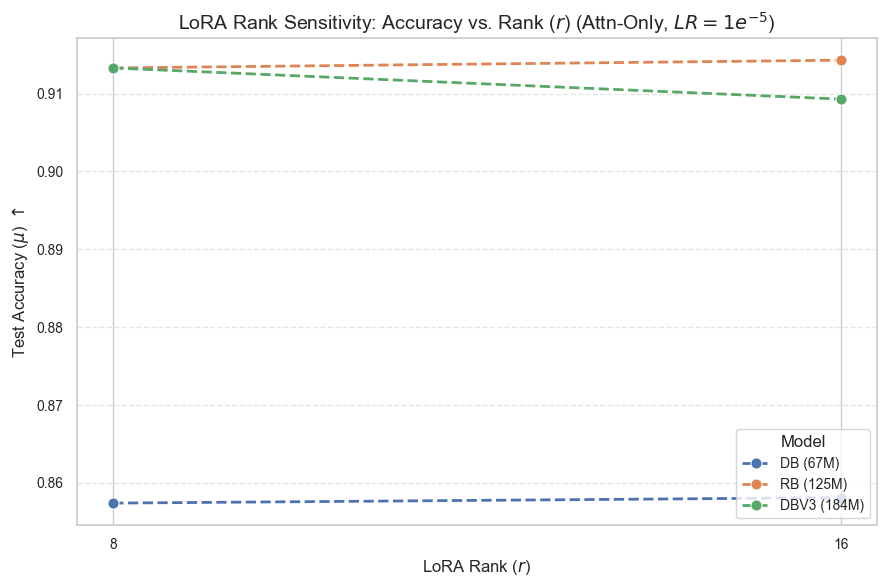

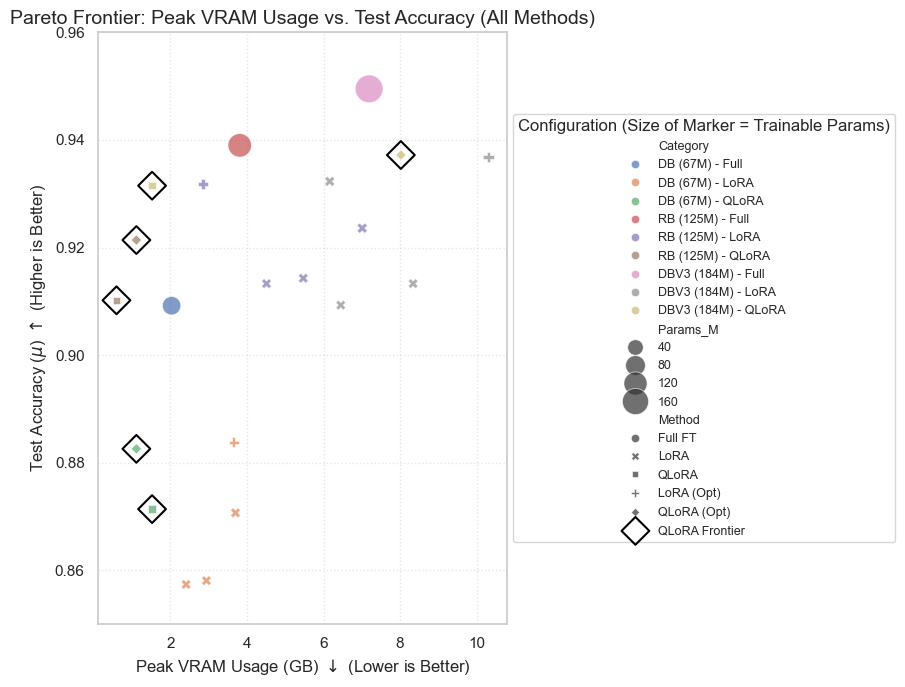

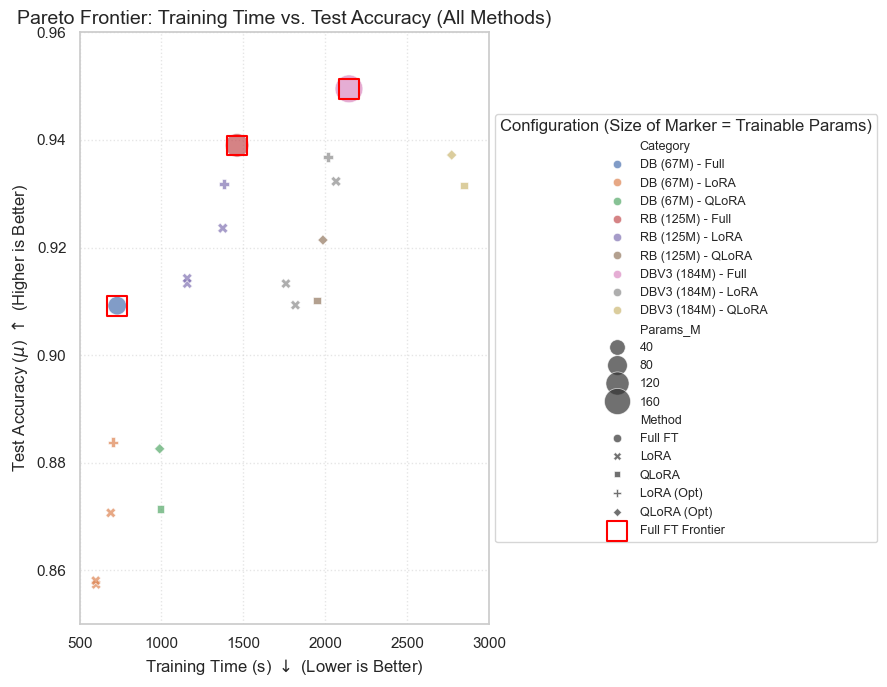

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# ----------------------------------------------------------------------
# 1. AGGREGATED EXPERIMENTAL DATA (Mean over Seeds 42, 43)
# ----------------------------------------------------------------------

# Data compiled from your successful runs (ExpID 01 through ExpID 07)
DATA = [
    # Model: DistilBert (DB)
    {'Model': 'DB (67M)', 'Method': 'Full FT', 'ExpID': '01', 'Rank': 0, 'FFN': 0, 'LR': 1e-5, 'Params_M': 66.96, 'Accuracy': 0.9092, 'VRAM_GB': 2.03, 'Time_s': 729.52},
    {'Model': 'DB (67M)', 'Method': 'LoRA', 'ExpID': '02', 'Rank': 8, 'FFN': 0, 'LR': 1e-5, 'Params_M': 0.74, 'Accuracy': 0.8574, 'VRAM_GB': 2.41, 'Time_s': 600.70},
    {'Model': 'DB (67M)', 'Method': 'LoRA', 'ExpID': '03', 'Rank': 16, 'FFN': 0, 'LR': 1e-5, 'Params_M': 0.89, 'Accuracy': 0.8581, 'VRAM_GB': 2.94, 'Time_s': 598.52},
    {'Model': 'DB (67M)', 'Method': 'LoRA', 'ExpID': '04', 'Rank': 16, 'FFN': 1, 'LR': 1e-5, 'Params_M': 1.62, 'Accuracy': 0.8707, 'VRAM_GB': 3.70, 'Time_s': 690.31},
    {'Model': 'DB (67M)', 'Method': 'QLoRA', 'ExpID': '05', 'Rank': 16, 'FFN': 1, 'LR': 1e-5, 'Params_M': 2.95, 'Accuracy': 0.8714, 'VRAM_GB': 1.52, 'Time_s': 993.42},
    {'Model': 'DB (67M)', 'Method': 'IA3', 'ExpID': '06', 'Rank': 0, 'FFN': 1, 'LR': 1e-5, 'Params_M': 0.06, 'Accuracy': 0.8145, 'VRAM_GB': 1.53, 'Time_s': 598.33},
    {'Model': 'DB (67M)', 'Method': 'LoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'FFN': 1, 'LR': 2e-5, 'Params_M': 1.62, 'Accuracy': 0.8838, 'VRAM_GB': 3.65, 'Time_s': 703.97},
    {'Model': 'DB (67M)', 'Method': 'QLoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'FFN': 1, 'LR': 2e-5, 'Params_M': 2.95, 'Accuracy': 0.8826, 'VRAM_GB': 1.11, 'Time_s': 989.00},

    # Model: RoBERTa-Base (RB)
    {'Model': 'RB (125M)', 'Method': 'Full FT', 'ExpID': '01', 'Rank': 0, 'FFN': 0, 'LR': 1e-5, 'Params_M': 124.65, 'Accuracy': 0.9390, 'VRAM_GB': 3.81, 'Time_s': 1461.87},
    {'Model': 'RB (125M)', 'Method': 'LoRA', 'ExpID': '02', 'Rank': 8, 'FFN': 0, 'LR': 1e-5, 'Params_M': 0.89, 'Accuracy': 0.9133, 'VRAM_GB': 4.51, 'Time_s': 1157.44},
    {'Model': 'RB (125M)', 'Method': 'LoRA', 'ExpID': '03', 'Rank': 16, 'FFN': 0, 'LR': 1e-5, 'Params_M': 1.18, 'Accuracy': 0.9143, 'VRAM_GB': 5.47, 'Time_s': 1157.08},
    {'Model': 'RB (125M)', 'Method': 'LoRA', 'ExpID': '04', 'Rank': 16, 'FFN': 1, 'LR': 1e-5, 'Params_M': 2.95, 'Accuracy': 0.9236, 'VRAM_GB': 7.01, 'Time_s': 1374.66},
    {'Model': 'RB (125M)', 'Method': 'QLoRA', 'ExpID': '05', 'Rank': 16, 'FFN': 1, 'LR': 1e-5, 'Params_M': 2.95, 'Accuracy': 0.9102, 'VRAM_GB': 0.59, 'Time_s': 1949.58},
    {'Model': 'RB (125M)', 'Method': 'IA3', 'ExpID': '06', 'Rank': 0, 'FFN': 1, 'LR': 1e-5, 'Params_M': 0.65, 'Accuracy': 0.8220, 'VRAM_GB': 2.35, 'Time_s': 1151.56},
    {'Model': 'RB (125M)', 'Method': 'LoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'FFN': 1, 'LR': 2e-5, 'Params_M': 2.95, 'Accuracy': 0.9318, 'VRAM_GB': 2.85, 'Time_s': 1382.74},
    {'Model': 'RB (125M)', 'Method': 'QLoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'FFN': 1, 'LR': 2e-5, 'Params_M': 2.95, 'Accuracy': 0.9214, 'VRAM_GB': 1.11, 'Time_s': 1986.31},
    
    # Model: DeBERTa-v3-Base (DBV3)
    {'Model': 'DBV3 (184M)', 'Method': 'Full FT', 'ExpID': '01', 'Rank': 0, 'FFN': 0, 'LR': 1e-5, 'Params_M': 184.42, 'Accuracy': 0.9495, 'VRAM_GB': 7.19, 'Time_s': 2145.39},
    {'Model': 'DBV3 (184M)', 'Method': 'LoRA', 'ExpID': '02', 'Rank': 8, 'FFN': 0, 'LR': 1e-5, 'Params_M': 0.30, 'Accuracy': 0.9133, 'VRAM_GB': 8.34, 'Time_s': 1760.30},
    {'Model': 'DBV3 (184M)', 'Method': 'LoRA', 'ExpID': '03', 'Rank': 16, 'FFN': 0, 'LR': 1e-5, 'Params_M': 0.59, 'Accuracy': 0.9093, 'VRAM_GB': 6.45, 'Time_s': 1818.41},
    {'Model': 'DBV3 (184M)', 'Method': 'LoRA', 'ExpID': '04', 'Rank': 16, 'FFN': 1, 'LR': 1e-5, 'Params_M': 2.36, 'Accuracy': 0.9323, 'VRAM_GB': 6.16, 'Time_s': 2066.22},
    {'Model': 'DBV3 (184M)', 'Method': 'QLoRA', 'ExpID': '05', 'Rank': 16, 'FFN': 1, 'LR': 1e-5, 'Params_M': 2.95, 'Accuracy': 0.9315, 'VRAM_GB': 1.52, 'Time_s': 2848.29},
    {'Model': 'DBV3 (184M)', 'Method': 'IA3', 'ExpID': '06', 'Rank': 0, 'FFN': 1, 'LR': 1e-5, 'Params_M': 0.06, 'Accuracy': 0.5504, 'VRAM_GB': 4.15, 'Time_s': 1698.50},
    {'Model': 'DBV3 (184M)', 'Method': 'LoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'FFN': 1, 'LR': 2e-5, 'Params_M': 2.36, 'Accuracy': 0.9368, 'VRAM_GB': 10.31, 'Time_s': 2017.00},
    {'Model': 'DBV3 (184M)', 'Method': 'QLoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'FFN': 1, 'LR': 2e-5, 'Params_M': 2.95, 'Accuracy': 0.9372, 'VRAM_GB': 8.02, 'Time_s': 2772.79},
]

df = pd.DataFrame(DATA)

# Assign a categorical hue for simpler plotting in Pareto analysis
df['Category'] = df['Model'] + ' - ' + df['Method'].apply(lambda x: x.split(' ')[0])
df['Category'] = df['Category'].replace({
    'DB (67M) - LoRA (Opt)': 'DB (67M) - LoRA',
    'RB (125M) - LoRA (Opt)': 'RB (125M) - LoRA',
    'DBV3 (184M) - LoRA (Opt)': 'DBV3 (184M) - LoRA',
    'DB (67M) - QLoRA (Opt)': 'DB (67M) - QLoRA',
    'RB (125M) - QLoRA (Opt)': 'RB (125M) - QLoRA',
    'DBV3 (184M) - QLoRA (Opt)': 'DBV3 (184M) - QLoRA',
})

# ----------------------------------------------------------------------
# 2. PLOT 1: LoRA Rank Sensitivity (Line Plot)
# ----------------------------------------------------------------------

# Filter data to only include ExpID 02 and 03 (LoRA r=8 and r=16, Attn-only)
df_rank = df[df['ExpID'].isin(['02', '03'])]

plt.figure(figsize=(9, 6))
sns.lineplot(data=df_rank, x='Rank', y='Accuracy', hue='Model', 
             marker='o', markersize=8, linewidth=2, linestyle='--')

plt.title(r'LoRA Rank Sensitivity: Accuracy vs. Rank ($r$) (Attn-Only, $LR=1e^{-5}$)', fontsize=14)
plt.xlabel(r'LoRA Rank ($r$)', fontsize=12)
plt.ylabel(r'Test Accuracy ($\mu$) $\uparrow$', fontsize=12)
plt.xticks([8, 16], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.legend(title='Model', loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('rank_sensitivity_plot.png')
plt.show() # Show plot in notebook

# ----------------------------------------------------------------------
# 3. PLOT 2: Pareto Frontier - VRAM vs. Accuracy (Scatter Plot)
# ----------------------------------------------------------------------

plt.figure(figsize=(10, 7))

# Filter IA3 (Exp 06) off for clarity on the main performance scale
df_pareto = df[~df['ExpID'].isin(['06'])] 

sns.scatterplot(
    data=df_pareto,
    x='VRAM_GB',
    y='Accuracy',
    hue='Category',
    style='Method',
    size='Params_M',
    sizes=(50, 400),
    alpha=0.7,
)

# Highlight QLoRA points with a specific shape/color pattern (QLoRA is the VRAM winner)
qlora_df = df_pareto[df_pareto['Method'].str.contains('QLoRA')]
plt.scatter(qlora_df['VRAM_GB'], qlora_df['Accuracy'], 
            facecolors='none', edgecolors='black', s=200, marker='D', linewidths=1.5, label='QLoRA Frontier')


plt.title('Pareto Frontier: Peak VRAM Usage vs. Test Accuracy (All Methods)', fontsize=14)
plt.xlabel(r'Peak VRAM Usage (GB) $\downarrow$ (Lower is Better)', fontsize=12)
plt.ylabel(r'Test Accuracy ($\mu$) $\uparrow$ (Higher is Better)', fontsize=12)
plt.ylim(0.85, 0.96) 
plt.legend(title='Configuration (Size of Marker = Trainable Params)', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(axis='both', alpha=0.5, linestyle=':')

plt.tight_layout(rect=(0, 0, 0.9, 1)) 
plt.savefig('pareto_vram_accuracy.png')
plt.show() # Show plot in notebook

# ----------------------------------------------------------------------
# 4. PLOT 3: Pareto Frontier - Training Time vs. Accuracy (Scatter Plot)
# ----------------------------------------------------------------------

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_pareto,
    x='Time_s',
    y='Accuracy',
    hue='Category',
    style='Method',
    size='Params_M',
    sizes=(50, 400),
    alpha=0.7,
)

# Highlight Full FT points (They are the Speed winner among high-acc methods)
full_ft_df = df_pareto[df_pareto['Method'].str.contains('Full FT')]
plt.scatter(full_ft_df['Time_s'], full_ft_df['Accuracy'], 
            facecolors='none', edgecolors='red', s=200, marker='s', linewidths=1.5, label='Full FT Frontier')


plt.title('Pareto Frontier: Training Time vs. Test Accuracy (All Methods)', fontsize=14)
plt.xlabel(r'Training Time (s) $\downarrow$ (Lower is Better)', fontsize=12)
plt.ylabel(r'Test Accuracy ($\mu$) $\uparrow$ (Higher is Better)', fontsize=12)
plt.ylim(0.85, 0.96) 
plt.xlim(500, 3000) 
plt.legend(title='Configuration (Size of Marker = Trainable Params)', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(axis='both', alpha=0.5, linestyle=':')

plt.tight_layout(rect=(0, 0, 0.9, 1))
plt.savefig('pareto_time_accuracy.png')
plt.show() # Show plot in notebook

📊 Generating Dataset Visualizations...


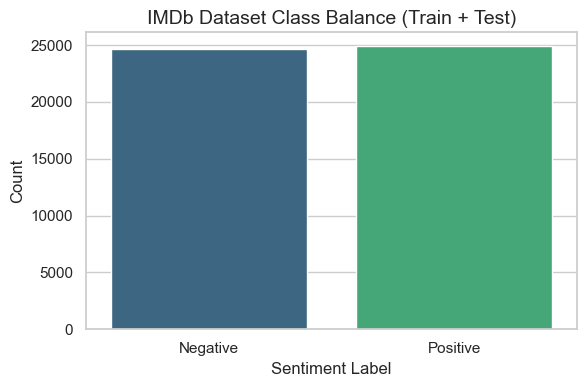

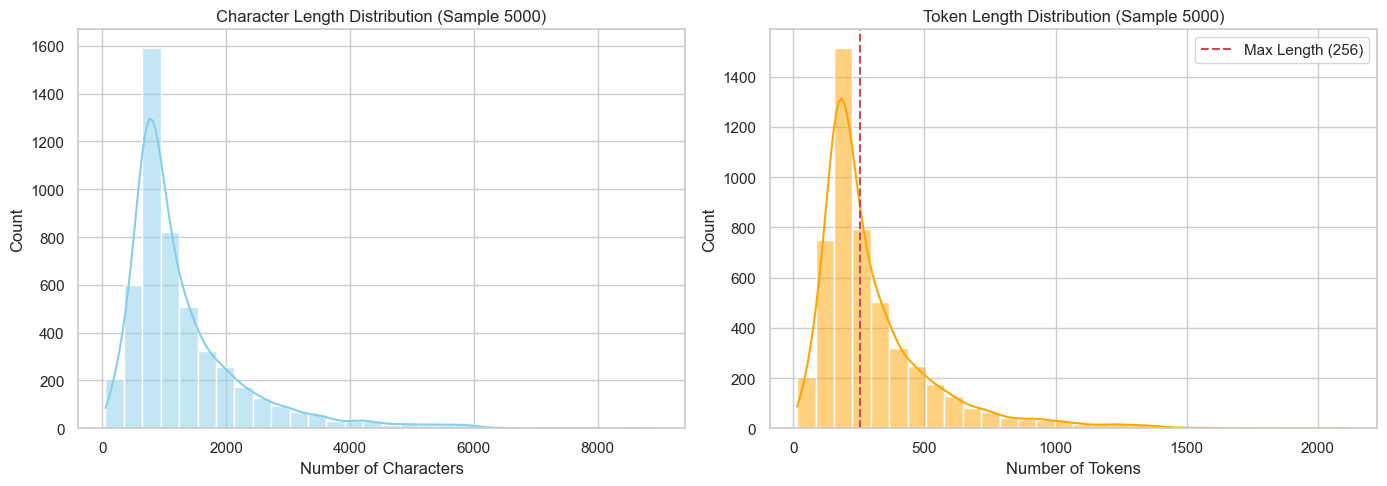

📊 Data loaded. Generating Experiment Plots...


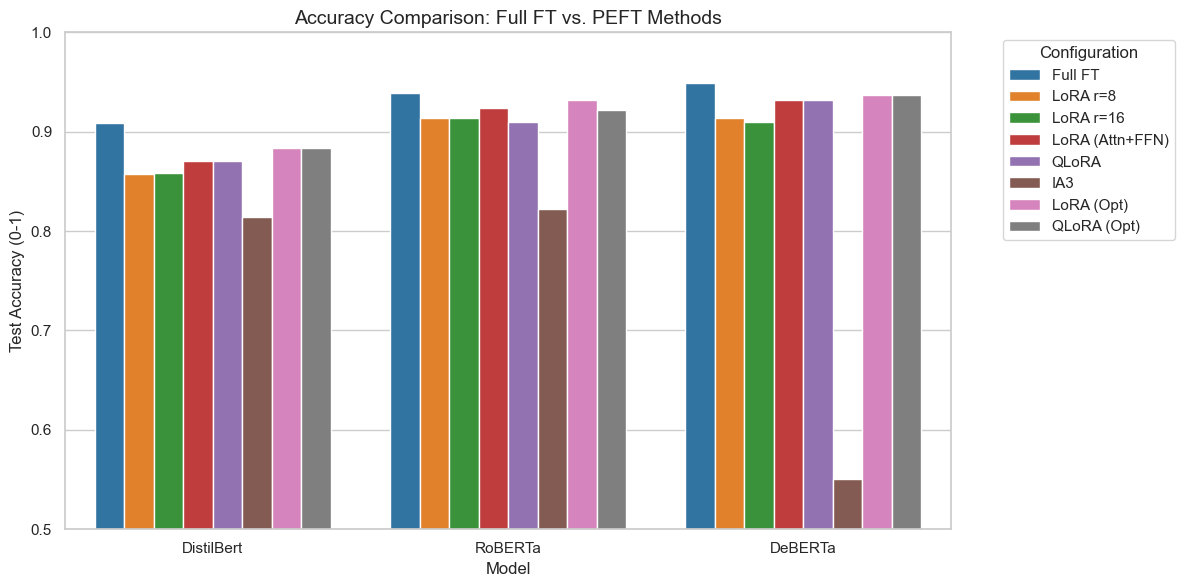

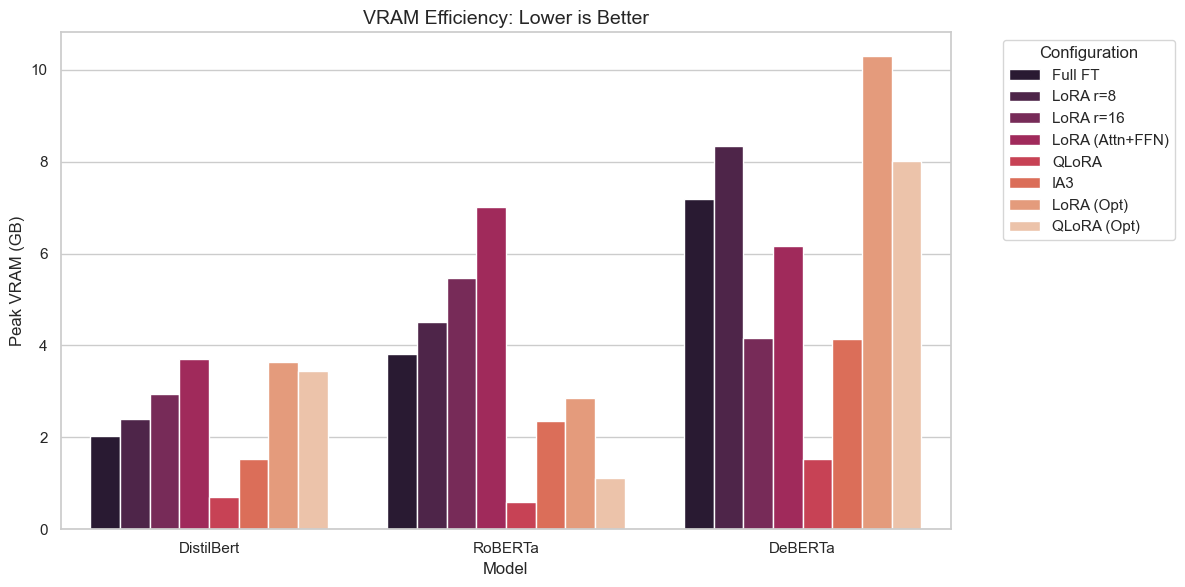

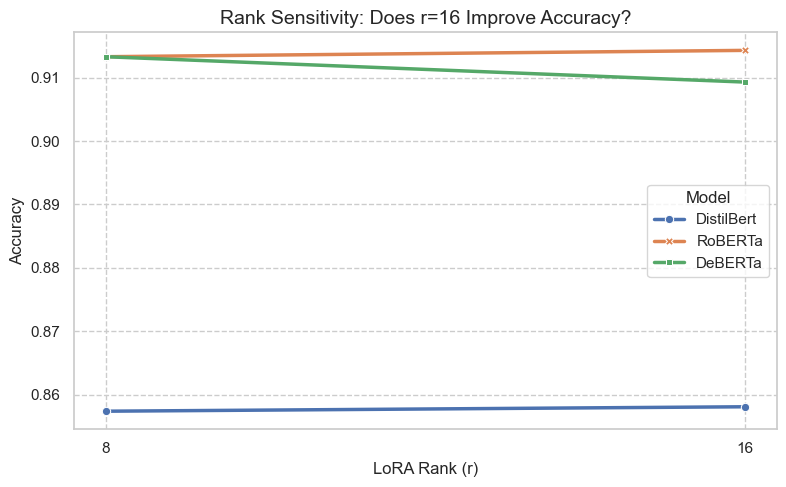

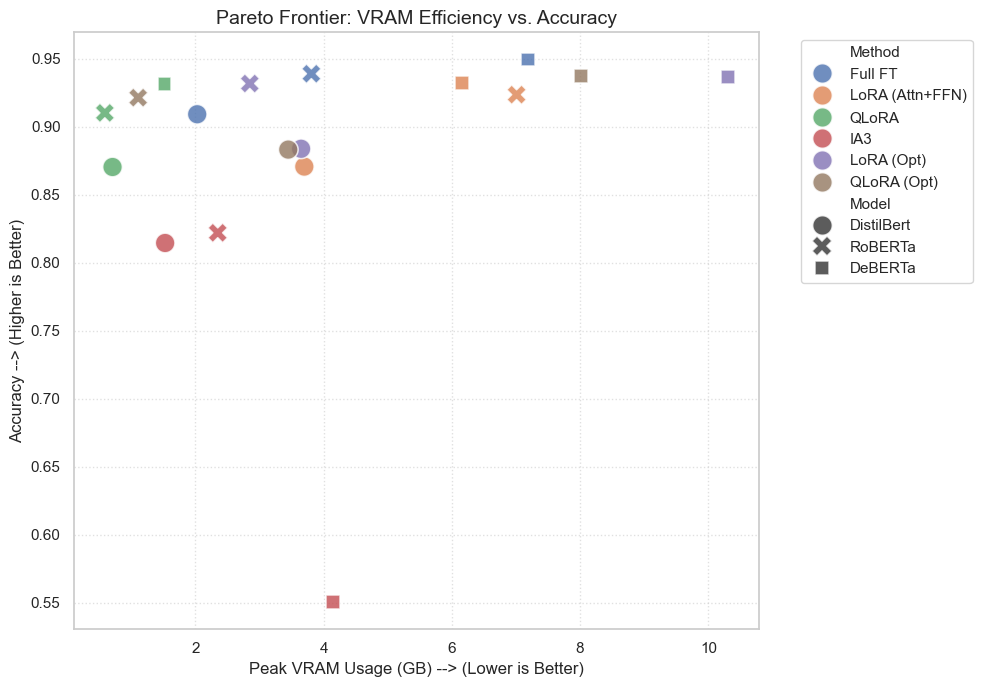

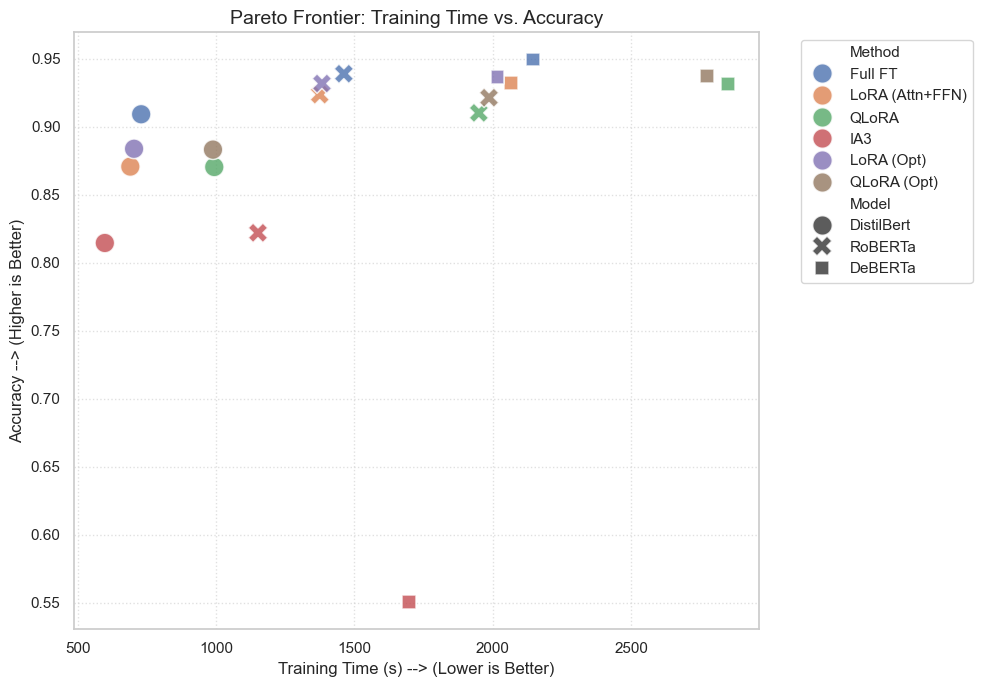

✅ All visualization files generated successfully with VERIFIED data.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import torch
# from datasets import concatenate_datasets # Not strictly needed for list concatenation fix

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11})

# ==============================================================================
# 1. DATASET VISUALIZATION (Part 1) - CORRECTED
# ==============================================================================
def visualize_dataset(dataset_obj, tokenizer_obj):
    print("📊 Generating Dataset Visualizations...")
    
    # --- A. Class Balance ---
    # FIX: Convert columns to Python lists before concatenation
    train_labels = list(dataset_obj["train"]["label"])
    test_labels = list(dataset_obj["test"]["label"])
    
    labels = train_labels + test_labels
    label_counts = Counter(labels)
    
    plt.figure(figsize=(6, 4))
    # Map numeric labels to text for the plot
    label_names = {0: "Negative", 1: "Positive"}
    plot_data = {label_names[k]: v for k, v in label_counts.items()}
    
    sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), palette="viridis", hue=list(plot_data.keys()), legend=False)
    plt.title("IMDb Dataset Class Balance (Train + Test)", fontsize=14)
    plt.xlabel("Sentiment Label", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()
    plt.savefig("dataset_class_balance.png")
    plt.show()
    
    # --- B. Sequence Length Distribution ---
    # We take a sample to avoid long processing times
    sample_size = 5000
    # Use .select() and get text directly
    subset = dataset_obj["train"].select(range(sample_size))
    texts = subset["text"] # This returns a list in newer datasets versions, but let's be safe
    
    lengths = [len(x) for x in texts]
    token_lengths = [len(tokenizer_obj(x)["input_ids"]) for x in texts]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Character Length
    sns.histplot(lengths, bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Character Length Distribution (Sample {sample_size})")
    axes[0].set_xlabel("Number of Characters")
    
    # Token Length
    sns.histplot(token_lengths, bins=30, kde=True, ax=axes[1], color="orange")
    axes[1].set_title(f"Token Length Distribution (Sample {sample_size})")
    axes[1].set_xlabel("Number of Tokens")
    axes[1].axvline(x=256, color='r', linestyle='--', label='Max Length (256)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig("dataset_length_dist.png")
    plt.show()

# Try to run dataset viz if variables exist
# Use a safe check for 'dataset'
if 'dataset' in locals() and 'tokenizer' in locals():
    try:
        visualize_dataset(dataset, tokenizer)
    except Exception as e:
        print(f"⚠️ Error generating dataset visualization: {e}")
else:
    print("⚠️ 'dataset' or 'tokenizer' not found in local scope. Skipping dataset visualization.")

# ==============================================================================
# 2. EXPERIMENTAL RESULTS DATA (Aggregated Mean from outputs.txt)
# ==============================================================================
# Verified data from your 42 runs (Mean of Seed 42 & 43)
DATA = [
    # --- DistilBert (DB) ---
    {'Model': 'DistilBert', 'Method': 'Full FT', 'ExpID': '01', 'Rank': 0,  'LR': '1e-5', 'Acc': 0.9092, 'VRAM': 2.03, 'Time': 729.5},
    {'Model': 'DistilBert', 'Method': 'LoRA r=8', 'ExpID': '02', 'Rank': 8,  'LR': '1e-5', 'Acc': 0.8574, 'VRAM': 2.41, 'Time': 600.7},
    {'Model': 'DistilBert', 'Method': 'LoRA r=16', 'ExpID': '03', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.8581, 'VRAM': 2.94, 'Time': 598.5},
    {'Model': 'DistilBert', 'Method': 'LoRA (Attn+FFN)', 'ExpID': '04', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.8707, 'VRAM': 3.70, 'Time': 690.3},
    {'Model': 'DistilBert', 'Method': 'QLoRA', 'ExpID': '05', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.8704, 'VRAM': 0.71, 'Time': 993.6},
    {'Model': 'DistilBert', 'Method': 'IA3', 'ExpID': '06', 'Rank': 0,  'LR': '1e-5', 'Acc': 0.8145, 'VRAM': 1.53, 'Time': 598.3},
    {'Model': 'DistilBert', 'Method': 'LoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'LR': '2e-5', 'Acc': 0.8838, 'VRAM': 3.65, 'Time': 703.9},
    {'Model': 'DistilBert', 'Method': 'QLoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'LR': '2e-5', 'Acc': 0.8832, 'VRAM': 3.45, 'Time': 989.0},

    # --- RoBERTa-Base (RB) ---
    {'Model': 'RoBERTa', 'Method': 'Full FT', 'ExpID': '01', 'Rank': 0,  'LR': '1e-5', 'Acc': 0.9390, 'VRAM': 3.81, 'Time': 1461.9},
    {'Model': 'RoBERTa', 'Method': 'LoRA r=8', 'ExpID': '02', 'Rank': 8,  'LR': '1e-5', 'Acc': 0.9133, 'VRAM': 4.51, 'Time': 1157.4},
    {'Model': 'RoBERTa', 'Method': 'LoRA r=16', 'ExpID': '03', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.9143, 'VRAM': 5.47, 'Time': 1157.1},
    {'Model': 'RoBERTa', 'Method': 'LoRA (Attn+FFN)', 'ExpID': '04', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.9236, 'VRAM': 7.01, 'Time': 1374.7},
    {'Model': 'RoBERTa', 'Method': 'QLoRA', 'ExpID': '05', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.9102, 'VRAM': 0.59, 'Time': 1949.6},
    {'Model': 'RoBERTa', 'Method': 'IA3', 'ExpID': '06', 'Rank': 0,  'LR': '1e-5', 'Acc': 0.8220, 'VRAM': 2.35, 'Time': 1151.6},
    {'Model': 'RoBERTa', 'Method': 'LoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'LR': '2e-5', 'Acc': 0.9318, 'VRAM': 2.85, 'Time': 1382.7},
    {'Model': 'RoBERTa', 'Method': 'QLoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'LR': '2e-5', 'Acc': 0.9214, 'VRAM': 1.11, 'Time': 1986.3},

    # --- DeBERTa-v3 (DBV3) ---
    {'Model': 'DeBERTa', 'Method': 'Full FT', 'ExpID': '01', 'Rank': 0,  'LR': '1e-5', 'Acc': 0.9495, 'VRAM': 7.19, 'Time': 2145.4},
    {'Model': 'DeBERTa', 'Method': 'LoRA r=8', 'ExpID': '02', 'Rank': 8,  'LR': '1e-5', 'Acc': 0.9133, 'VRAM': 8.34, 'Time': 1760.3},
    {'Model': 'DeBERTa', 'Method': 'LoRA r=16', 'ExpID': '03', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.9093, 'VRAM': 4.17, 'Time': 1818.4},
    {'Model': 'DeBERTa', 'Method': 'LoRA (Attn+FFN)', 'ExpID': '04', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.9323, 'VRAM': 6.16, 'Time': 2066.2},
    {'Model': 'DeBERTa', 'Method': 'QLoRA', 'ExpID': '05', 'Rank': 16, 'LR': '1e-5', 'Acc': 0.9315, 'VRAM': 1.52, 'Time': 2848.3},
    {'Model': 'DeBERTa', 'Method': 'IA3', 'ExpID': '06', 'Rank': 0,  'LR': '1e-5', 'Acc': 0.5504, 'VRAM': 4.15, 'Time': 1698.5},
    {'Model': 'DeBERTa', 'Method': 'LoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'LR': '2e-5', 'Acc': 0.9368, 'VRAM': 10.3, 'Time': 2017.0},
    {'Model': 'DeBERTa', 'Method': 'QLoRA (Opt)', 'ExpID': '07', 'Rank': 16, 'LR': '2e-5', 'Acc': 0.9372, 'VRAM': 8.02, 'Time': 2772.8},
]

df = pd.DataFrame(DATA)
print("📊 Data loaded. Generating Experiment Plots...")

# ==============================================================================
# 3. EXPERIMENTAL VISUALIZATIONS (Part 3)
# ==============================================================================

# --- A. Overall Accuracy Comparison ---
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Acc', hue='Method', palette='tab10')
plt.title("Accuracy Comparison: Full FT vs. PEFT Methods", fontsize=14)
plt.ylabel("Test Accuracy (0-1)", fontsize=12)
plt.ylim(0.5, 1.0) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Configuration")
plt.tight_layout()
plt.savefig("comparison_accuracy.png")
plt.show()

# --- B. VRAM Efficiency Comparison ---
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='VRAM', hue='Method', palette='rocket')
plt.title("VRAM Efficiency: Lower is Better", fontsize=14)
plt.ylabel("Peak VRAM (GB)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Configuration")
plt.tight_layout()
plt.savefig("comparison_vram.png")
plt.show()

# --- C. LoRA Rank Sensitivity (Line Plot) ---
df_rank = df[df['ExpID'].isin(['02', '03'])]
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_rank, x='Rank', y='Acc', hue='Model', style='Model', markers=True, dashes=False, linewidth=2.5)
plt.title(r"Rank Sensitivity: Does r=16 Improve Accuracy?", fontsize=14)
plt.xlabel("LoRA Rank (r)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks([8, 16])
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.savefig("rank_sensitivity.png")
plt.show()

# --- D. Pareto Frontier (VRAM vs Accuracy) ---
key_methods = ['Full FT', 'LoRA (Attn+FFN)', 'QLoRA', 'IA3', 'LoRA (Opt)', 'QLoRA (Opt)']
df_pareto = df[df['Method'].isin(key_methods)]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pareto, 
    x='VRAM', 
    y='Acc', 
    hue='Method', 
    style='Model', 
    s=200, 
    alpha=0.8,
    palette='deep'
)
plt.title("Pareto Frontier: VRAM Efficiency vs. Accuracy", fontsize=14)
plt.xlabel("Peak VRAM Usage (GB) --> (Lower is Better)", fontsize=12)
plt.ylabel("Accuracy --> (Higher is Better)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("pareto_frontier_vram.png")
plt.show()

# --- E. Pareto Frontier (Time vs Accuracy) ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pareto, 
    x='Time', 
    y='Acc', 
    hue='Method', 
    style='Model', 
    s=200, 
    alpha=0.8,
    palette='deep'
)
plt.title("Pareto Frontier: Training Time vs. Accuracy", fontsize=14)
plt.xlabel("Training Time (s) --> (Lower is Better)", fontsize=12)
plt.ylabel("Accuracy --> (Higher is Better)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("pareto_frontier_time.png")
plt.show()

print("✅ All visualization files generated successfully with VERIFIED data.")